In [242]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import math
import time
import cv2

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.filterwarnings(action='ignore')

#!pip install -U keras-tuner
import keras_tuner as kt

from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import GlobalAveragePooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.callbacks import EarlyStopping

from sklearn.model_selection import RandomizedSearchCV #for 
from keras.wrappers.scikit_learn import KerasRegressor

# 1. Funciones

In [357]:
def show_features(features,layer):
    feature_maps = features[layer]
    print('feature_maps shape: ', feature_maps.shape)

# plot all 256 maps in an 16x16 squares
    square = 16
    ix = 1
    plt.figure(figsize=(40, 40))
    for _ in range(square):
        for _ in range(square):
            # specify subplot and turn of axis
            ax = plt.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            # plot filter channel in grayscale
            plt.imshow(feature_maps[0, :, :, ix - 1], cmap='viridis')
            ix += 1
    # show the figure
    plt.show()

In [426]:
def show_features2(features,layer):
    feature_maps = features[layer] 
    print('feature_maps shape: ', feature_maps.shape)
    for i in range(feature_maps.shape[-1]):
        plt.xticks([])
        plt.yticks([])
        plt.imshow(feature_maps[0, :, :, i], cmap='viridis')
        plt.show()
        print(feature_maps[0, :, :, i])

In [288]:
def show_results(model,X_test,y_test):
    results = model.evaluate(X_test, y_test, verbose=0)
    print('Test Loss: {}'.format(results[0]))
    print('Test Accuracy: {}'.format(results[1]))
    y_pred = model.predict(X_test)
    y_test_list = []
    if isinstance(y_test, pd.DataFrame):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i]['energia'])
    elif isinstance(y_test, np.ndarray):
        for i in range(0,len(y_test)):
            y_test_list.append(y_test[i][0])
    else:
        for i in range(0,len(y_test)):
            y_test_list.append(y_test.iloc[i])
    try:
        if y_pred.shape[1] == 1: y_pred = np.transpose(y_pred)[0]
    except IndexError:
        pass
    #print(y_test_list,y_pred)
    SSres = sum((y_test_list - y_pred)**2)
    media = np.mean(y_test_list)
    SStot = sum((y_test_list-media)**2)
    R_cuadrado = 1- SSres/SStot
    print('Coeficiente de correlacion: %s'%R_cuadrado)
    plt.plot(y_pred)
    plt.plot(y_test_list)
    plt.show()
    plt.scatter(y_test_list, y_pred)
    plt.xlabel('True Values [Energy(kcal/mol)]')
    plt.ylabel('Predictions [Energy(kcal/mol)]')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim([0,plt.xlim()[1]])
    plt.ylim([0,plt.ylim()[1]])
    _ = plt.plot([-100, 100], [-100, 100], 'r--')
    plt.show()
    error = y_pred - y_test_list
    plt.hist(error, bins = 25)
    plt.xlabel("Prediction Error [Energy(kcal/mol)]")
    _ = plt.ylabel("Count")

In [231]:
def show_loss_accuracy_evolution(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Categorical Crossentropy')
    ax1.plot(hist['epoch'], hist['loss'], label='Train loss')
    ax1.plot(hist['epoch'], hist['val_loss'], label = 'Val loss')
    ax1.grid()
    ax1.legend()

    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    ax2.plot(hist['epoch'], hist['val_mean_absolute_error'], label = 'Val Error')
    ax2.grid()
    ax2.legend()

    plt.show()

In [205]:
def PrepareConvInput(X,Y):
    X = X[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']].to_numpy(copy=True).astype(int)
    Xg = keras.utils.to_categorical(X, num_classes=None, dtype='int') #Crea una codificación binaria para cada número en función 
    # del número de clases, es decir, si hay 4 clases el vector [0,3] queda como [[1,0,0,0],[0,0,0,1]]
    Yg = Y.to_numpy(copy=True).astype(float)
    return Xg,Yg

In [117]:
def errors(real, predictions):
    mse = mean_squared_error(real, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(real, predictions)
    r2 = r2_score(real, predictions)

    print('Mean Squared Error (MSE): ', mse)
    print('Root Mean Squared Error (RMSE): ', rmse)
    print('Mean Absolute Error (MAE): ', mae)
    print('R-squared Score (R^2): ', r2)

In [272]:
def create_images(datos,n_pos,n_sust):

    columns = list(datos.columns.values)
    images = [np.zeros((n_pos,n_sust,1),dtype=np.uint8) for i in range(len(datos))]
    for i,j in enumerate(images):
        for l,k in enumerate(columns):
            j[l,datos.iloc[i][k]] = 1

    return images

In [119]:
def show_samples(images):
    
    W = 2
    L = math.ceil(len(images)/W)
    fig, axes = plt.subplots(L, W, figsize=(32,32))
    axes = axes = axes.ravel()

    for i in np.arange(0, len(images)):
        axes[i].imshow(images[i])
#        title = "{0} {1} {2} {3}".format(images[i][0,0],images[i][1,0],images[i][1,1],images[i][0,1])
#        axes[i].set_title(title)
        axes[i].axis('off')

#    plt.subplots_adjust(wspace=0.5)

In [120]:
def train_test_list(lista_mol):

    print(lista_mol)
    X_train = pd.DataFrame()
    X_test = data[['familia','subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
    y_train = pd.DataFrame()
    y_test = data[['familia','energia']]
    for i in lista_mol:
        X_new = data[data.familia == i][['subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4']]
        X_train = pd.concat([X_train, X_new])
        y_new = data[data.familia == i][['energia']]
        y_train = pd.concat([y_train, y_new])
        X_test = X_test[X_test.familia != i]
        y_test = y_test[y_test.familia != i]
    X_test = X_test.drop(['familia'], axis=1)
    y_test = y_test.drop(['familia'], axis=1)
    return X_train, X_test, y_train, y_test

In [121]:
def train_test_encode(lista_train,lista_test):
    encoder = OneHotEncoder(sparse=False, categories='auto')

    X_train = lista_train.drop(['energia'], axis=1)
    X_test = lista_test.drop(['energia'], axis=1)

# Fit the encoder and transform the data for both train and test dataframes
    encoded_train = encoder.fit_transform(X_train)
    encoded_test = encoder.transform(X_test)

# Now, 'encoded_train' and 'encoded_test' are numpy arrays, we can convert them back to dataframes:
    X_train_scaled = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(X_train.columns))
    X_test_scaled = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(X_test.columns))

    y_test = lista_test['energia']
    y_train = lista_train['energia']
    return X_train, X_test, y_train, y_test

In [262]:
def write_images(images, directory):
    import os
    import cv2

# Directorio donde se guardarán las imágenes -> directory

# Verificar si el directorio existe, y si no, crearlo
    if not os.path.exists(directory):
        os.makedirs(directory)

# Guardar la imagen en el directorio
    name = "Derv_"
    for image in images:
        image_name = name
        for i in image:
            image_name += str(np.argmax(i))
        image_name += ".png"
        file_path = os.path.join(directory, image_name)
        cv2.imwrite(file_path, image)

    print("Imagenes guardadas en:", directory)

# 2. Carga de datos

In [122]:
# cargamos el csv
data = pd.read_csv("ALLDATA2.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#first order energies
data1 = pd.read_csv("first_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data1.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']
#second order energies
data2 = pd.read_csv("second_order_energies.csv", sep =";", header = 0, low_memory = False, encoding='latin-1')
# renombramos las columnas por si acaso
data2.columns = ['familia', 'indice_fam', 'subposicion_1', 'subposicion_2', 'subposicion_3', 'subposicion_4', 'energia']

In [123]:
data

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,9.626816
1291,347,1,2,2,2,2,0.621384
1292,348,1,3,3,3,3,4.204761
1293,349,1,4,4,4,4,1.304497


In [124]:
data1

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,5.160484
1291,347,1,2,2,2,2,0.242418
1292,348,1,3,3,3,3,4.585988
1293,349,1,4,4,4,4,10.561626


In [125]:
data2

,familia,indice_fam,subposicion_1,subposicion_2,subposicion_3,subposicion_4,energia
0,1,1,0,0,0,1,1.290121
1,1,2,0,0,1,0,1.290121
2,1,3,1,0,0,0,1.290121
3,1,4,0,1,0,0,1.290121
4,2,1,0,0,0,2,0.060604
...,...,...,...,...,...,...,...
1290,346,1,1,1,1,1,9.785242
1291,347,1,2,2,2,2,1.880188
1292,348,1,3,3,3,3,4.004896
1293,349,1,4,4,4,4,10.148582


# 3. Modelización

## 3.1 Selección del data set inicial de forma manual

A la hora de seleccionar los datos de entrenamiento se puede hacer aleatoriamente o de forma manual. En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos un 0, es decir, que tengan al menos una posicion vacia.

In [126]:
lista = []
for i in range(len(data)):
    if data.iloc[i]['subposicion_1']==0 or data.iloc[i]['subposicion_2']==0 or data.iloc[i]['subposicion_3']==0 or data.iloc[i]['subposicion_4']==0:
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 0
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos dos 0, es decir, que tengan al menos dos posiciones vacias.

In [127]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_1','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3']].values==[0,0]) or all(data.iloc[i][['subposicion_2','subposicion_4']].values==[0,0]) or all(data.iloc[i][['subposicion_3','subposicion_4']].values==[0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 1
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

En el siguiente caso se crea una lista con las familias de compuestos que contengan al menos tres 0, es decir, que tengan al menos tres posiciones vacias.

In [38]:
lista = []
for i in range(len(data)):
    if all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_3']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_2','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_1','subposicion_3','subposicion_4']].values==[0,0,0]) or all(data.iloc[i][['subposicion_2','subposicion_3','subposicion_4']].values==[0,0,0]):
        lista.append(data.iloc[i]['familia'])
lista = list(set(lista))

mask = (data[['subposicion_1','subposicion_2','subposicion_3','subposicion_4']] == 0).sum(axis=1) > 2
lista_train = data.loc[mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]
lista_test = data.loc[~mask,['subposicion_1','subposicion_2','subposicion_3','subposicion_4','energia']]

Tambien podemos elegir los números de las familias que queremos inculir en el conjunto de entrenamiento

In [16]:
#lista = [34,56,21,67,96,3,6,90,344,234]
#X_train, X_test, y_train, y_test = train_test_list(lista_mol)

In [273]:
X_train, X_test, y_train, y_test = train_test_list(lista)
list(X_train.columns.values)
print(X_train.shape,y_train.shape)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 151.0, 152.0, 153.0, 259.0, 35.0, 36.0, 37.0, 301.0, 302.0, 303.0, 304.0, 305.0, 52.0, 53.0, 316.0, 317.0, 319.0, 66.0, 322.0, 326.0, 331.0, 332.0, 333.0, 334.0, 335.0, 81.0, 82.0, 83.0, 84.0, 211.0, 212.0]
(170, 4) (170, 1)


In [274]:
X_train = create_images(X_train,4,6)
X_test = create_images(X_test,4,6)
print(X_train)

[array([[[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [1],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8), array([[[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[0],
        [1],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8), array([[[0],
        [1],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]],

       [[1],
        [0],
        [0],
        [0],
        [0],
        [0]]], dtype=uint8

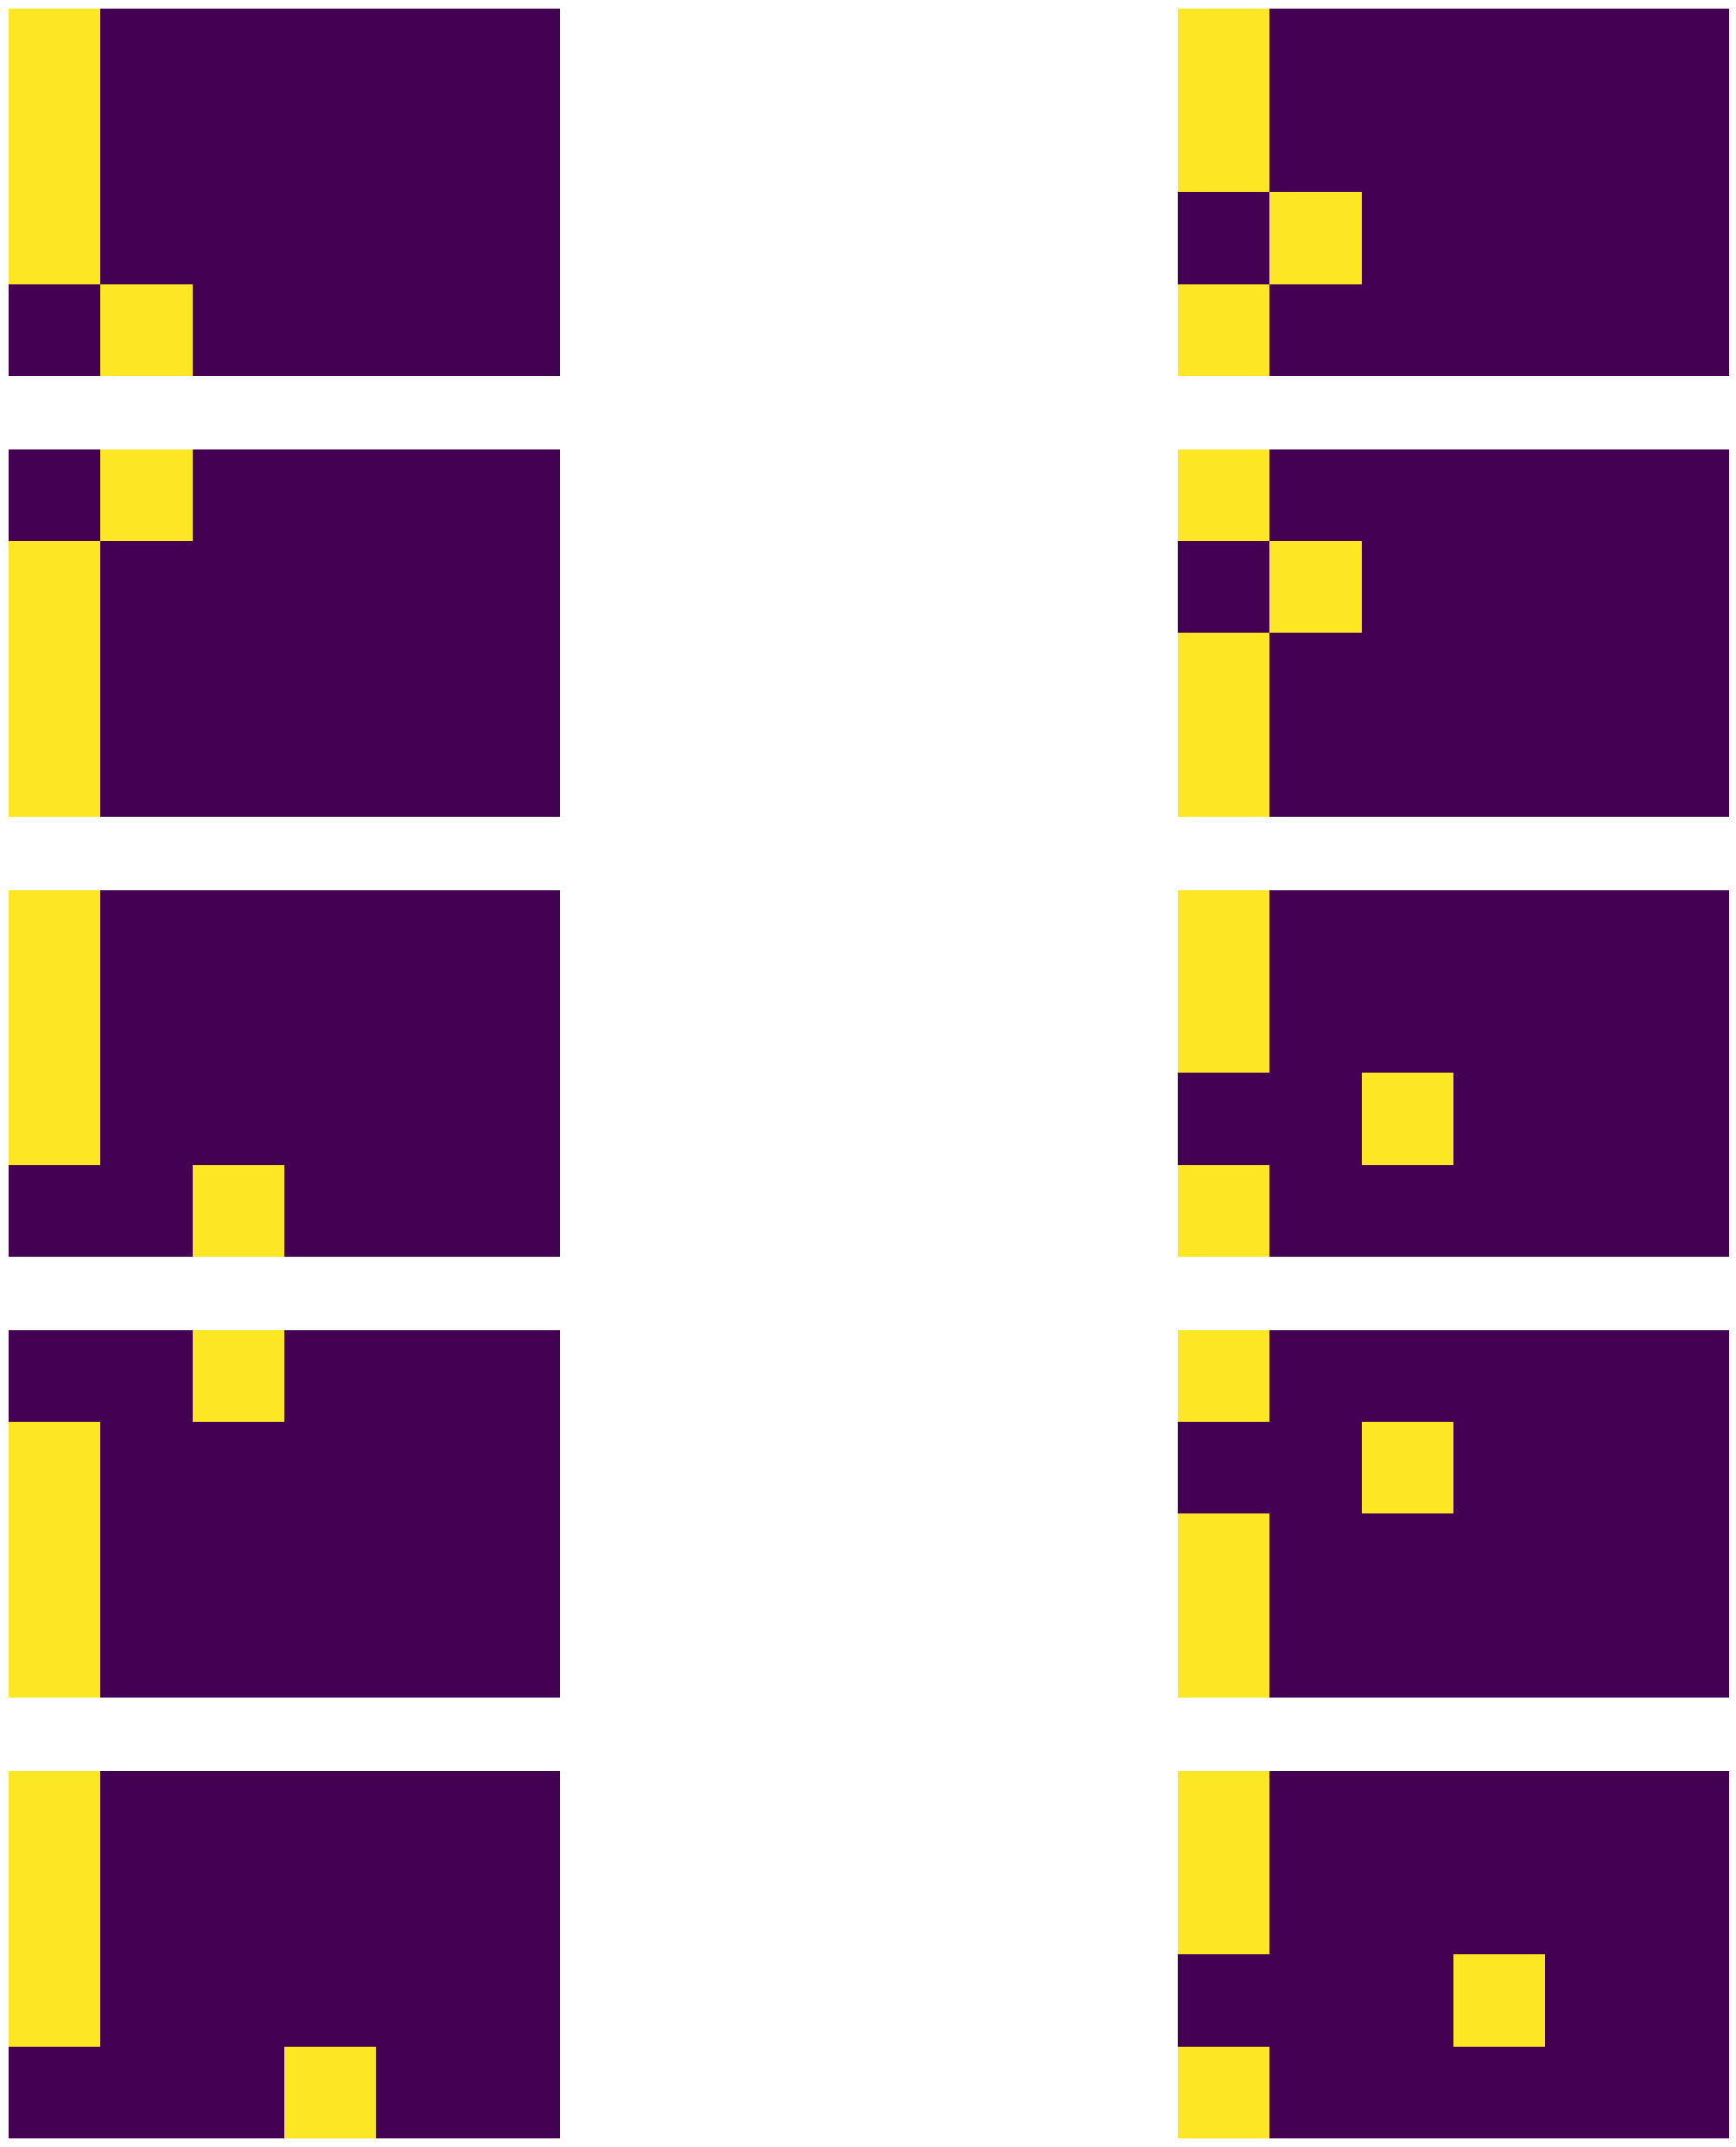

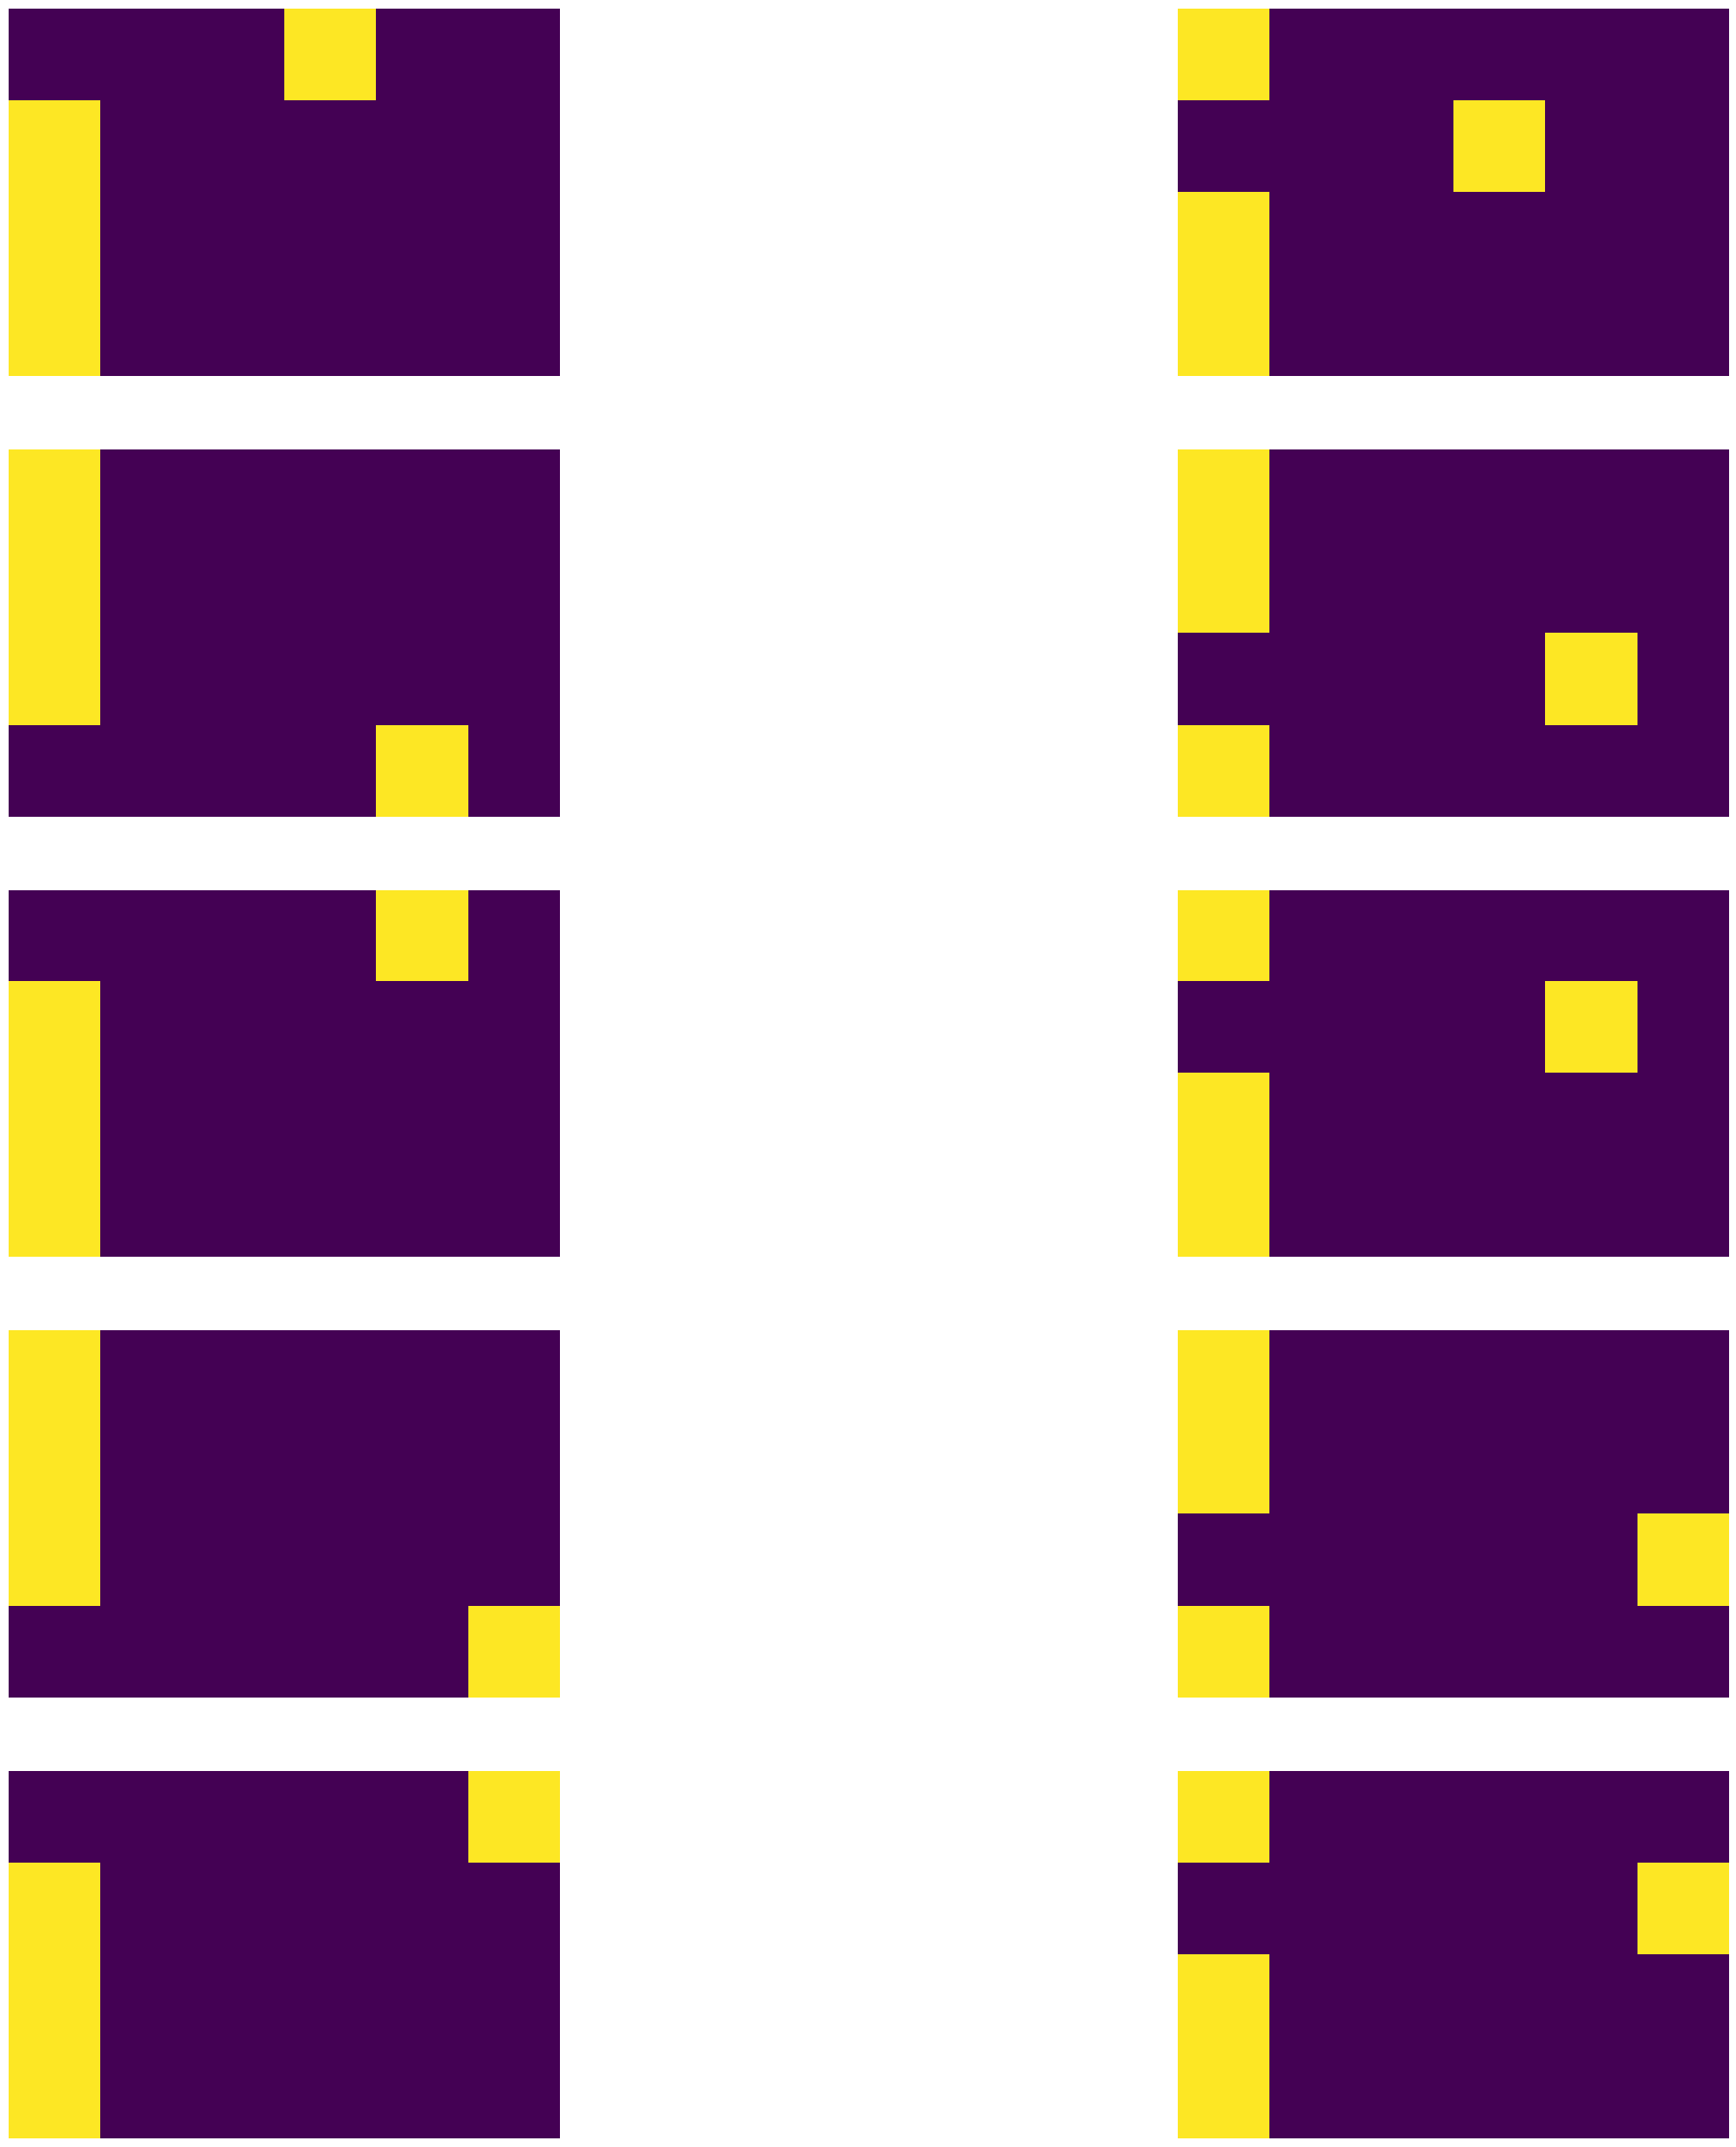

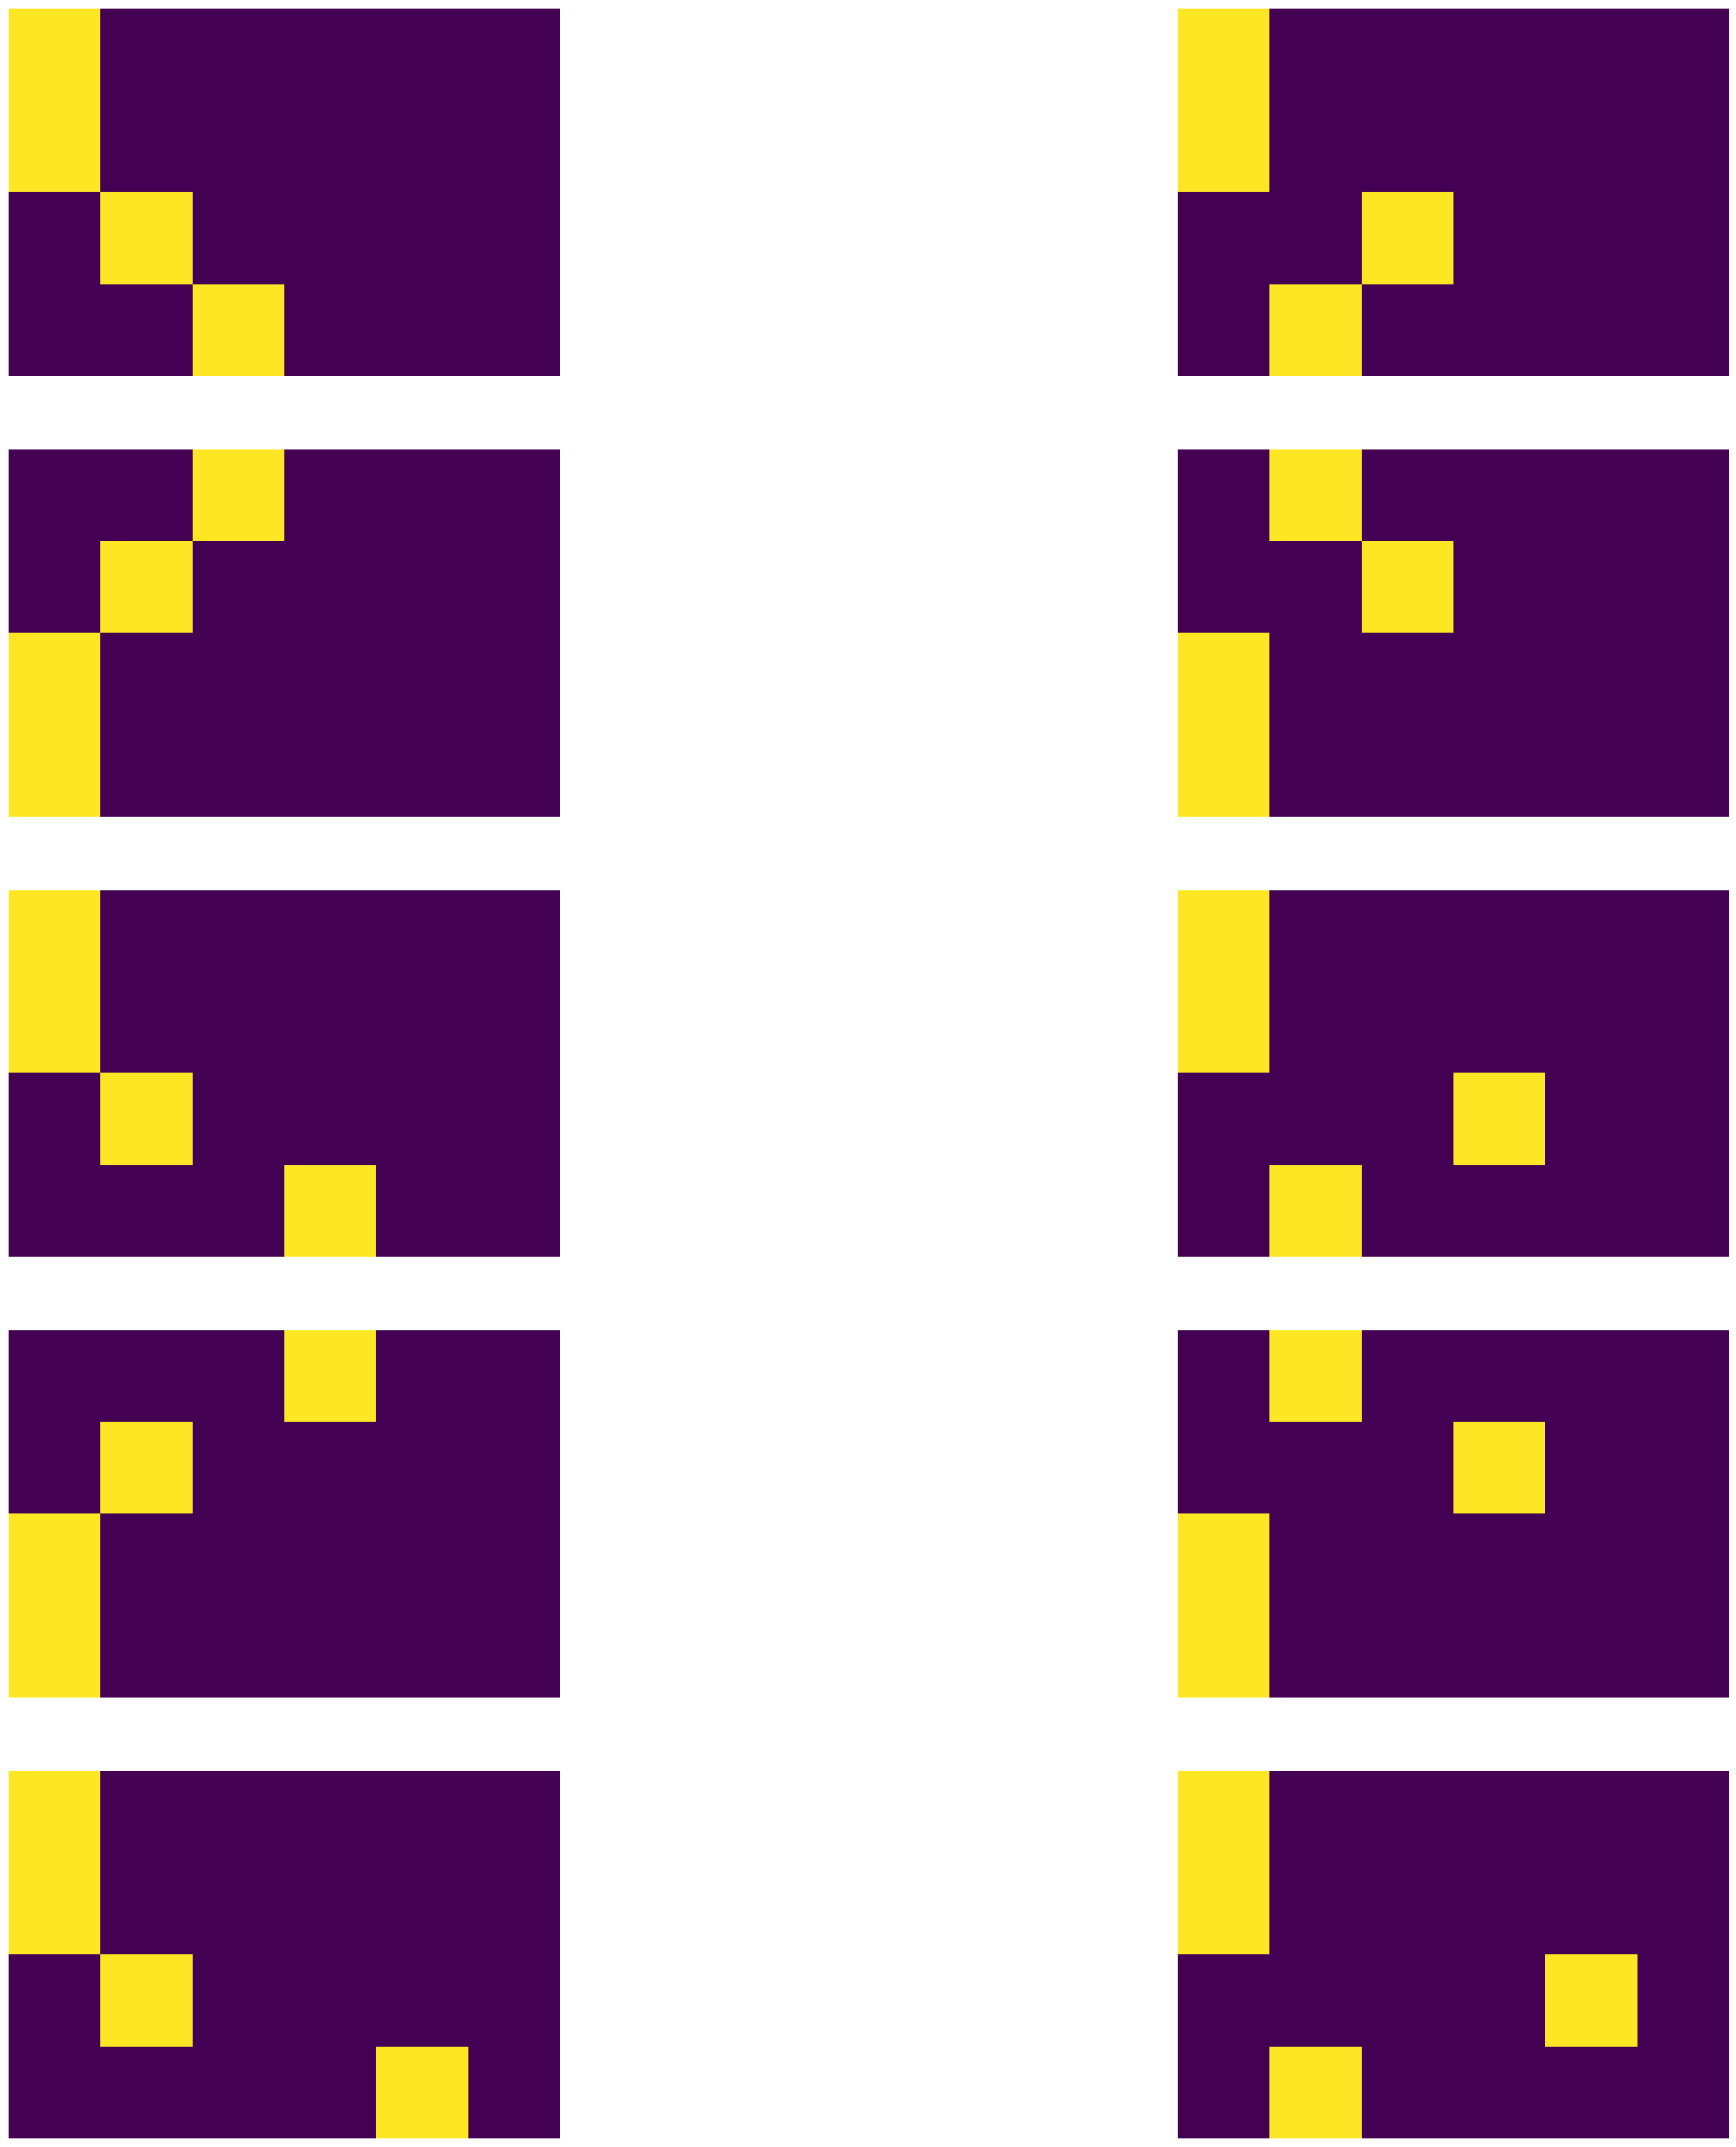

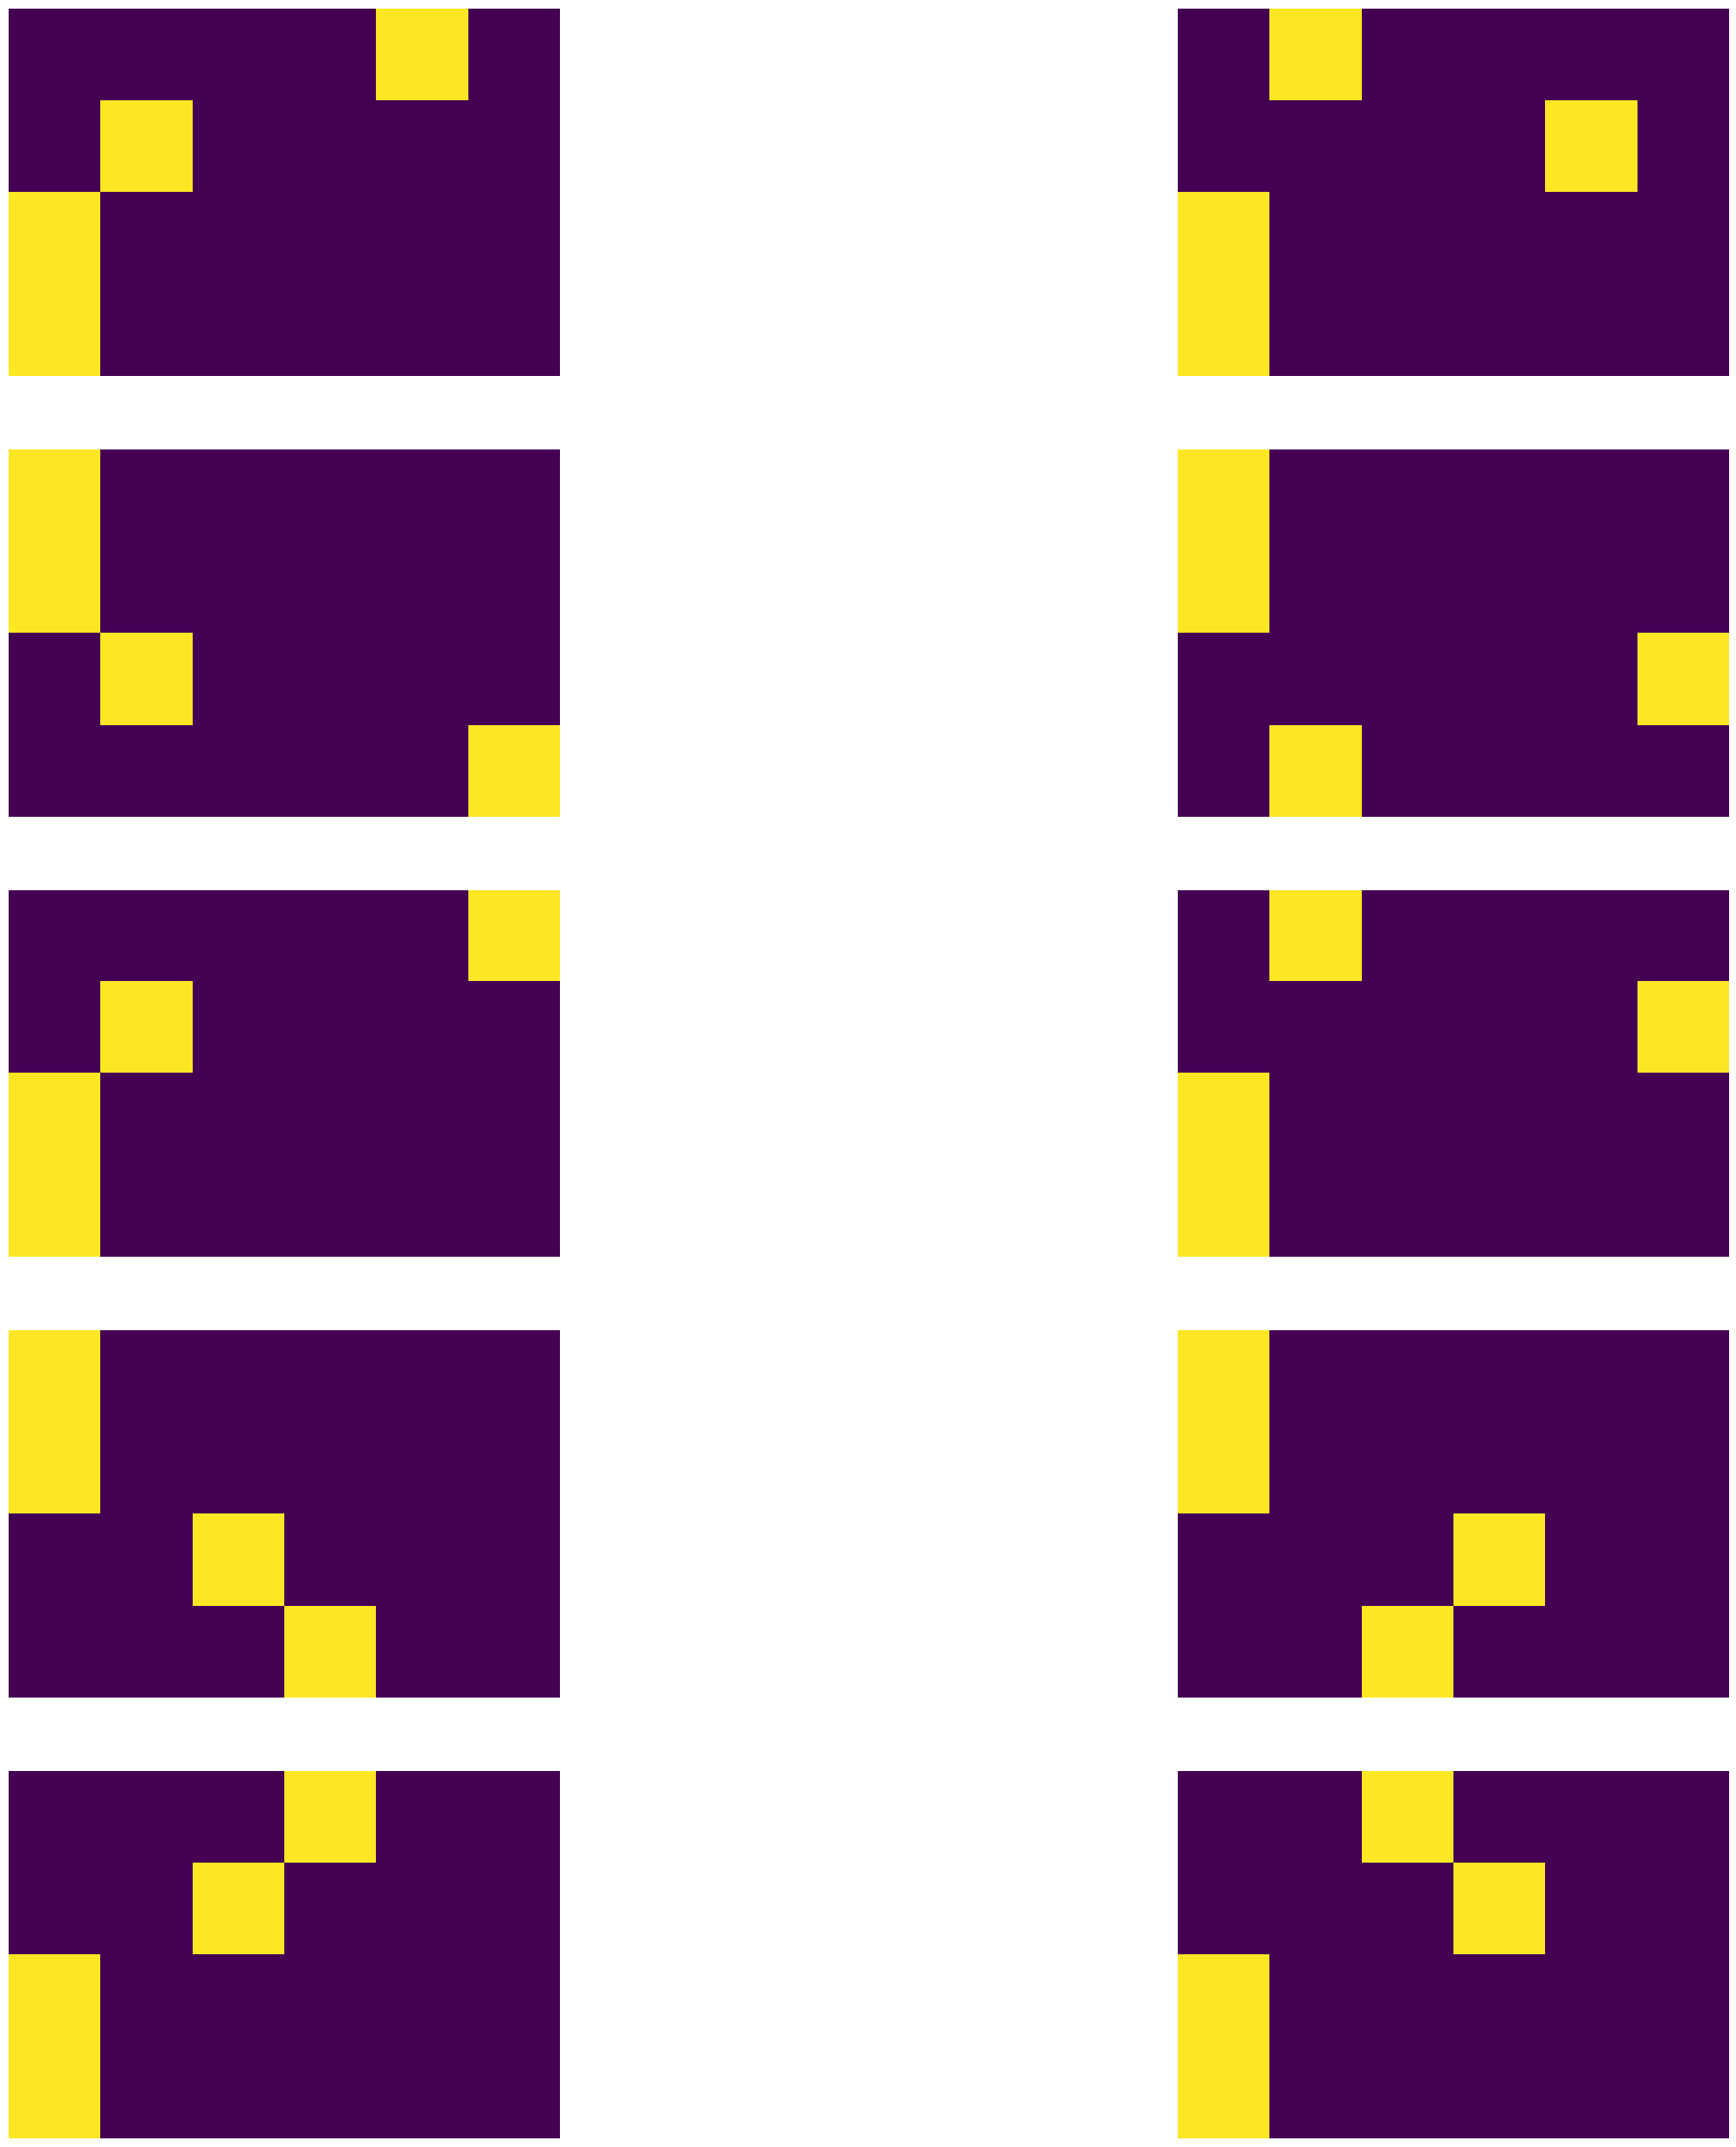

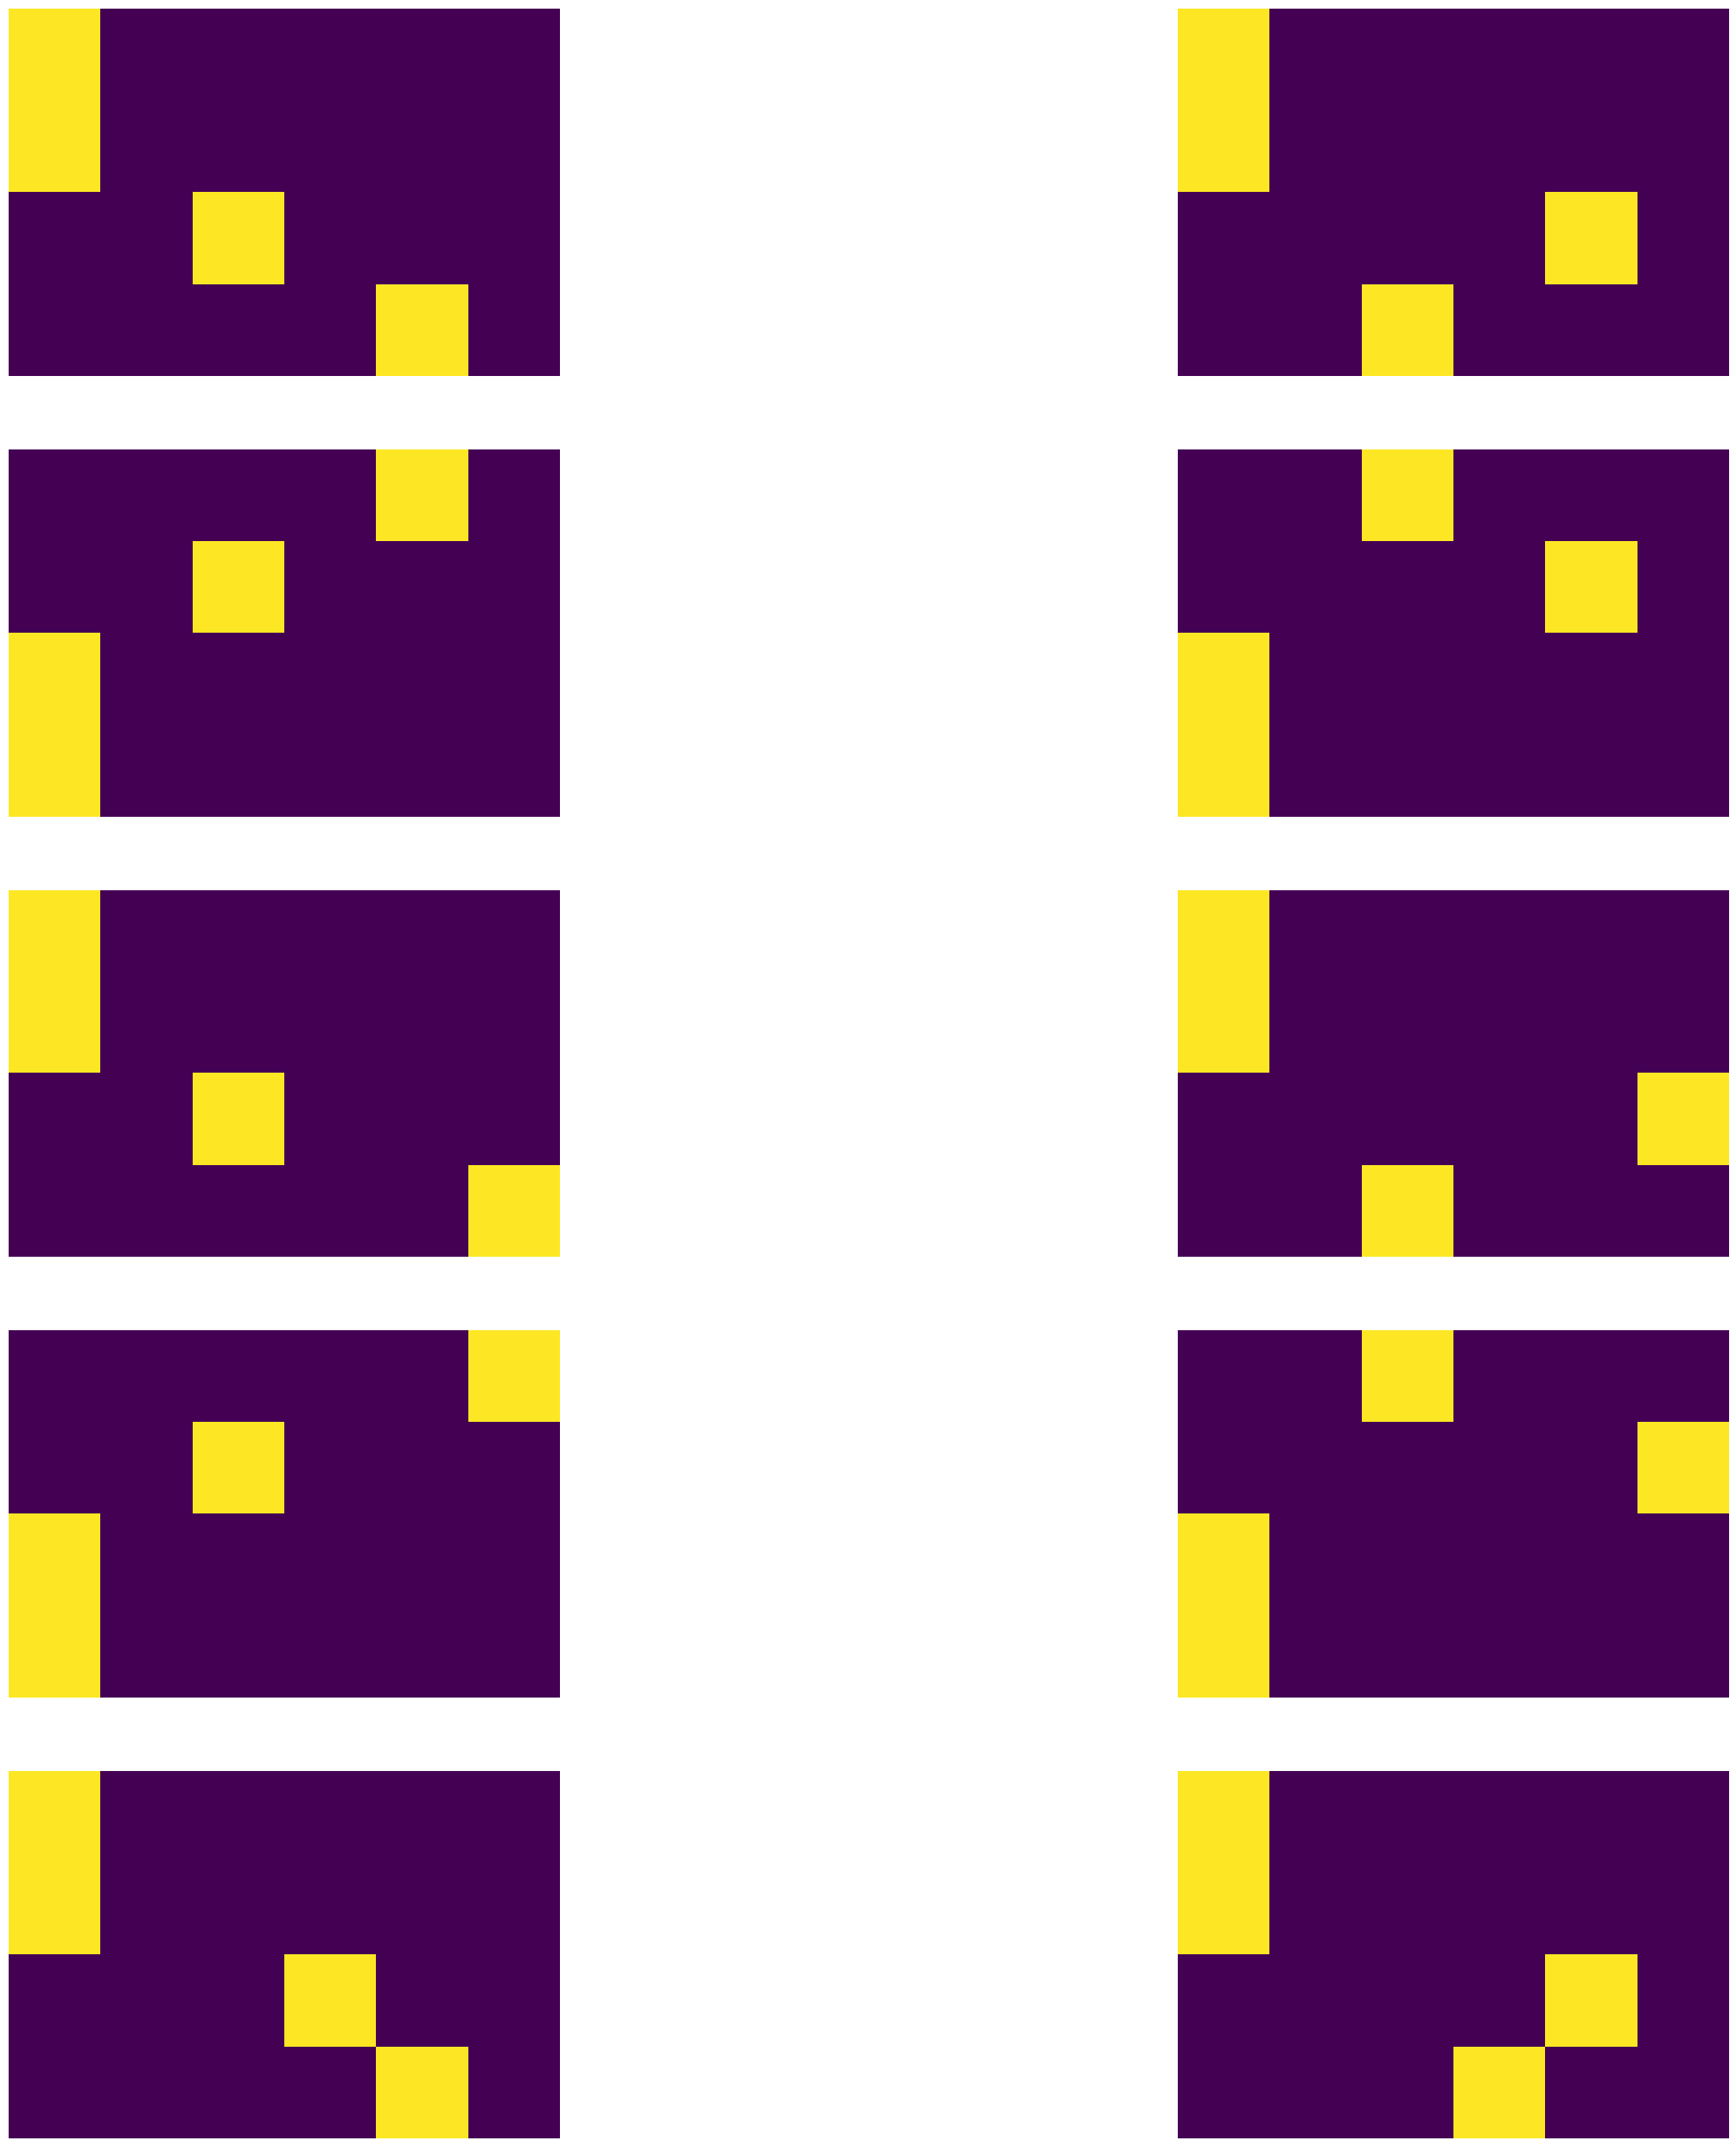

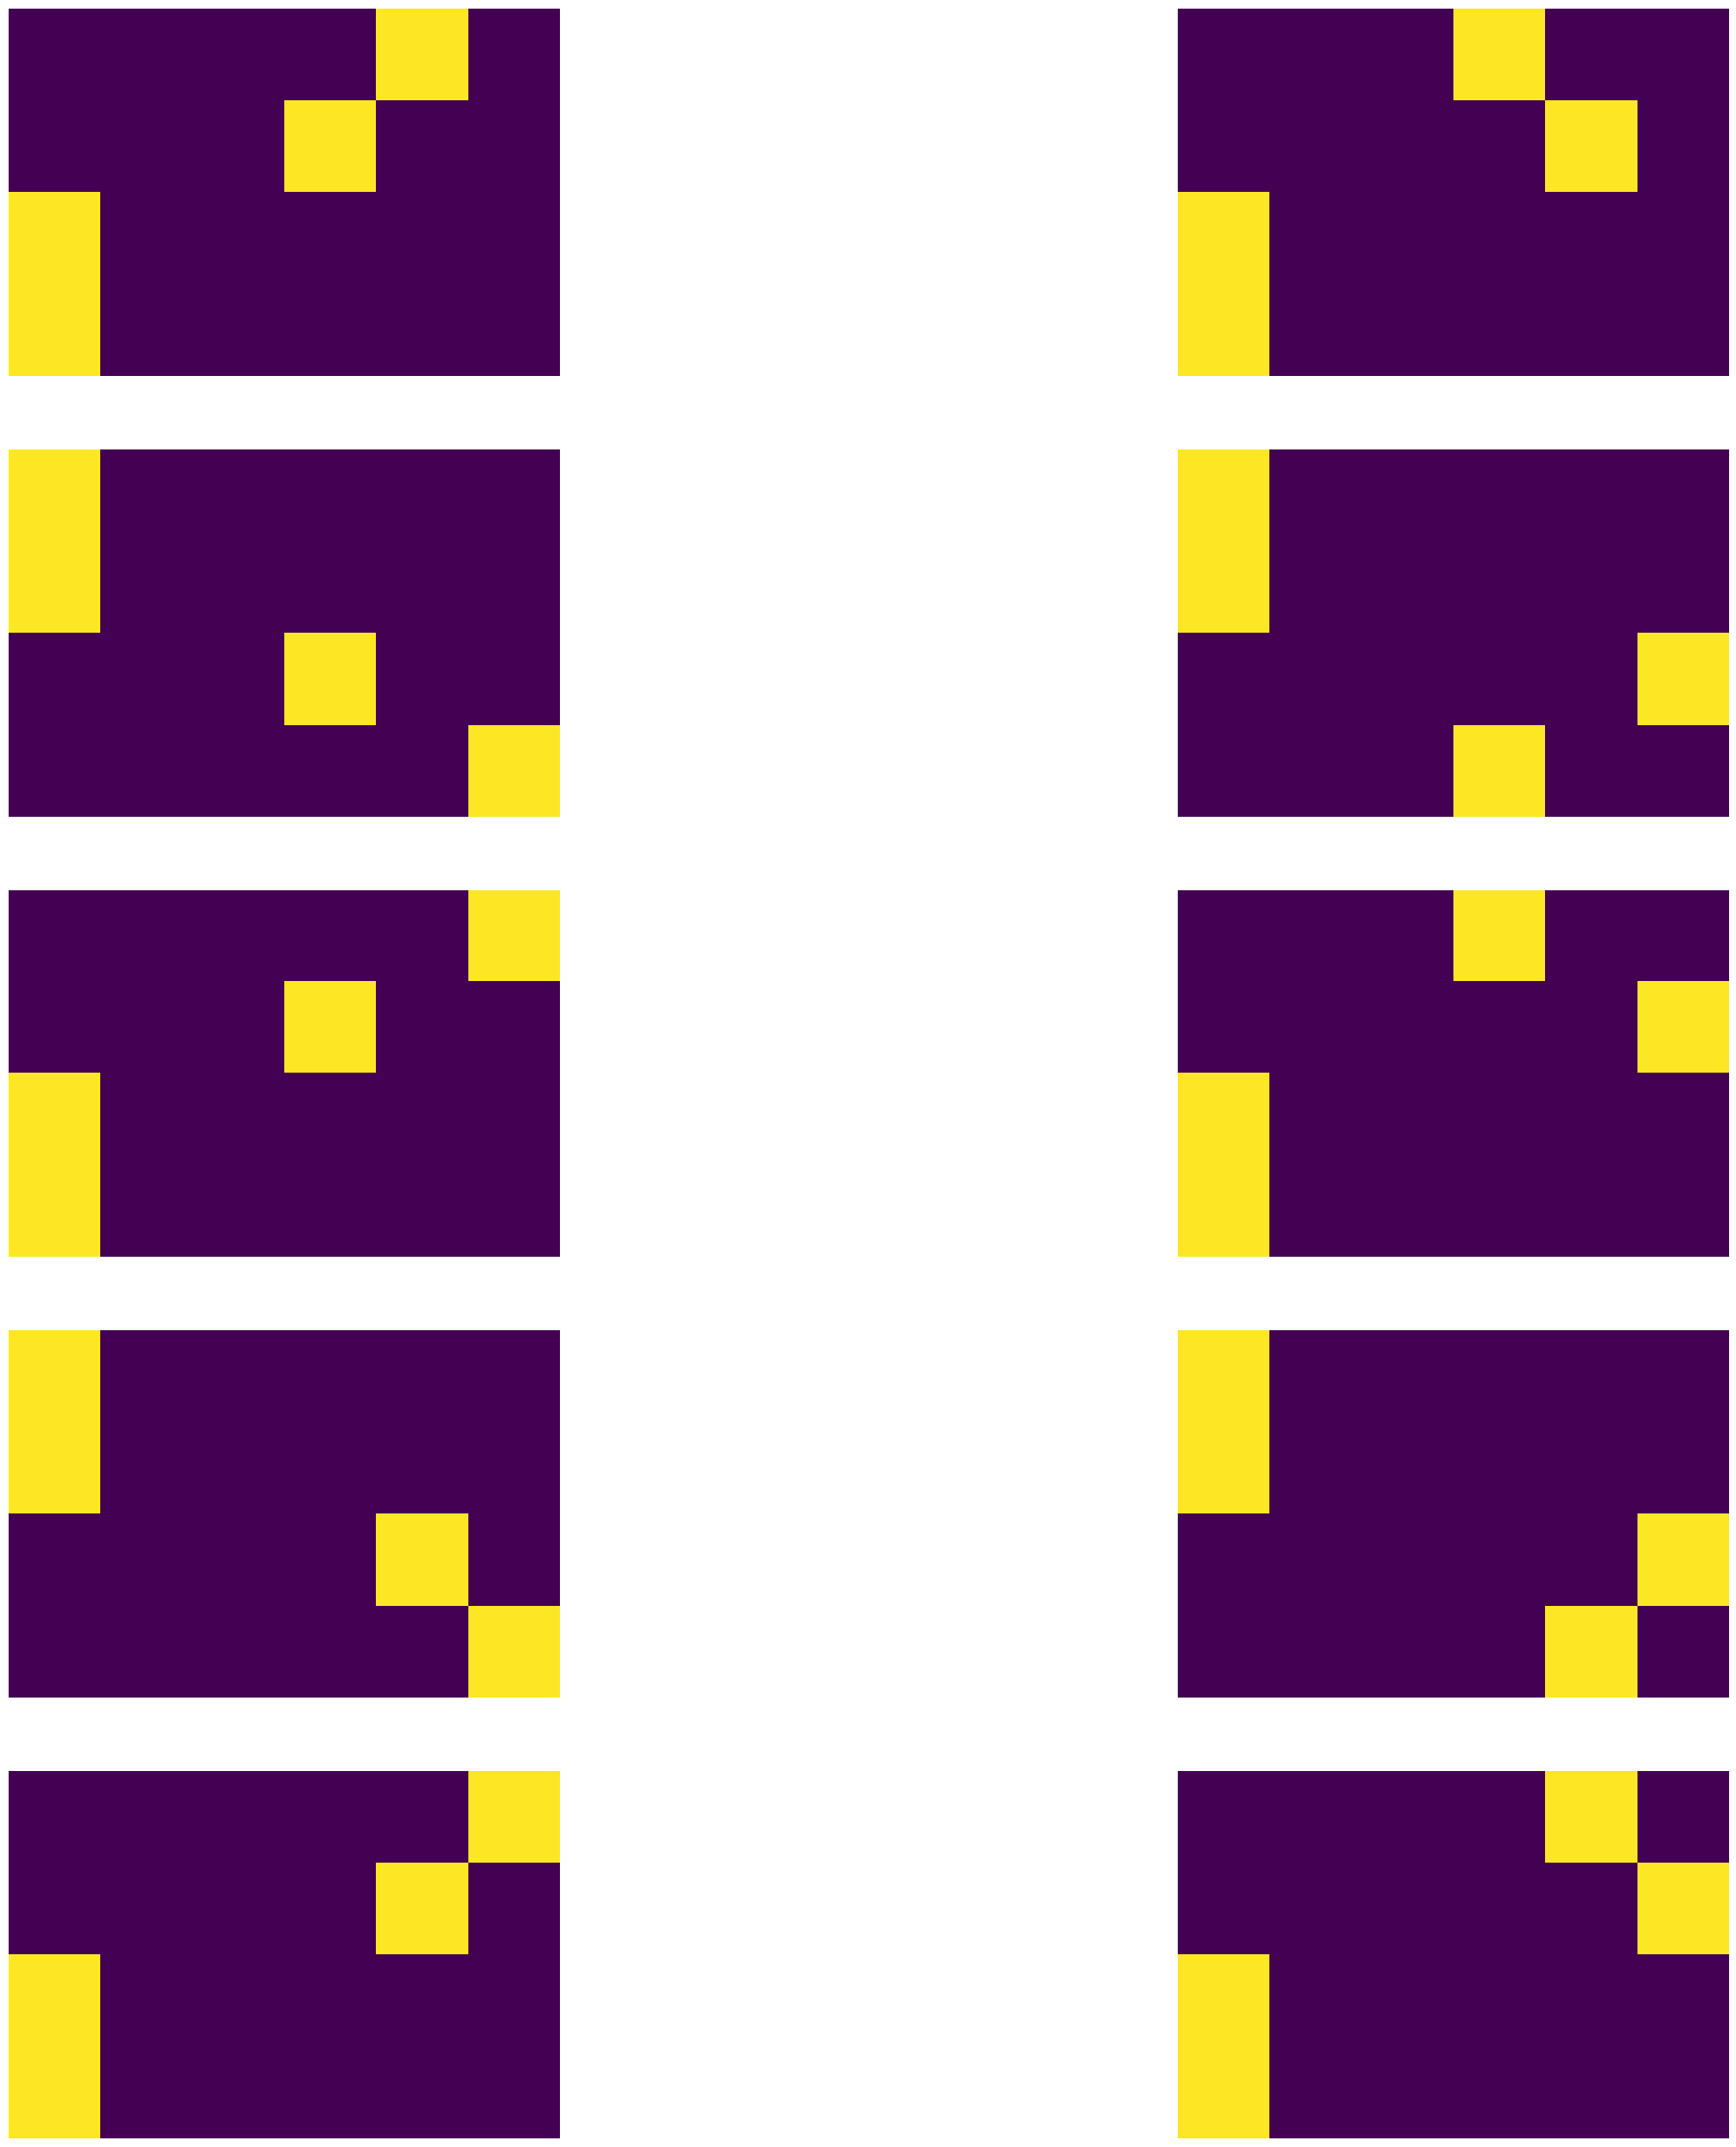

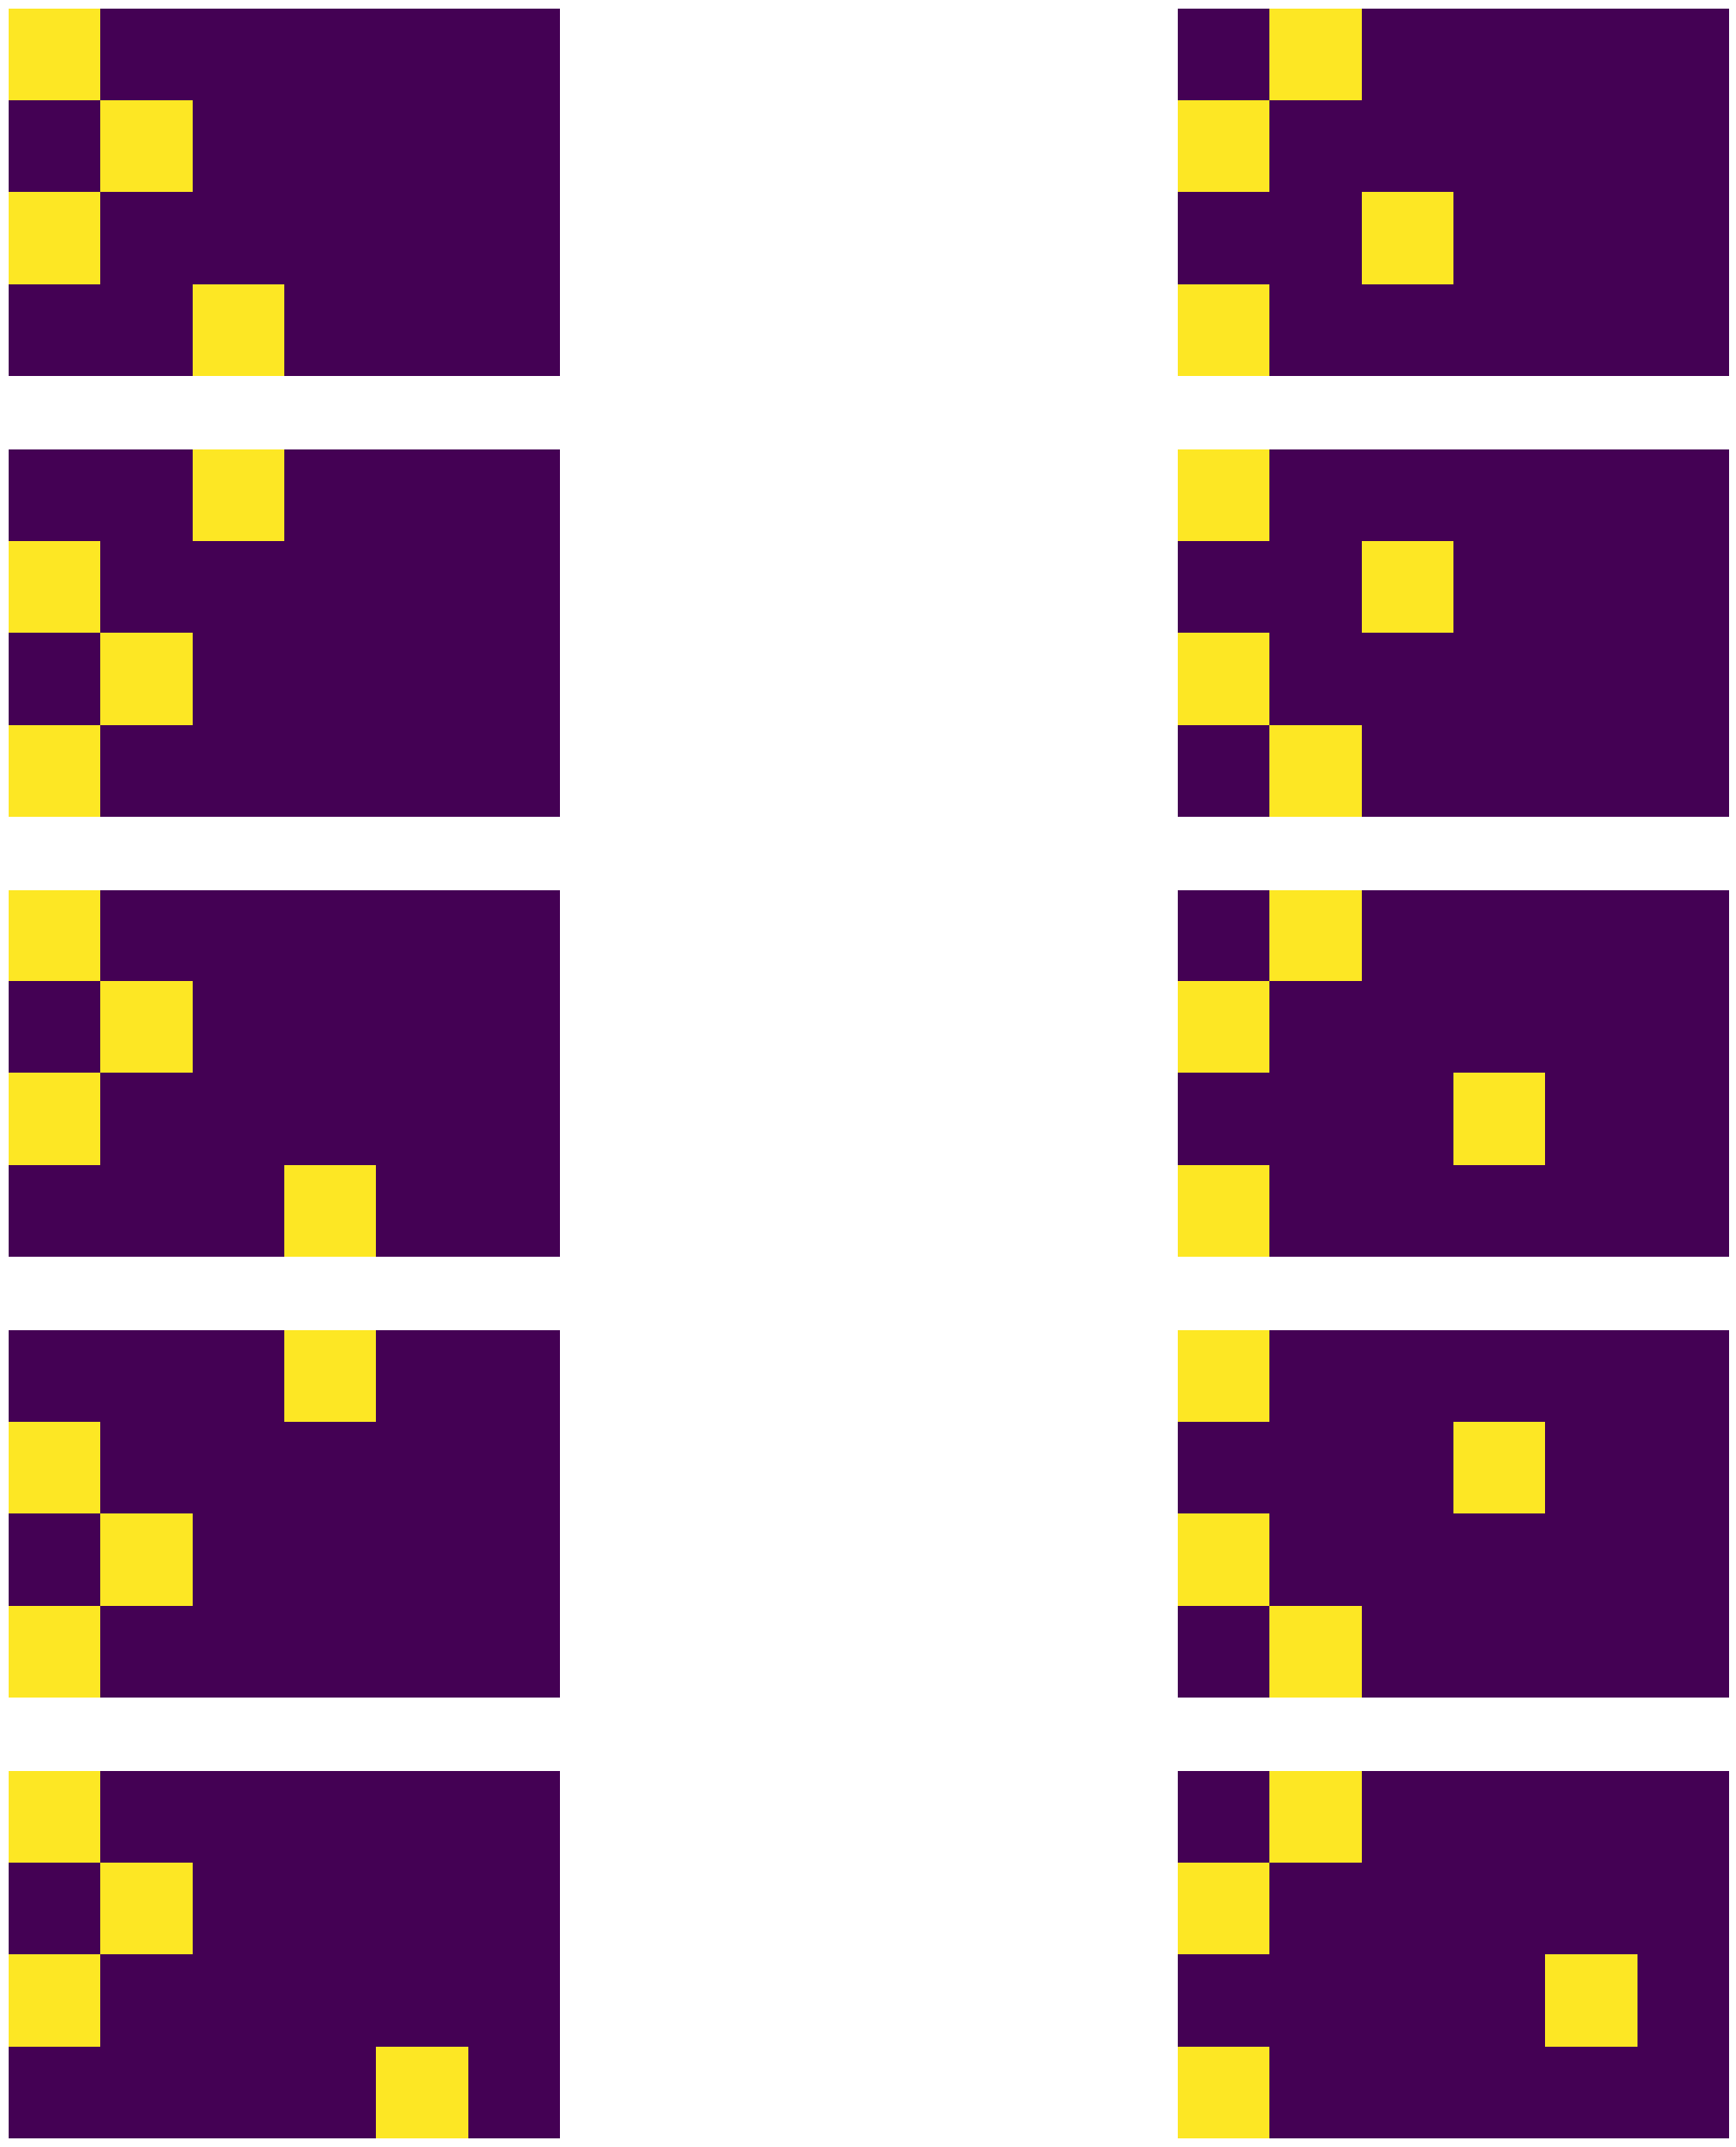

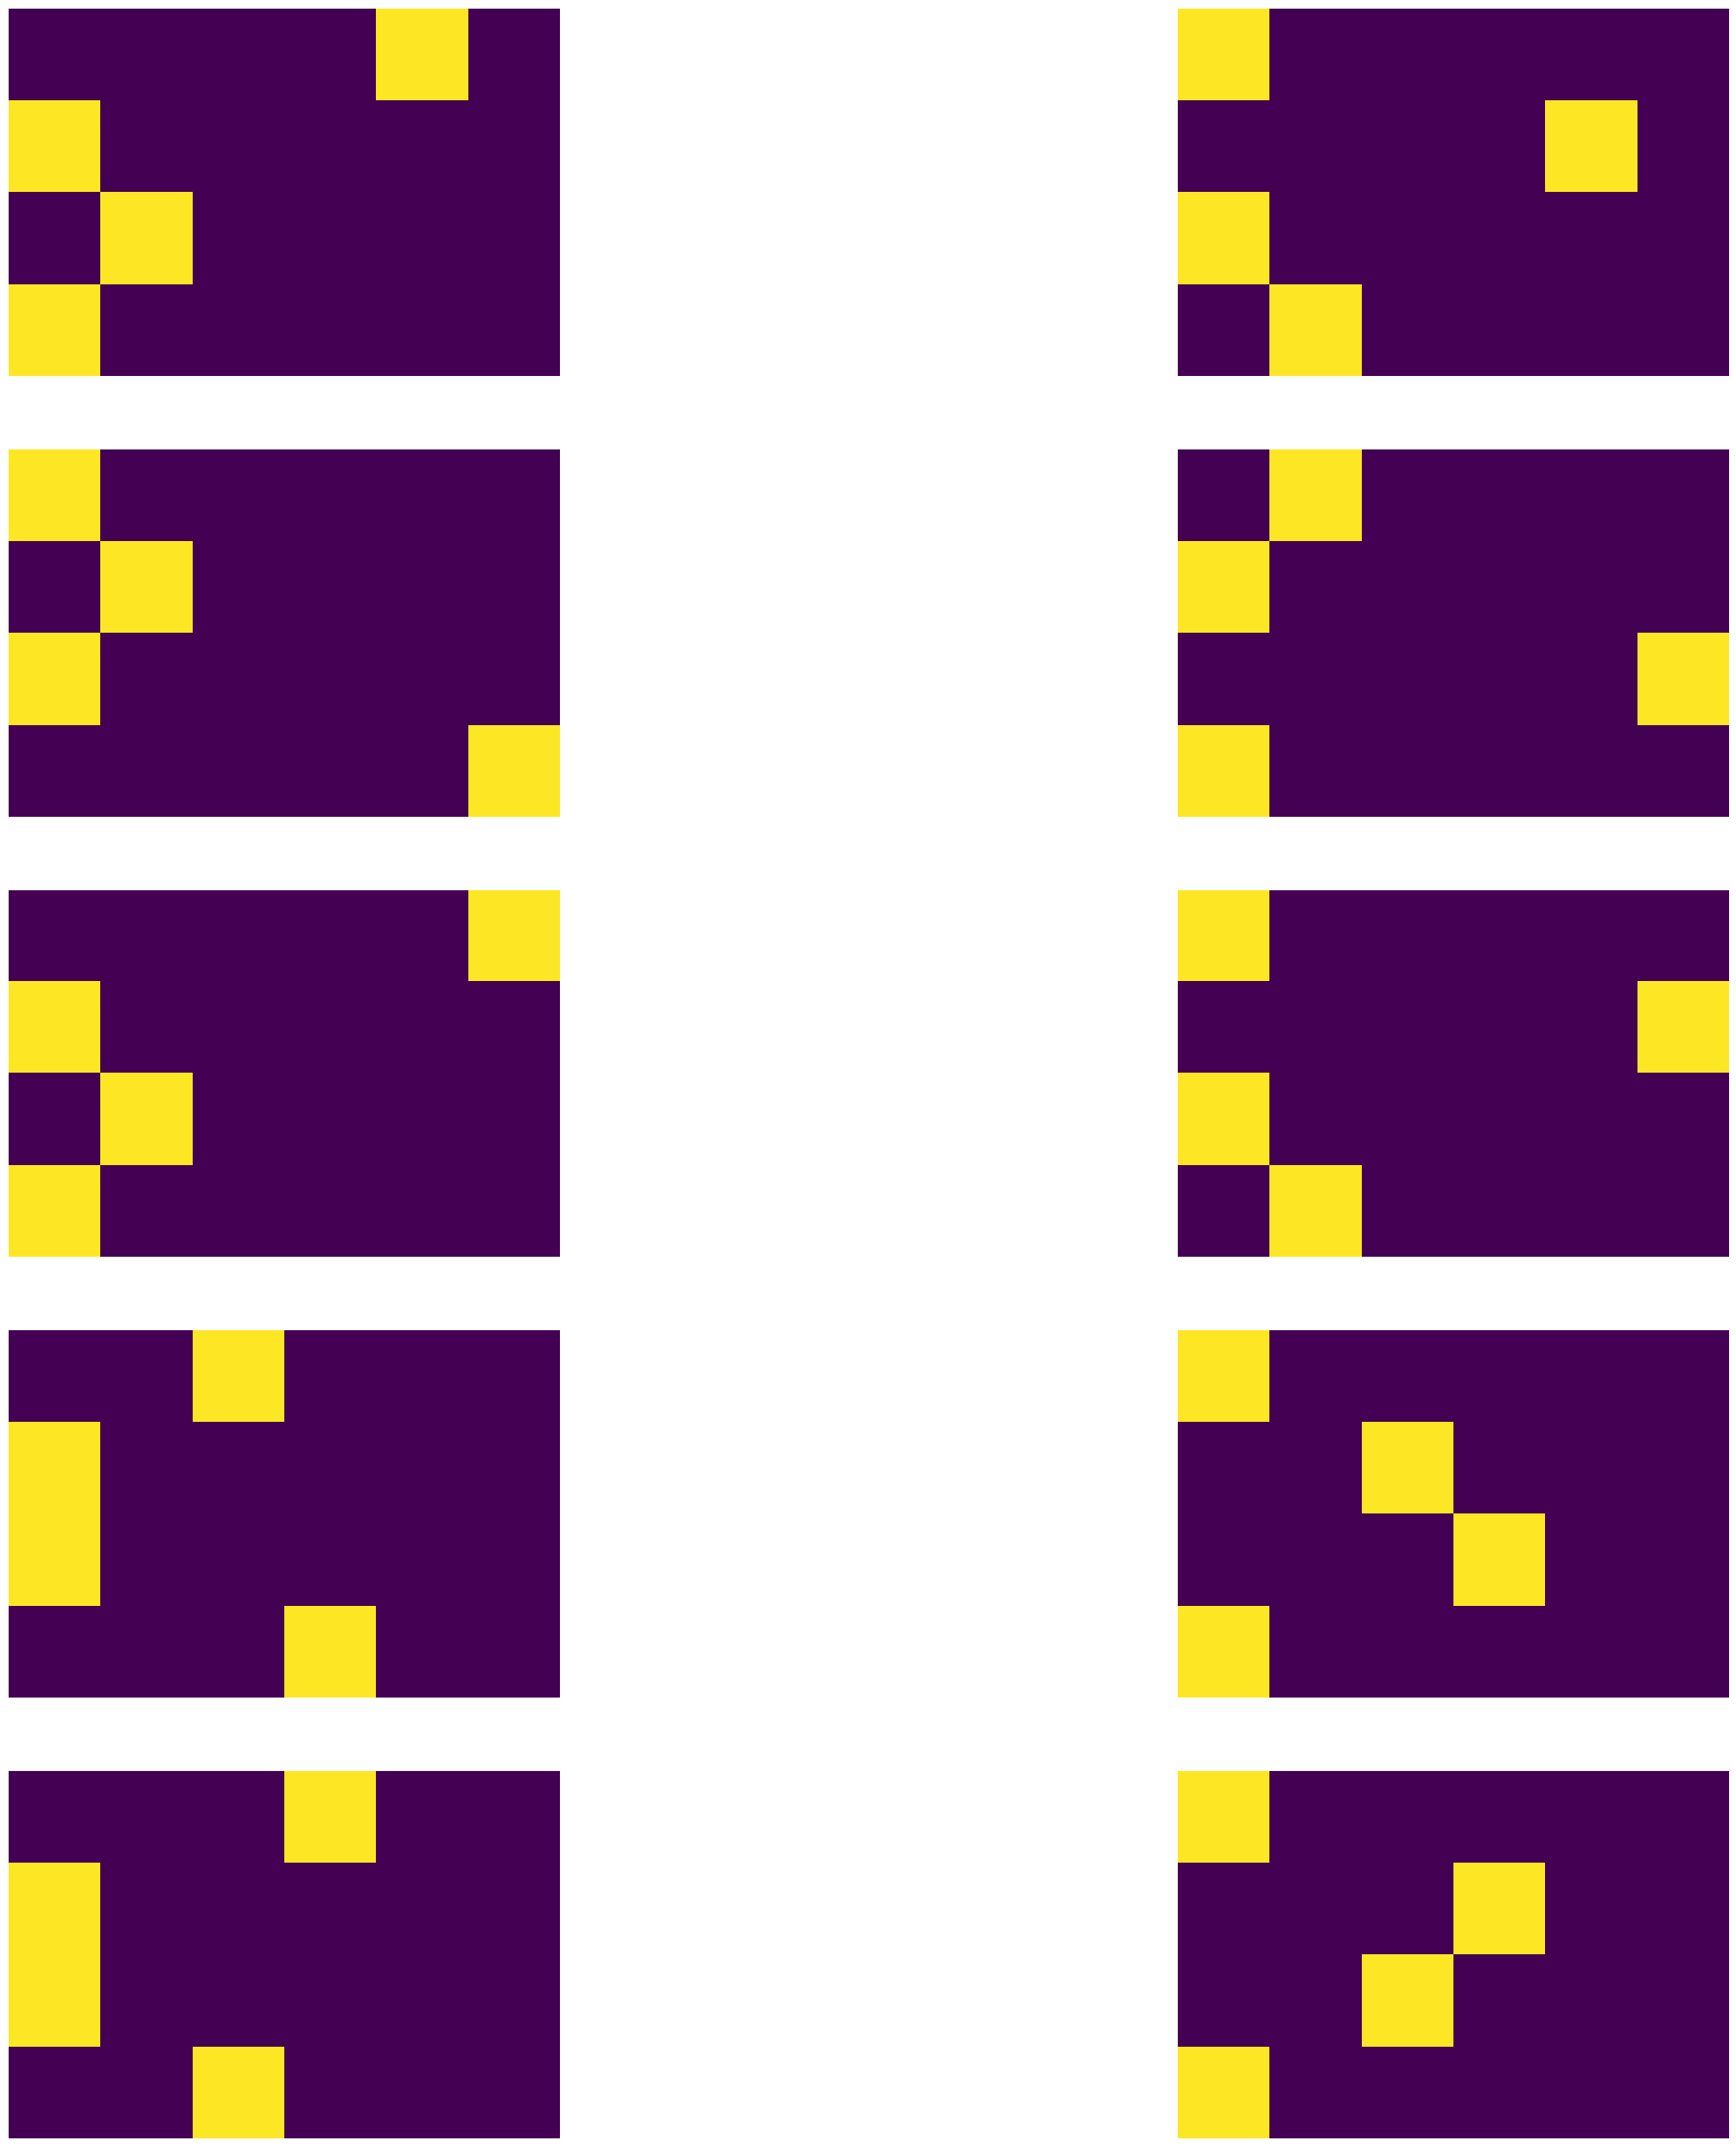

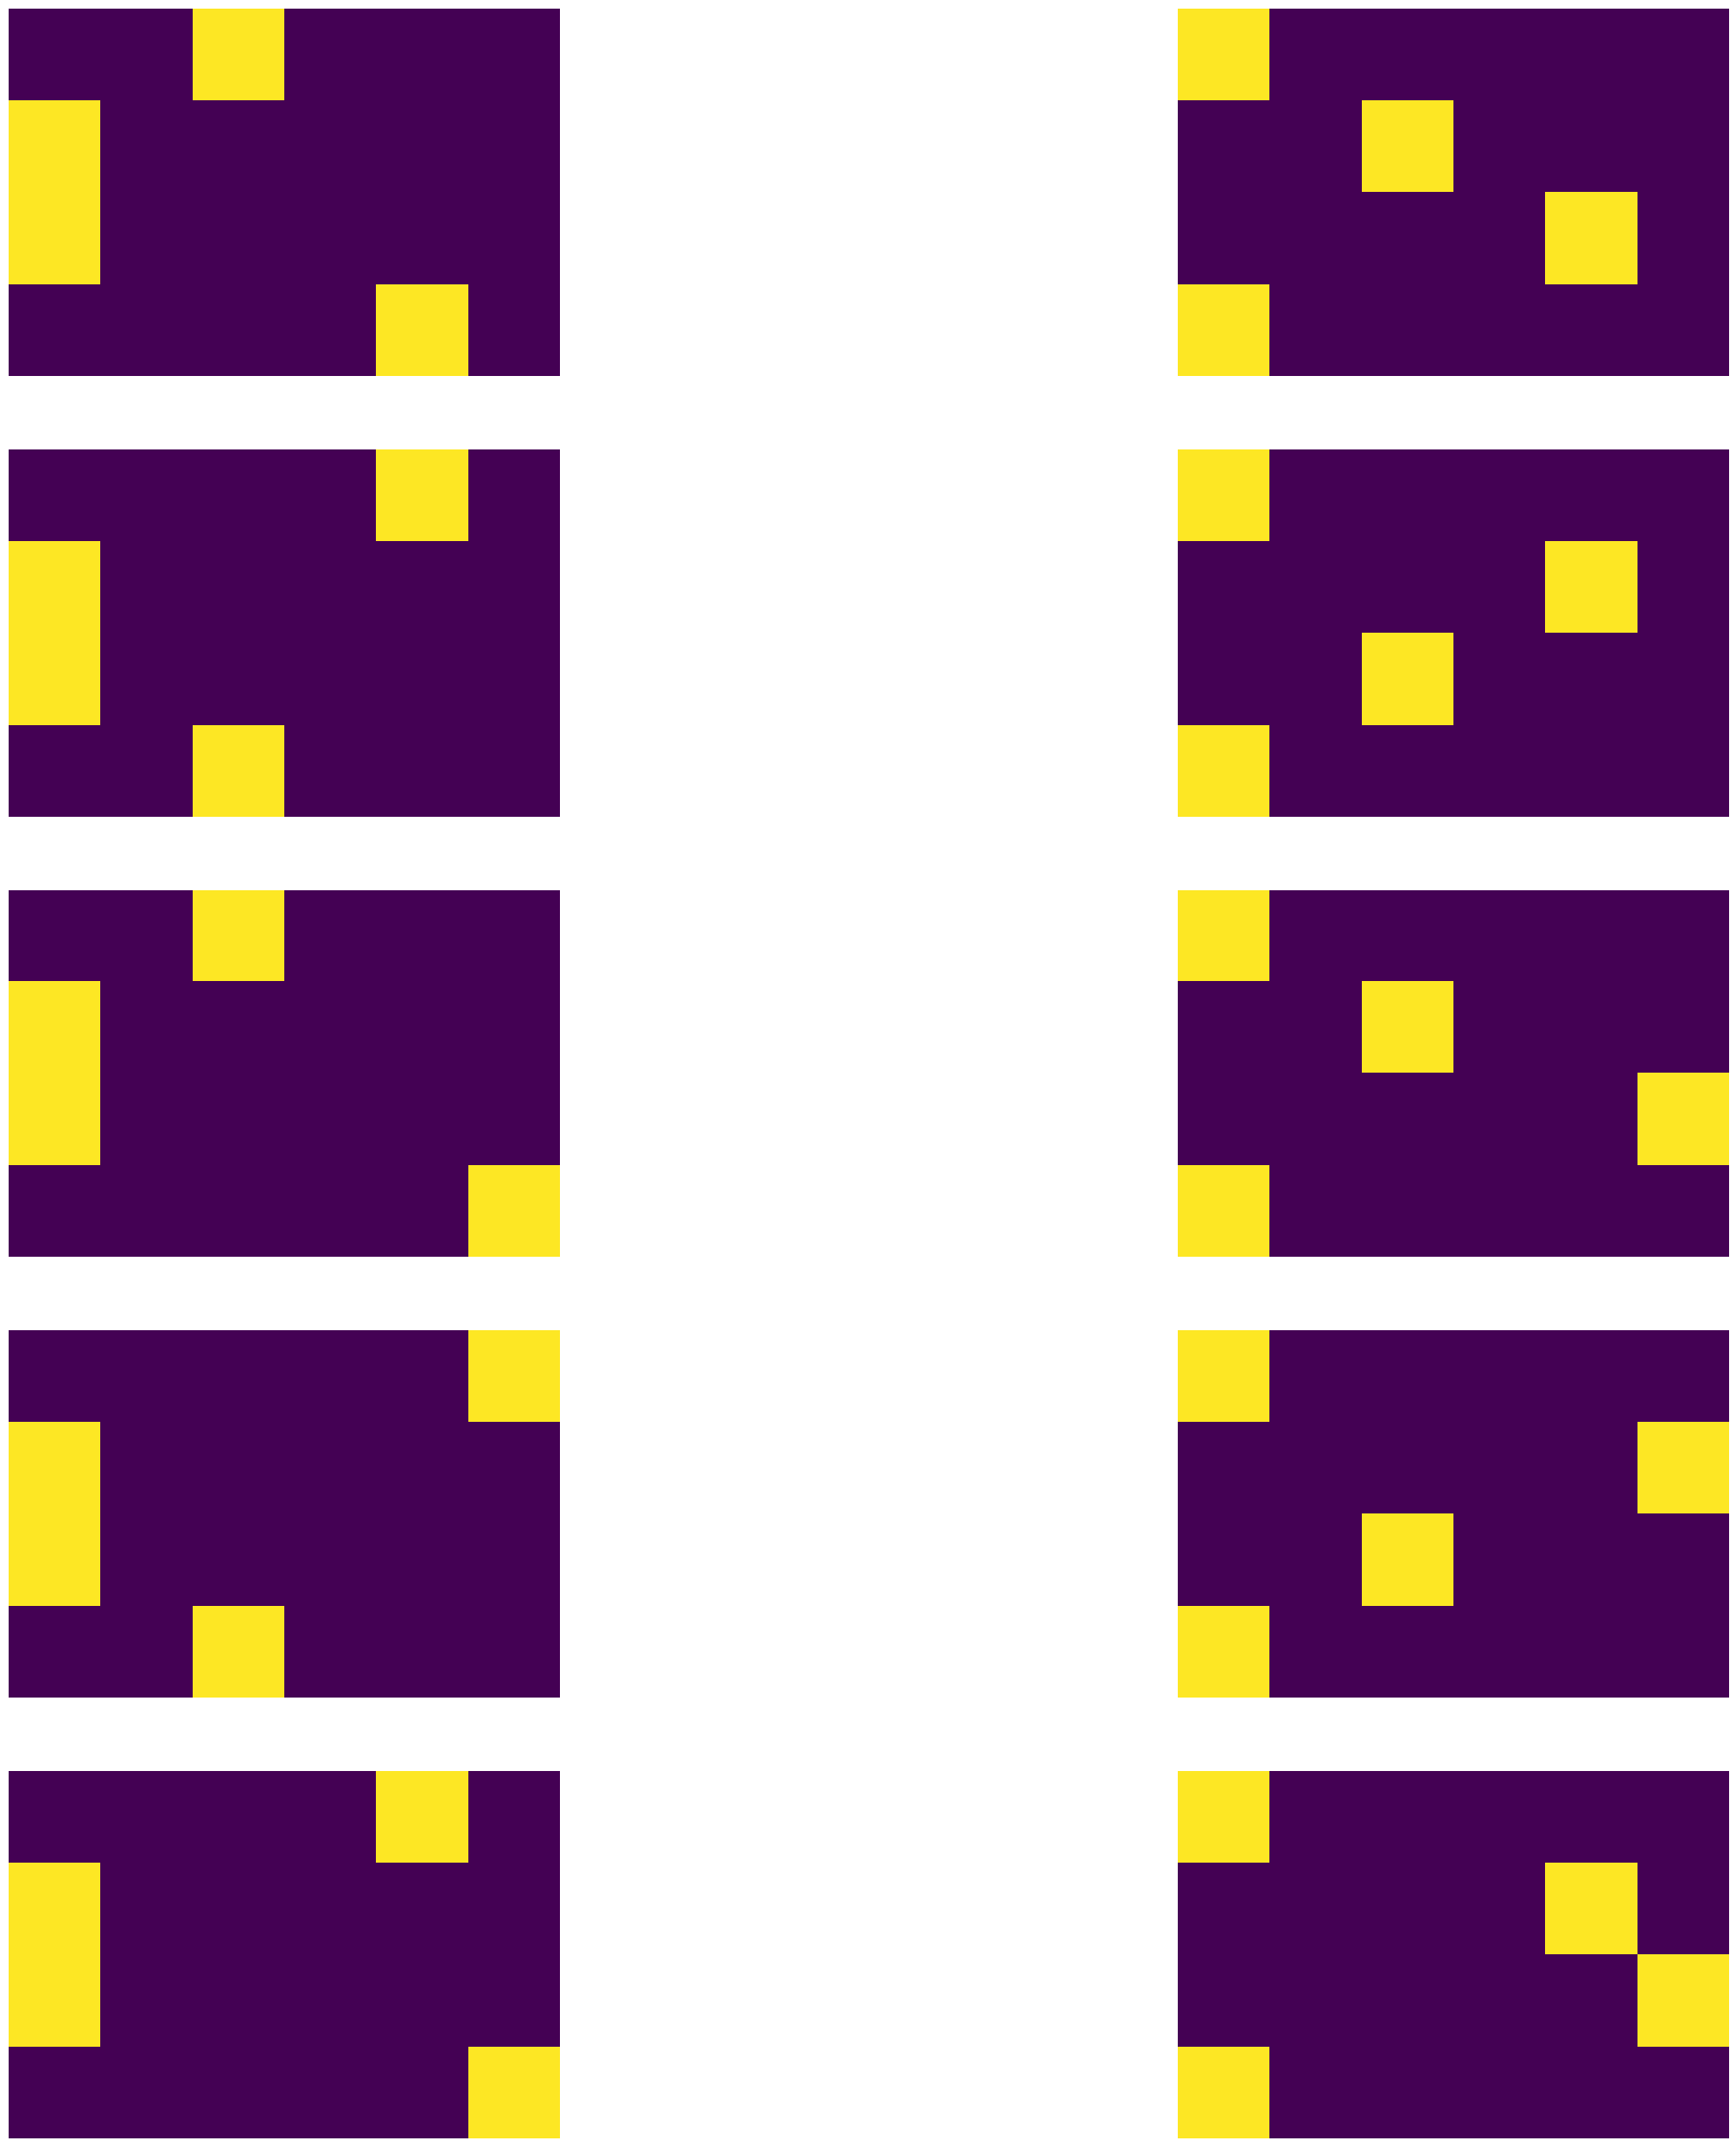

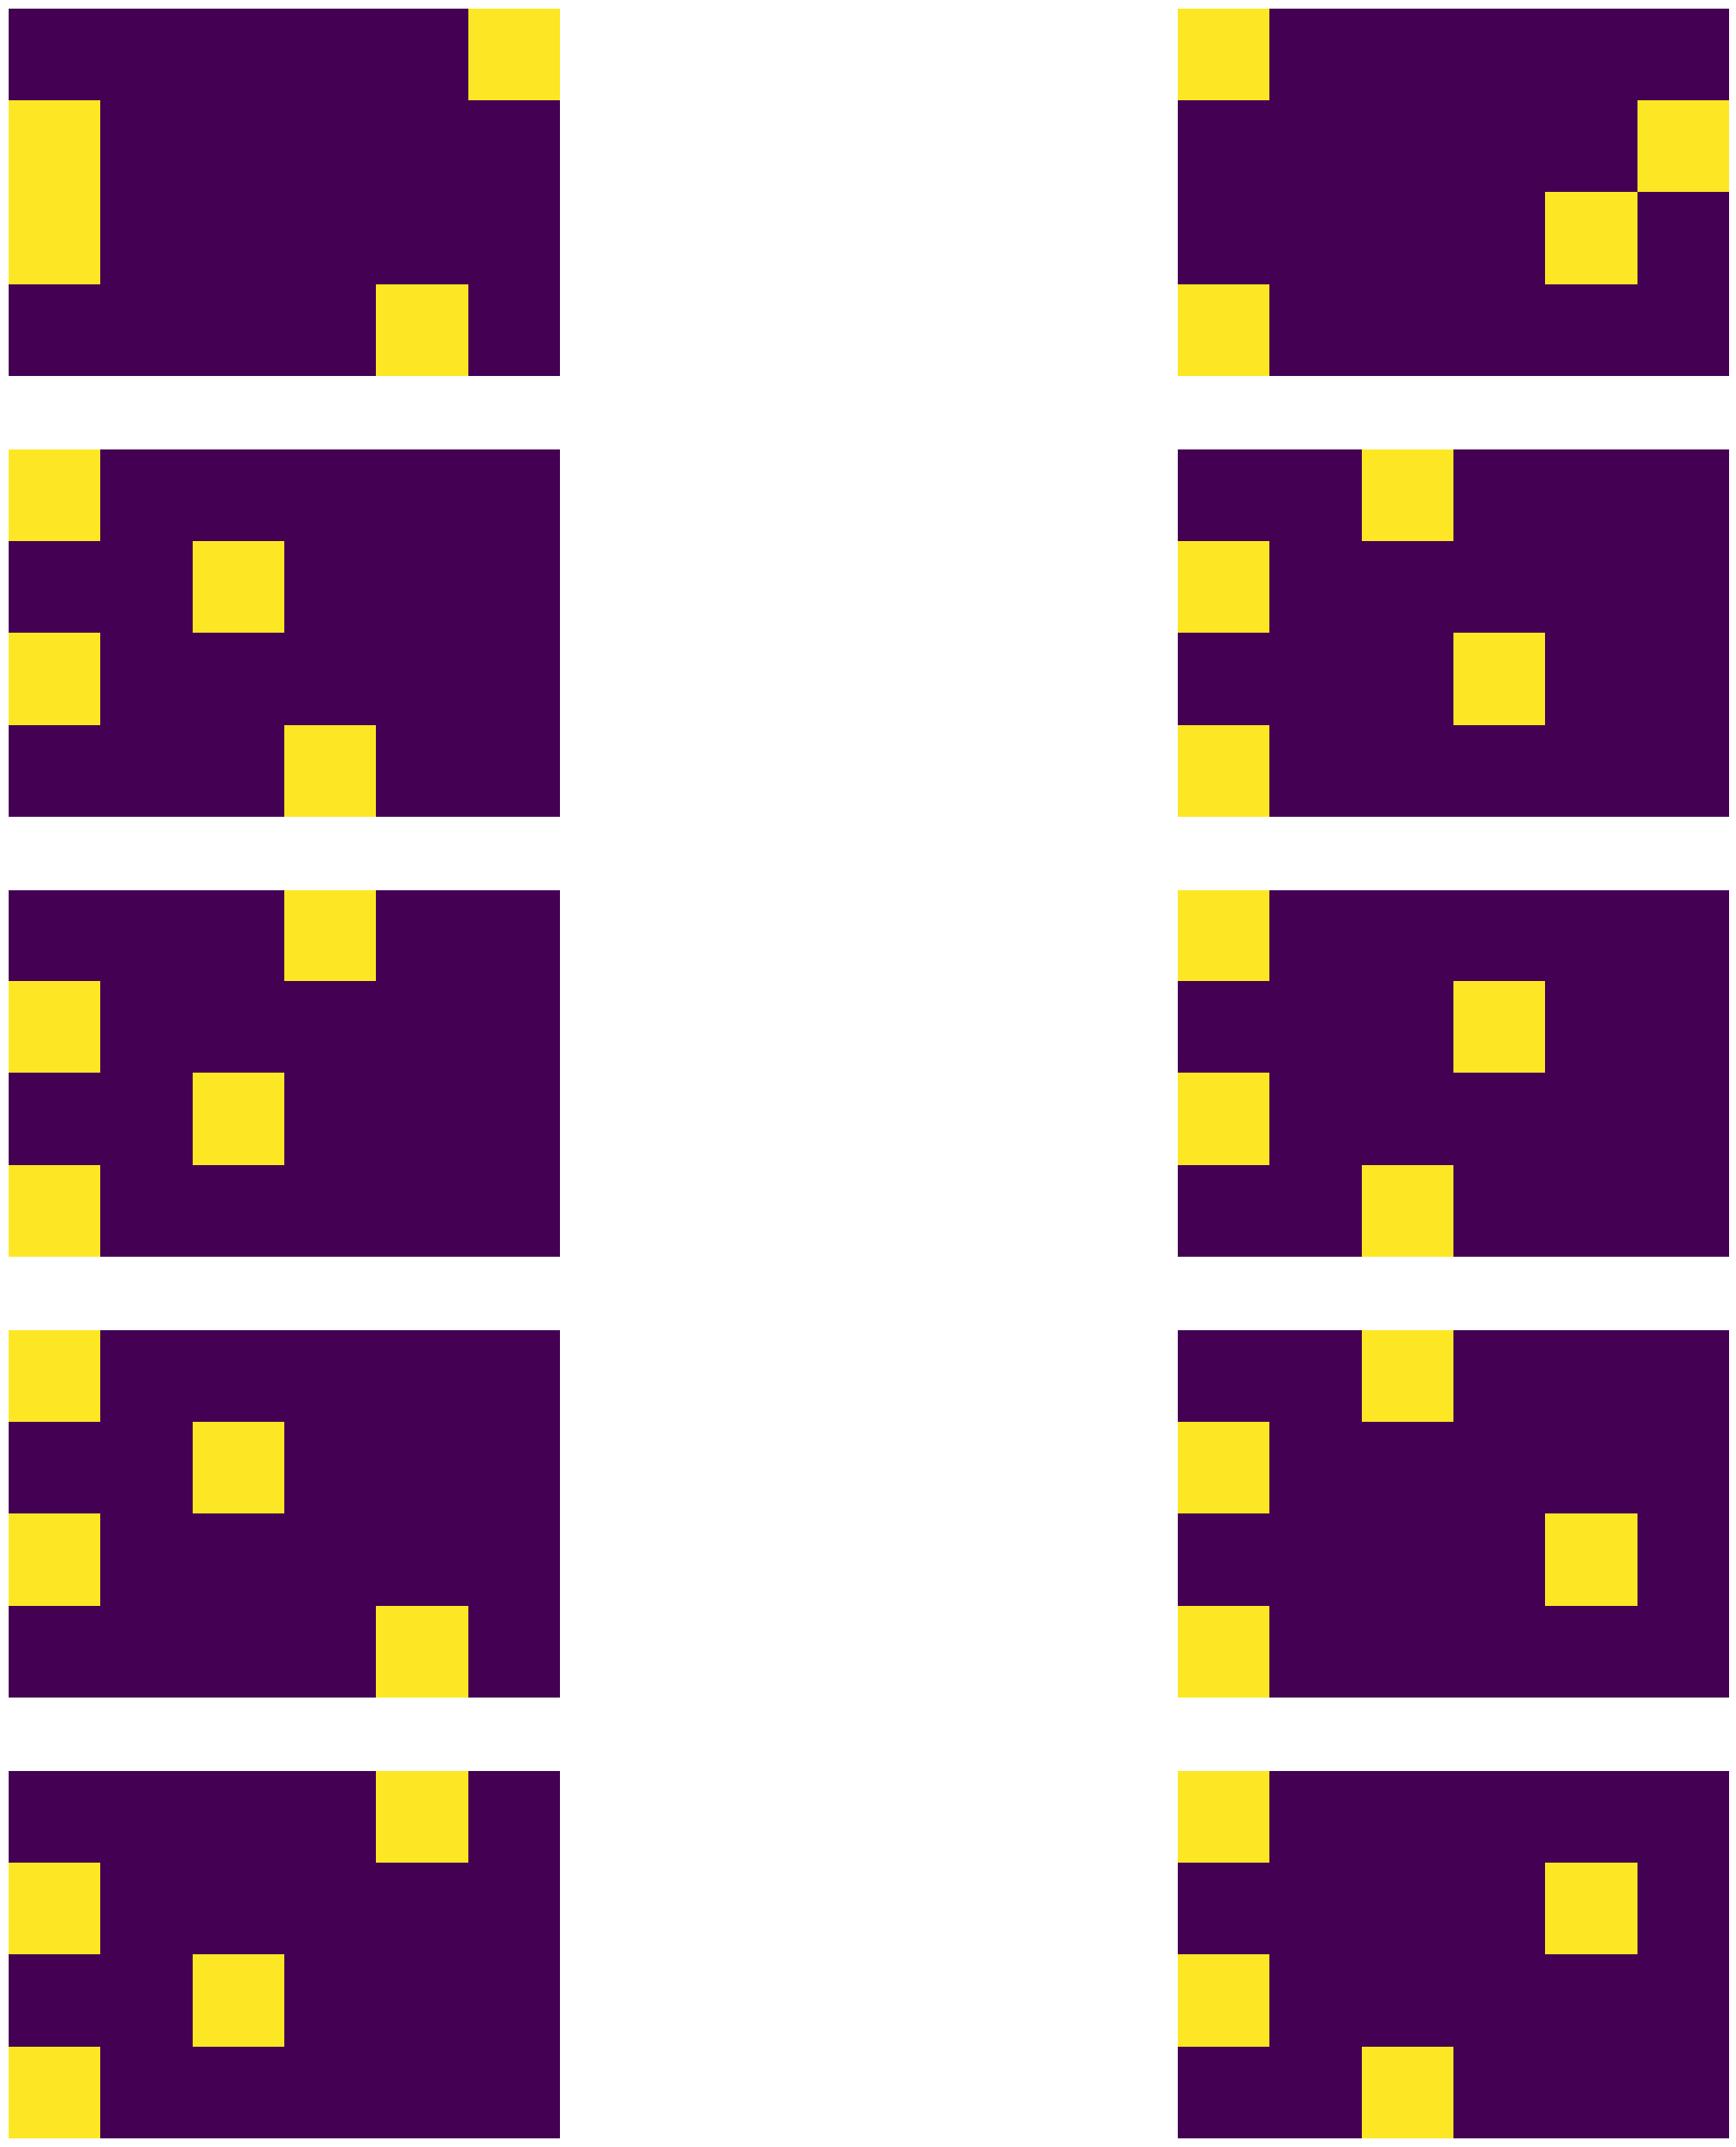

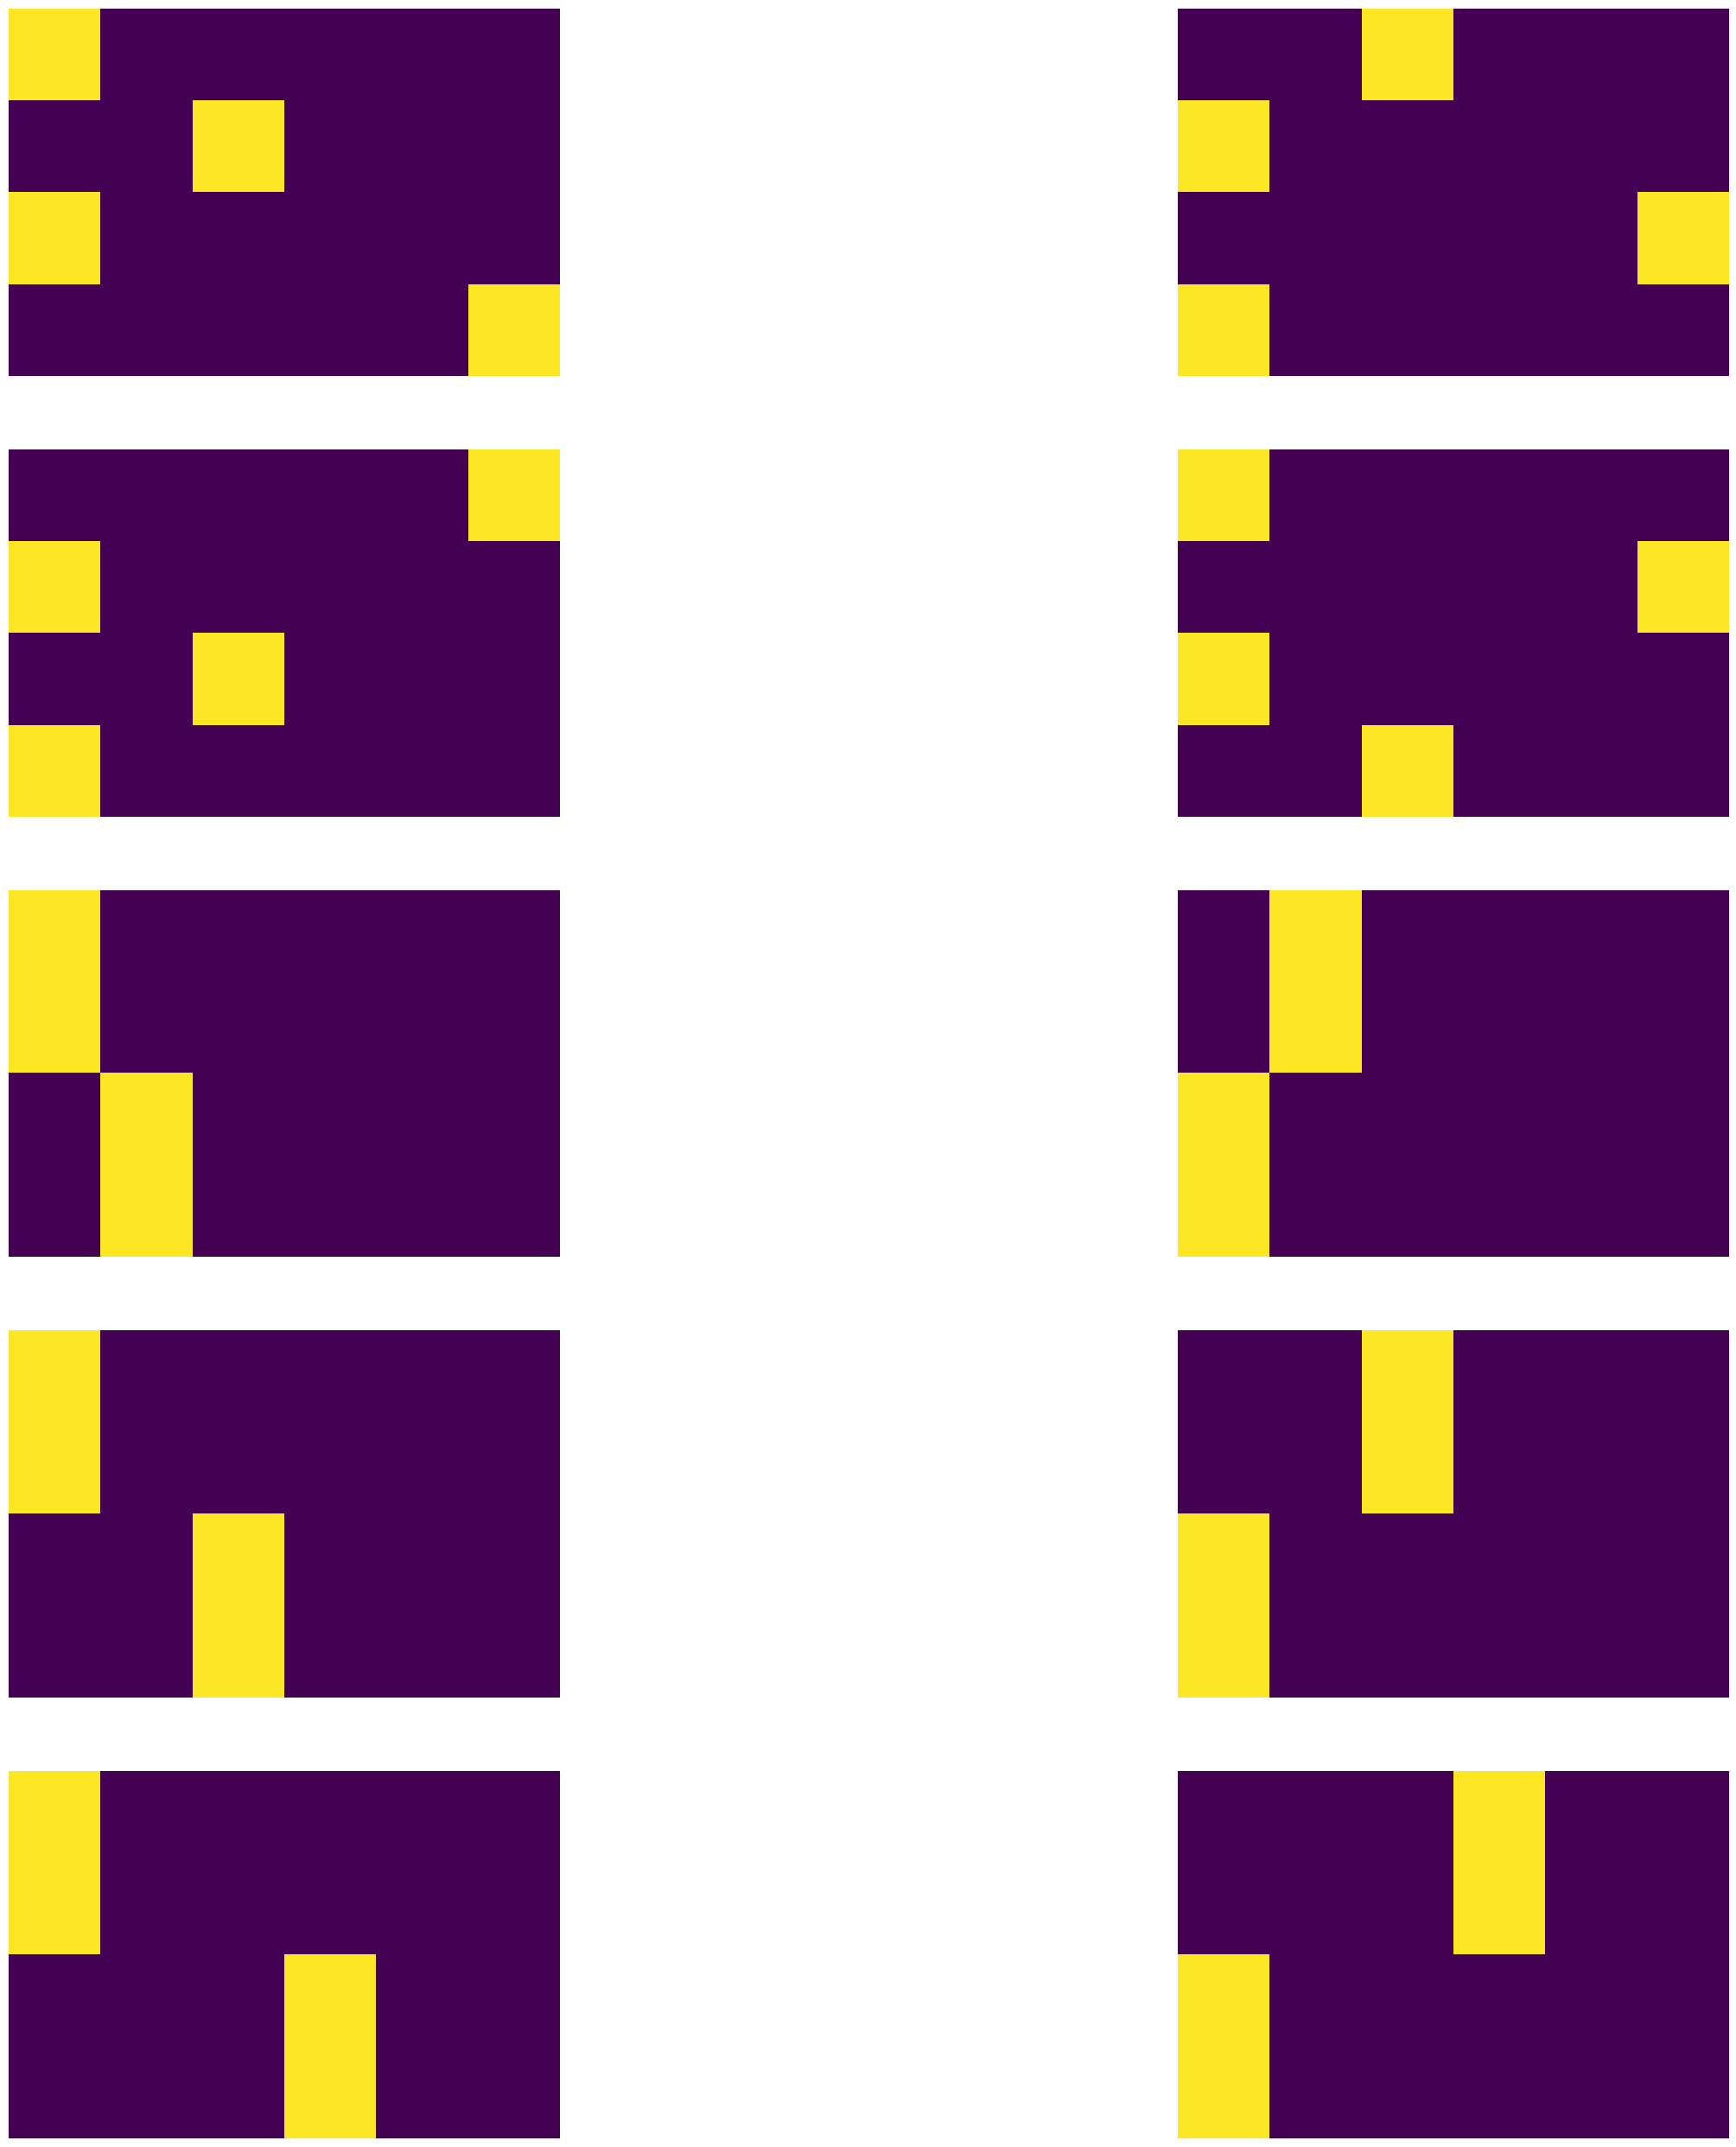

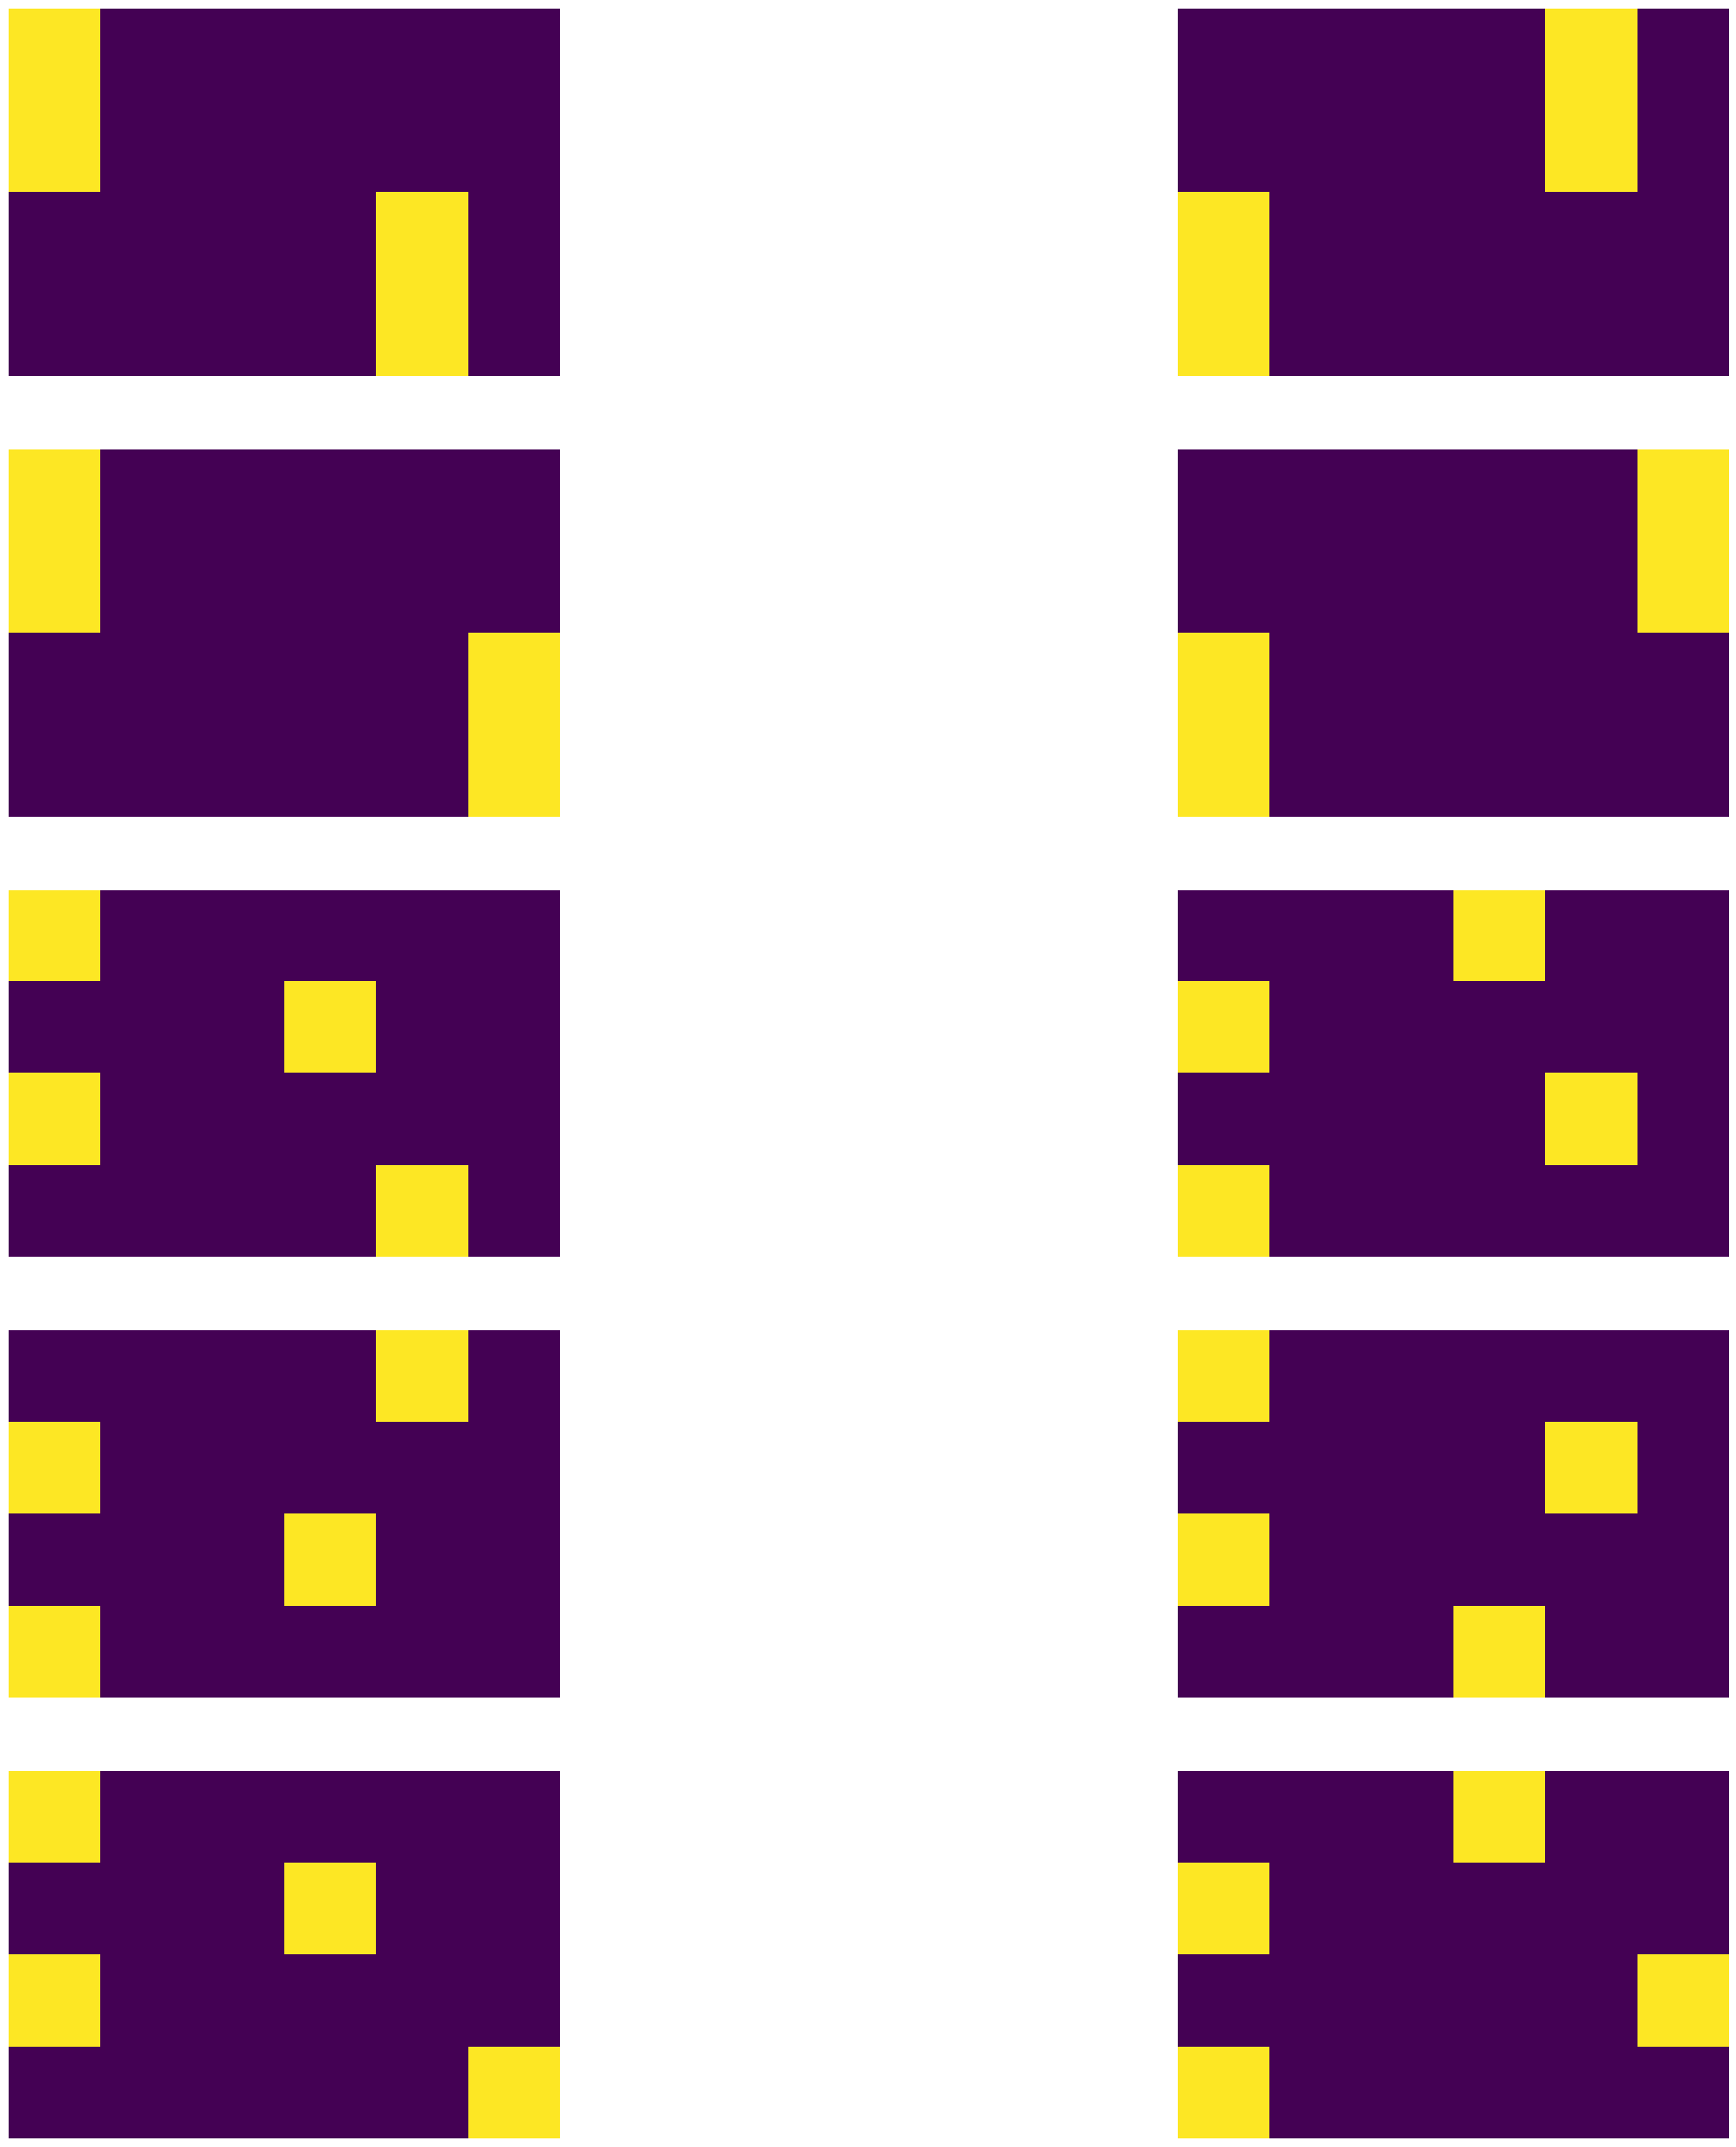

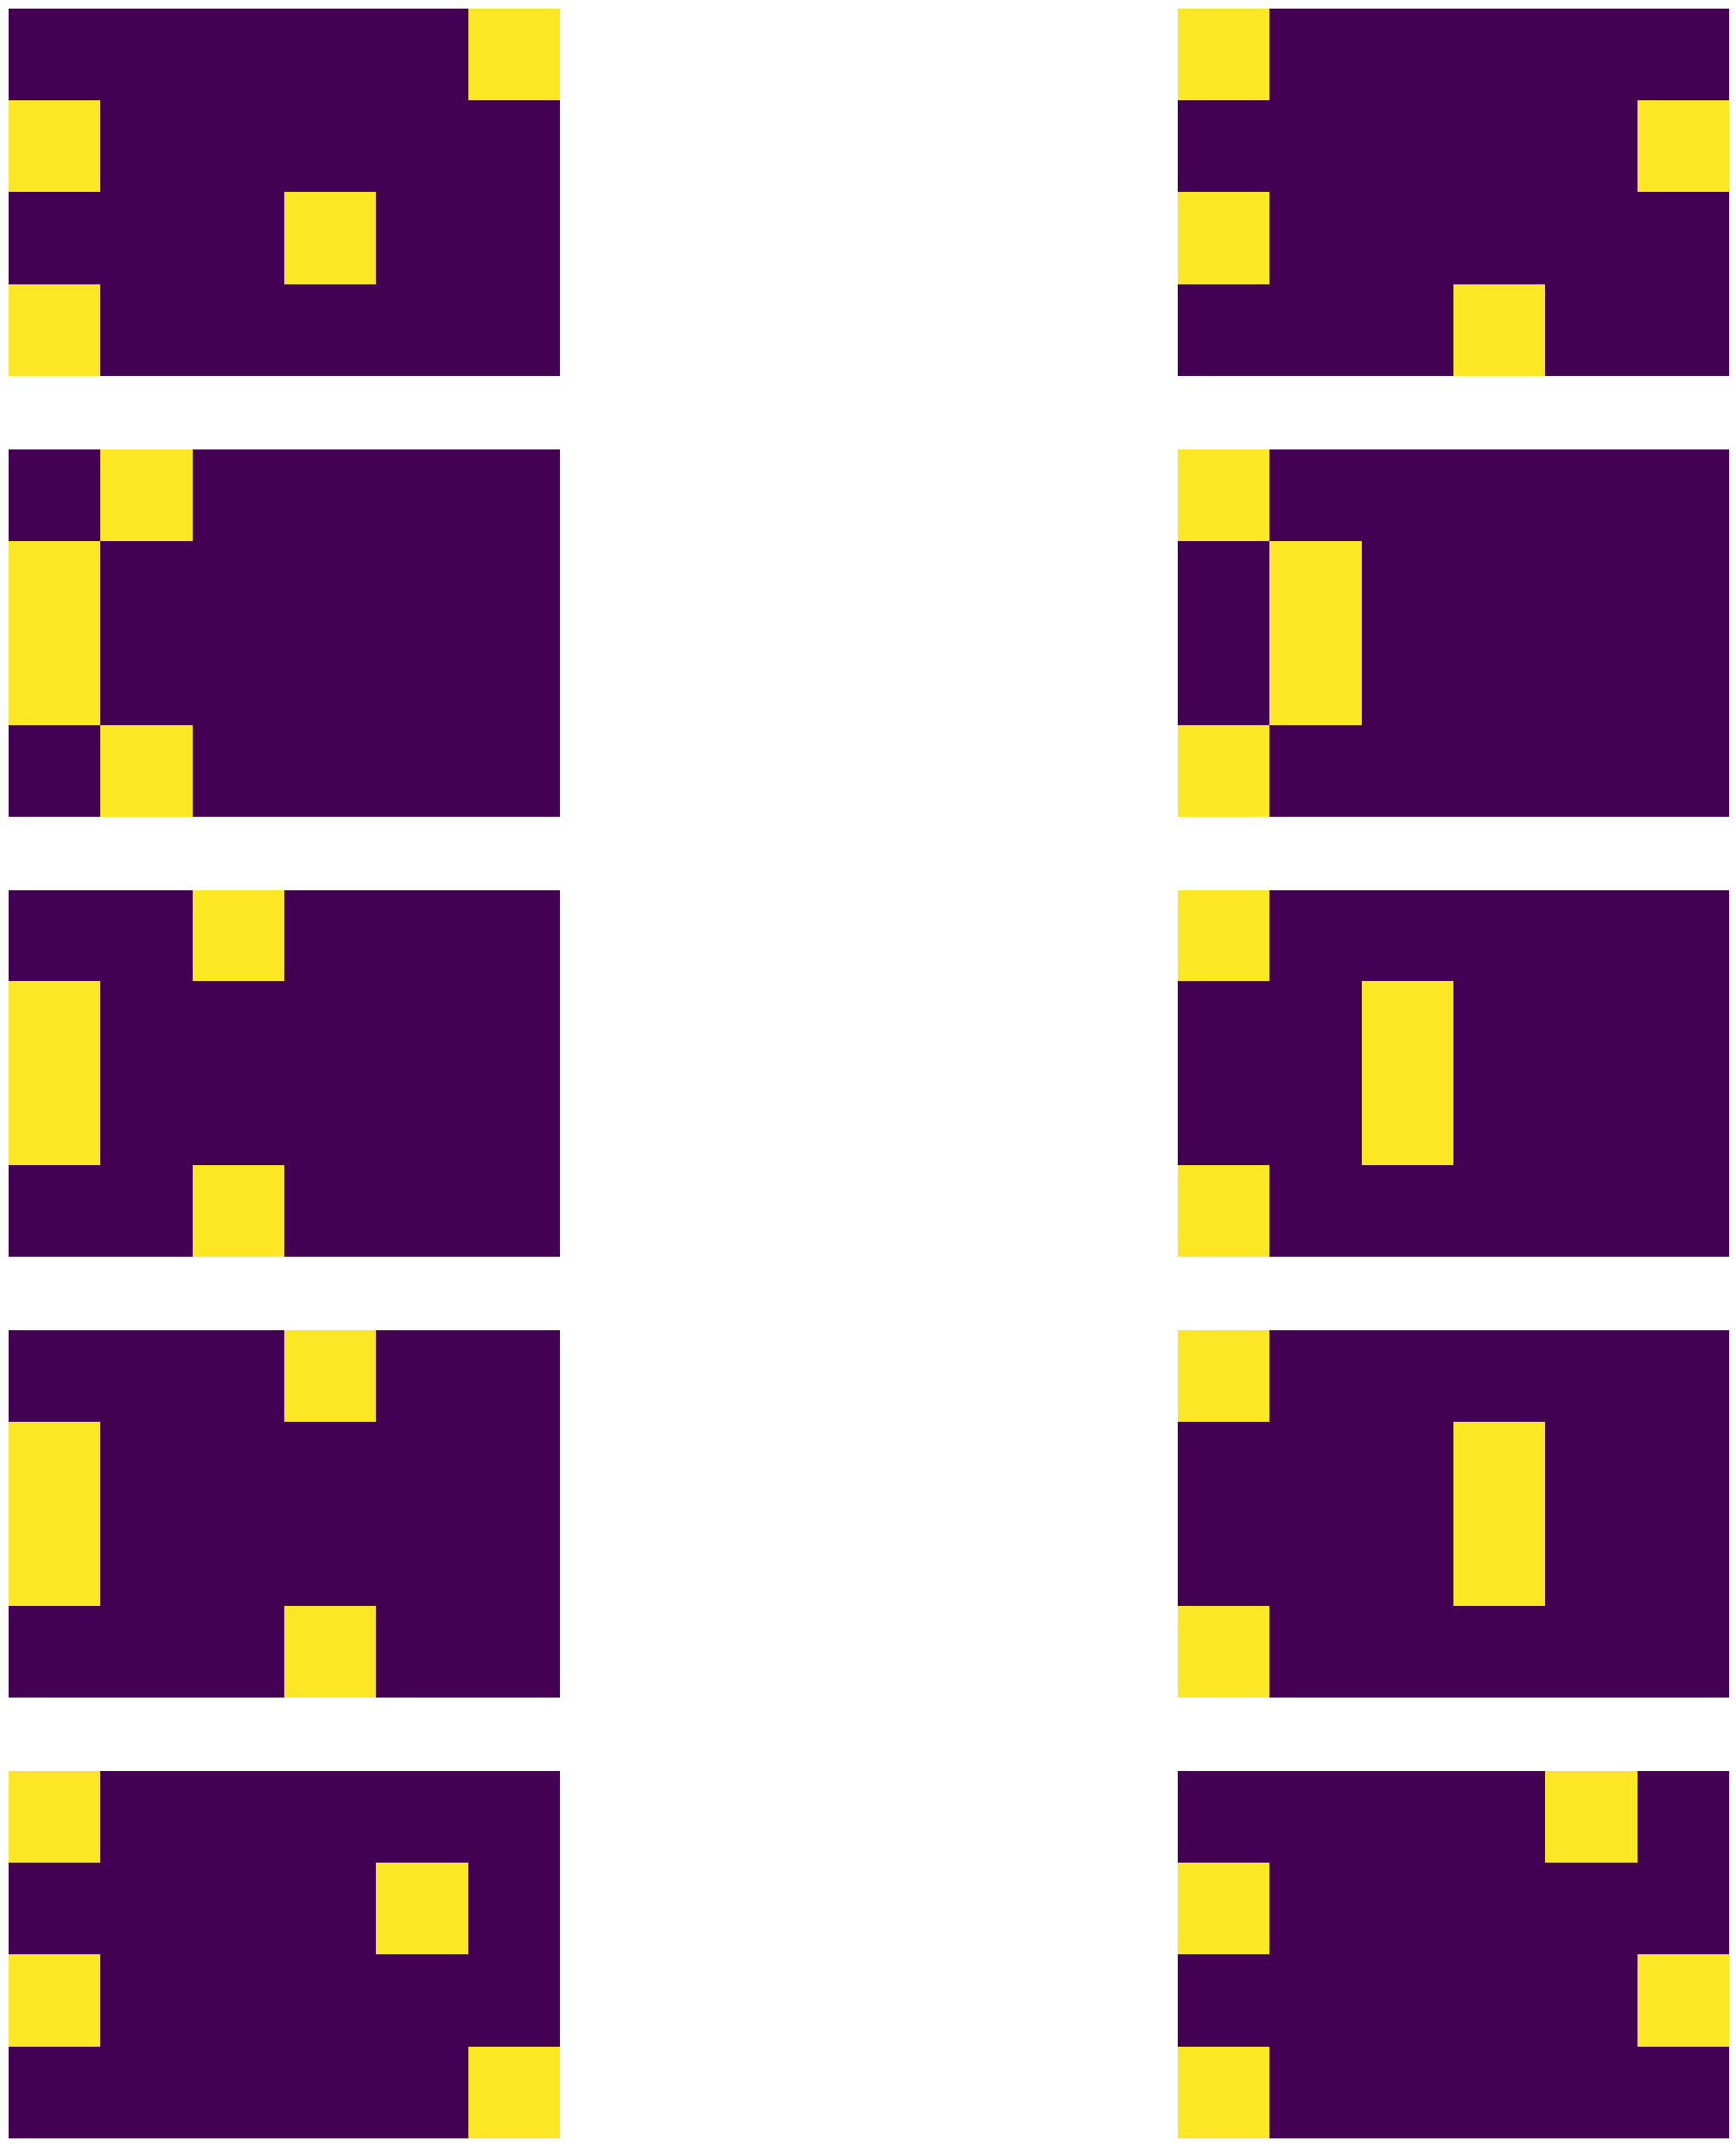

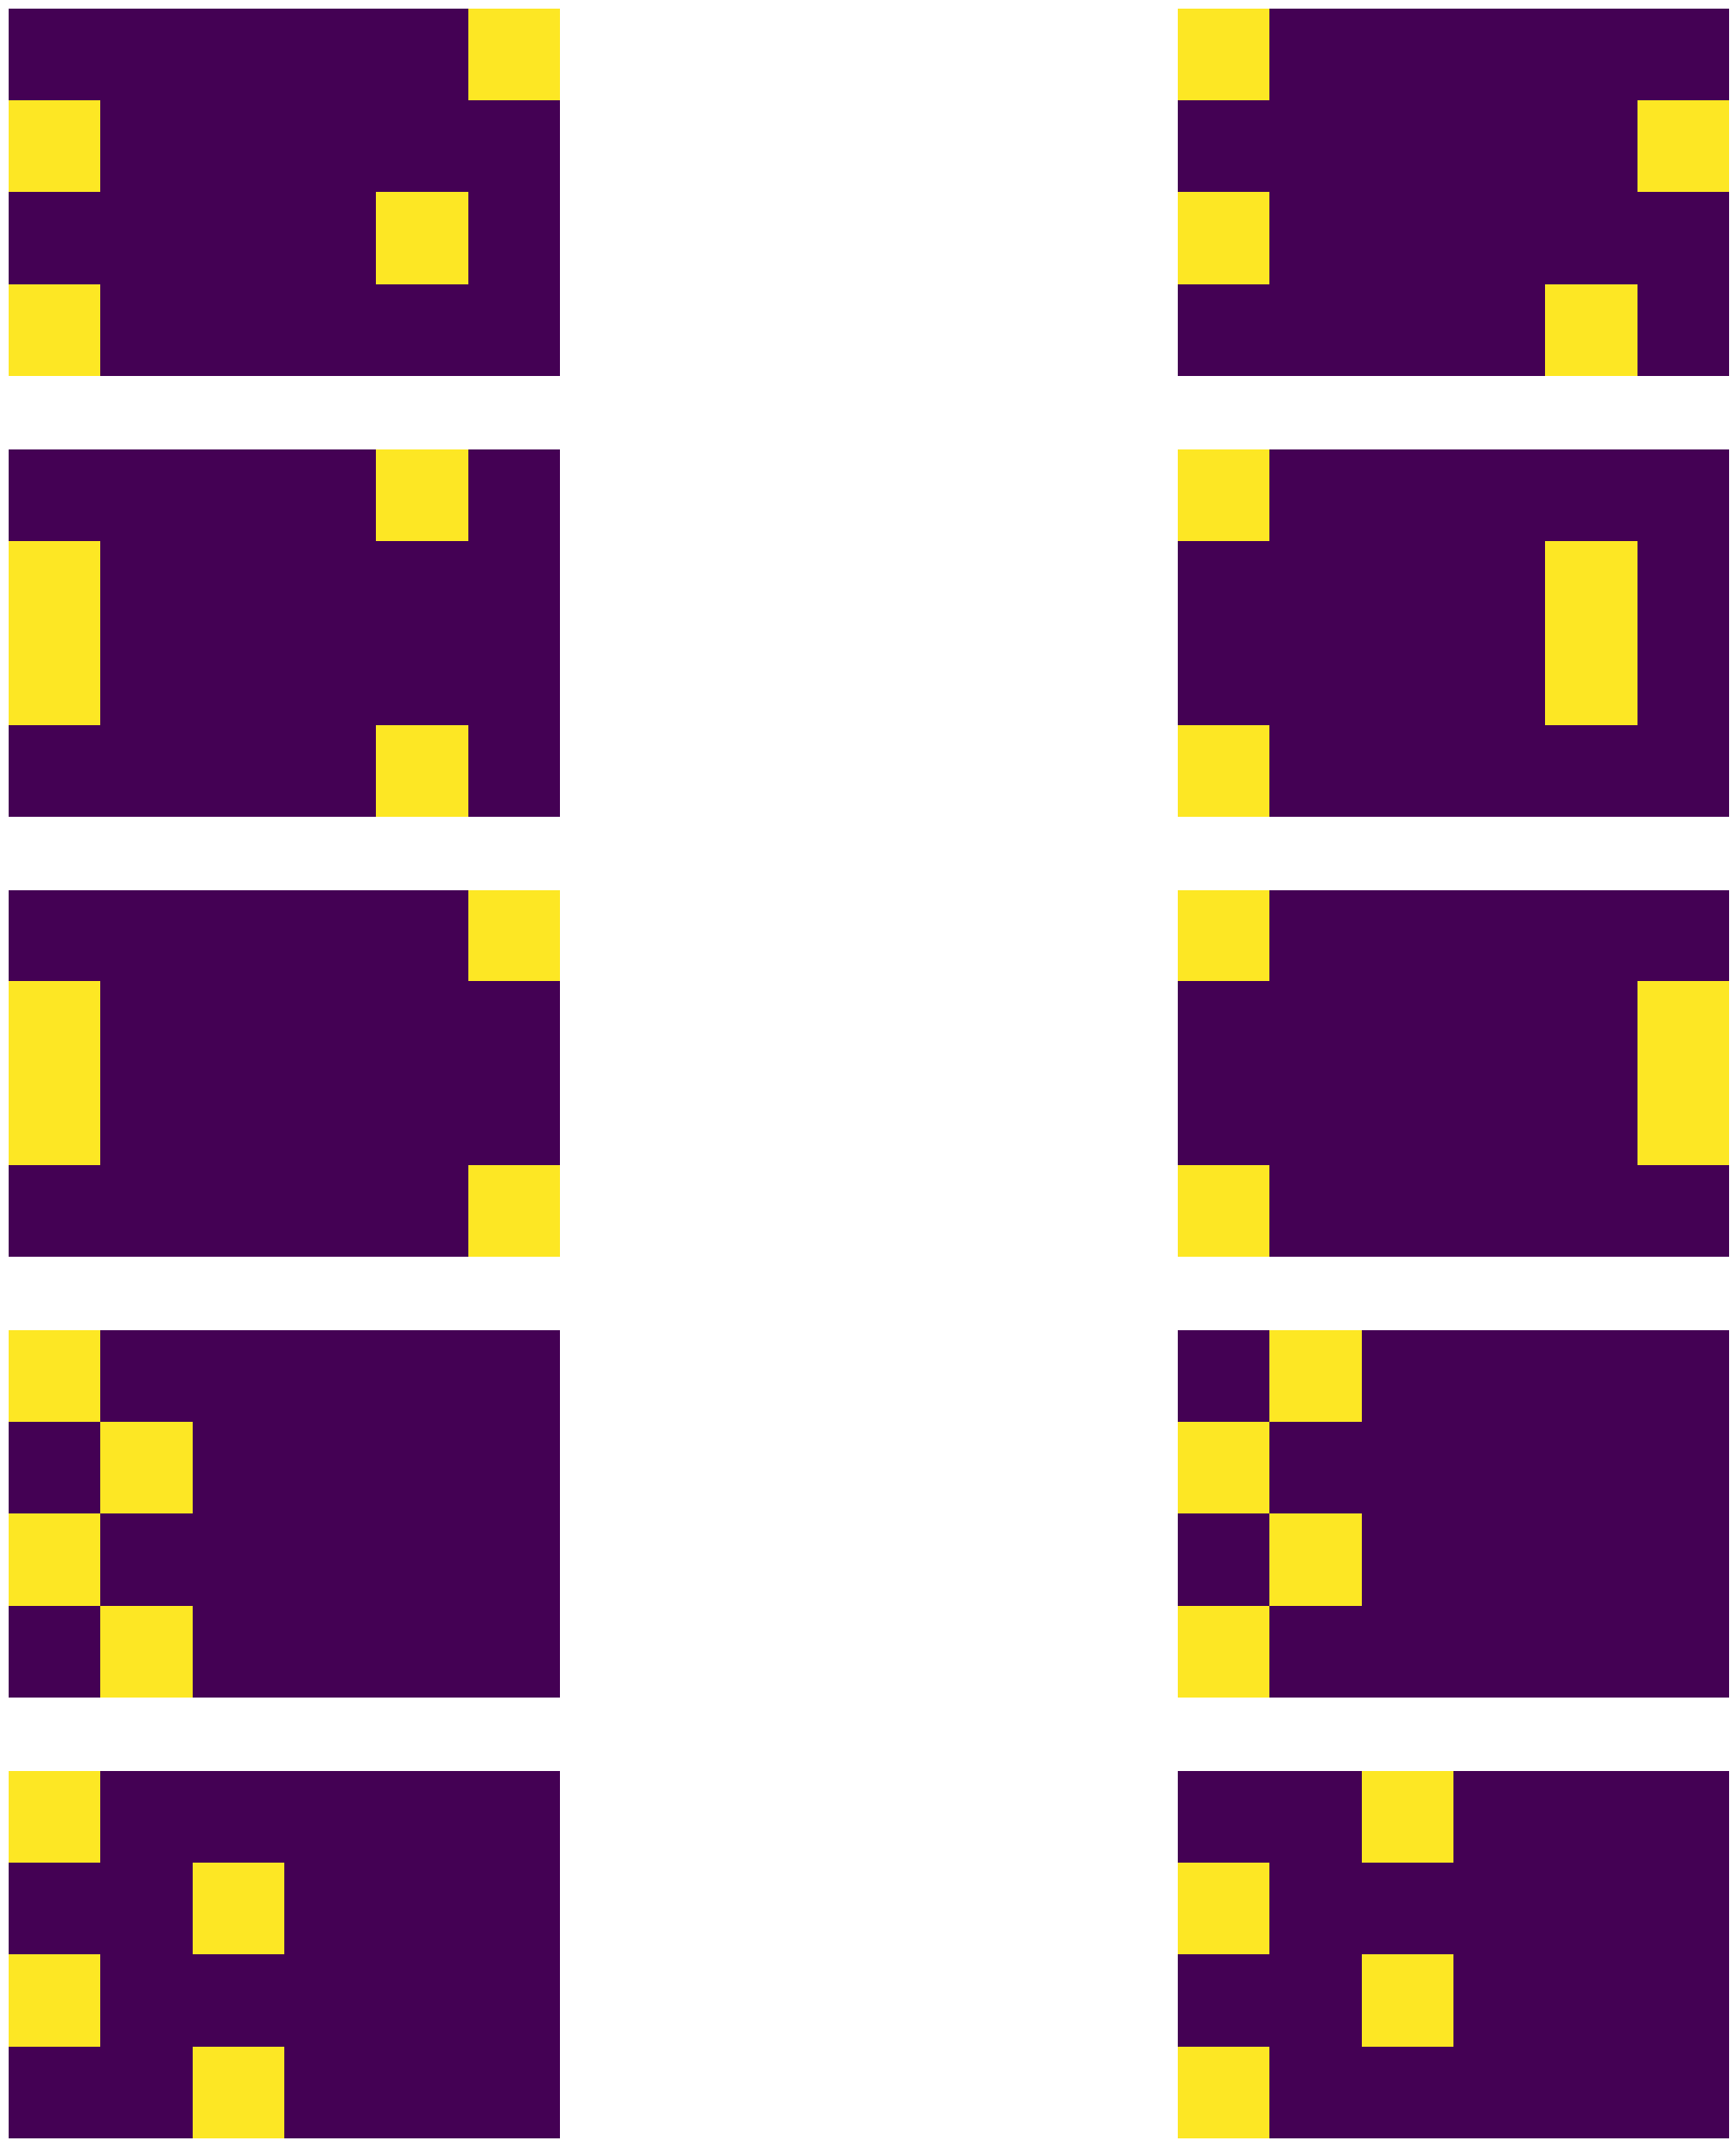

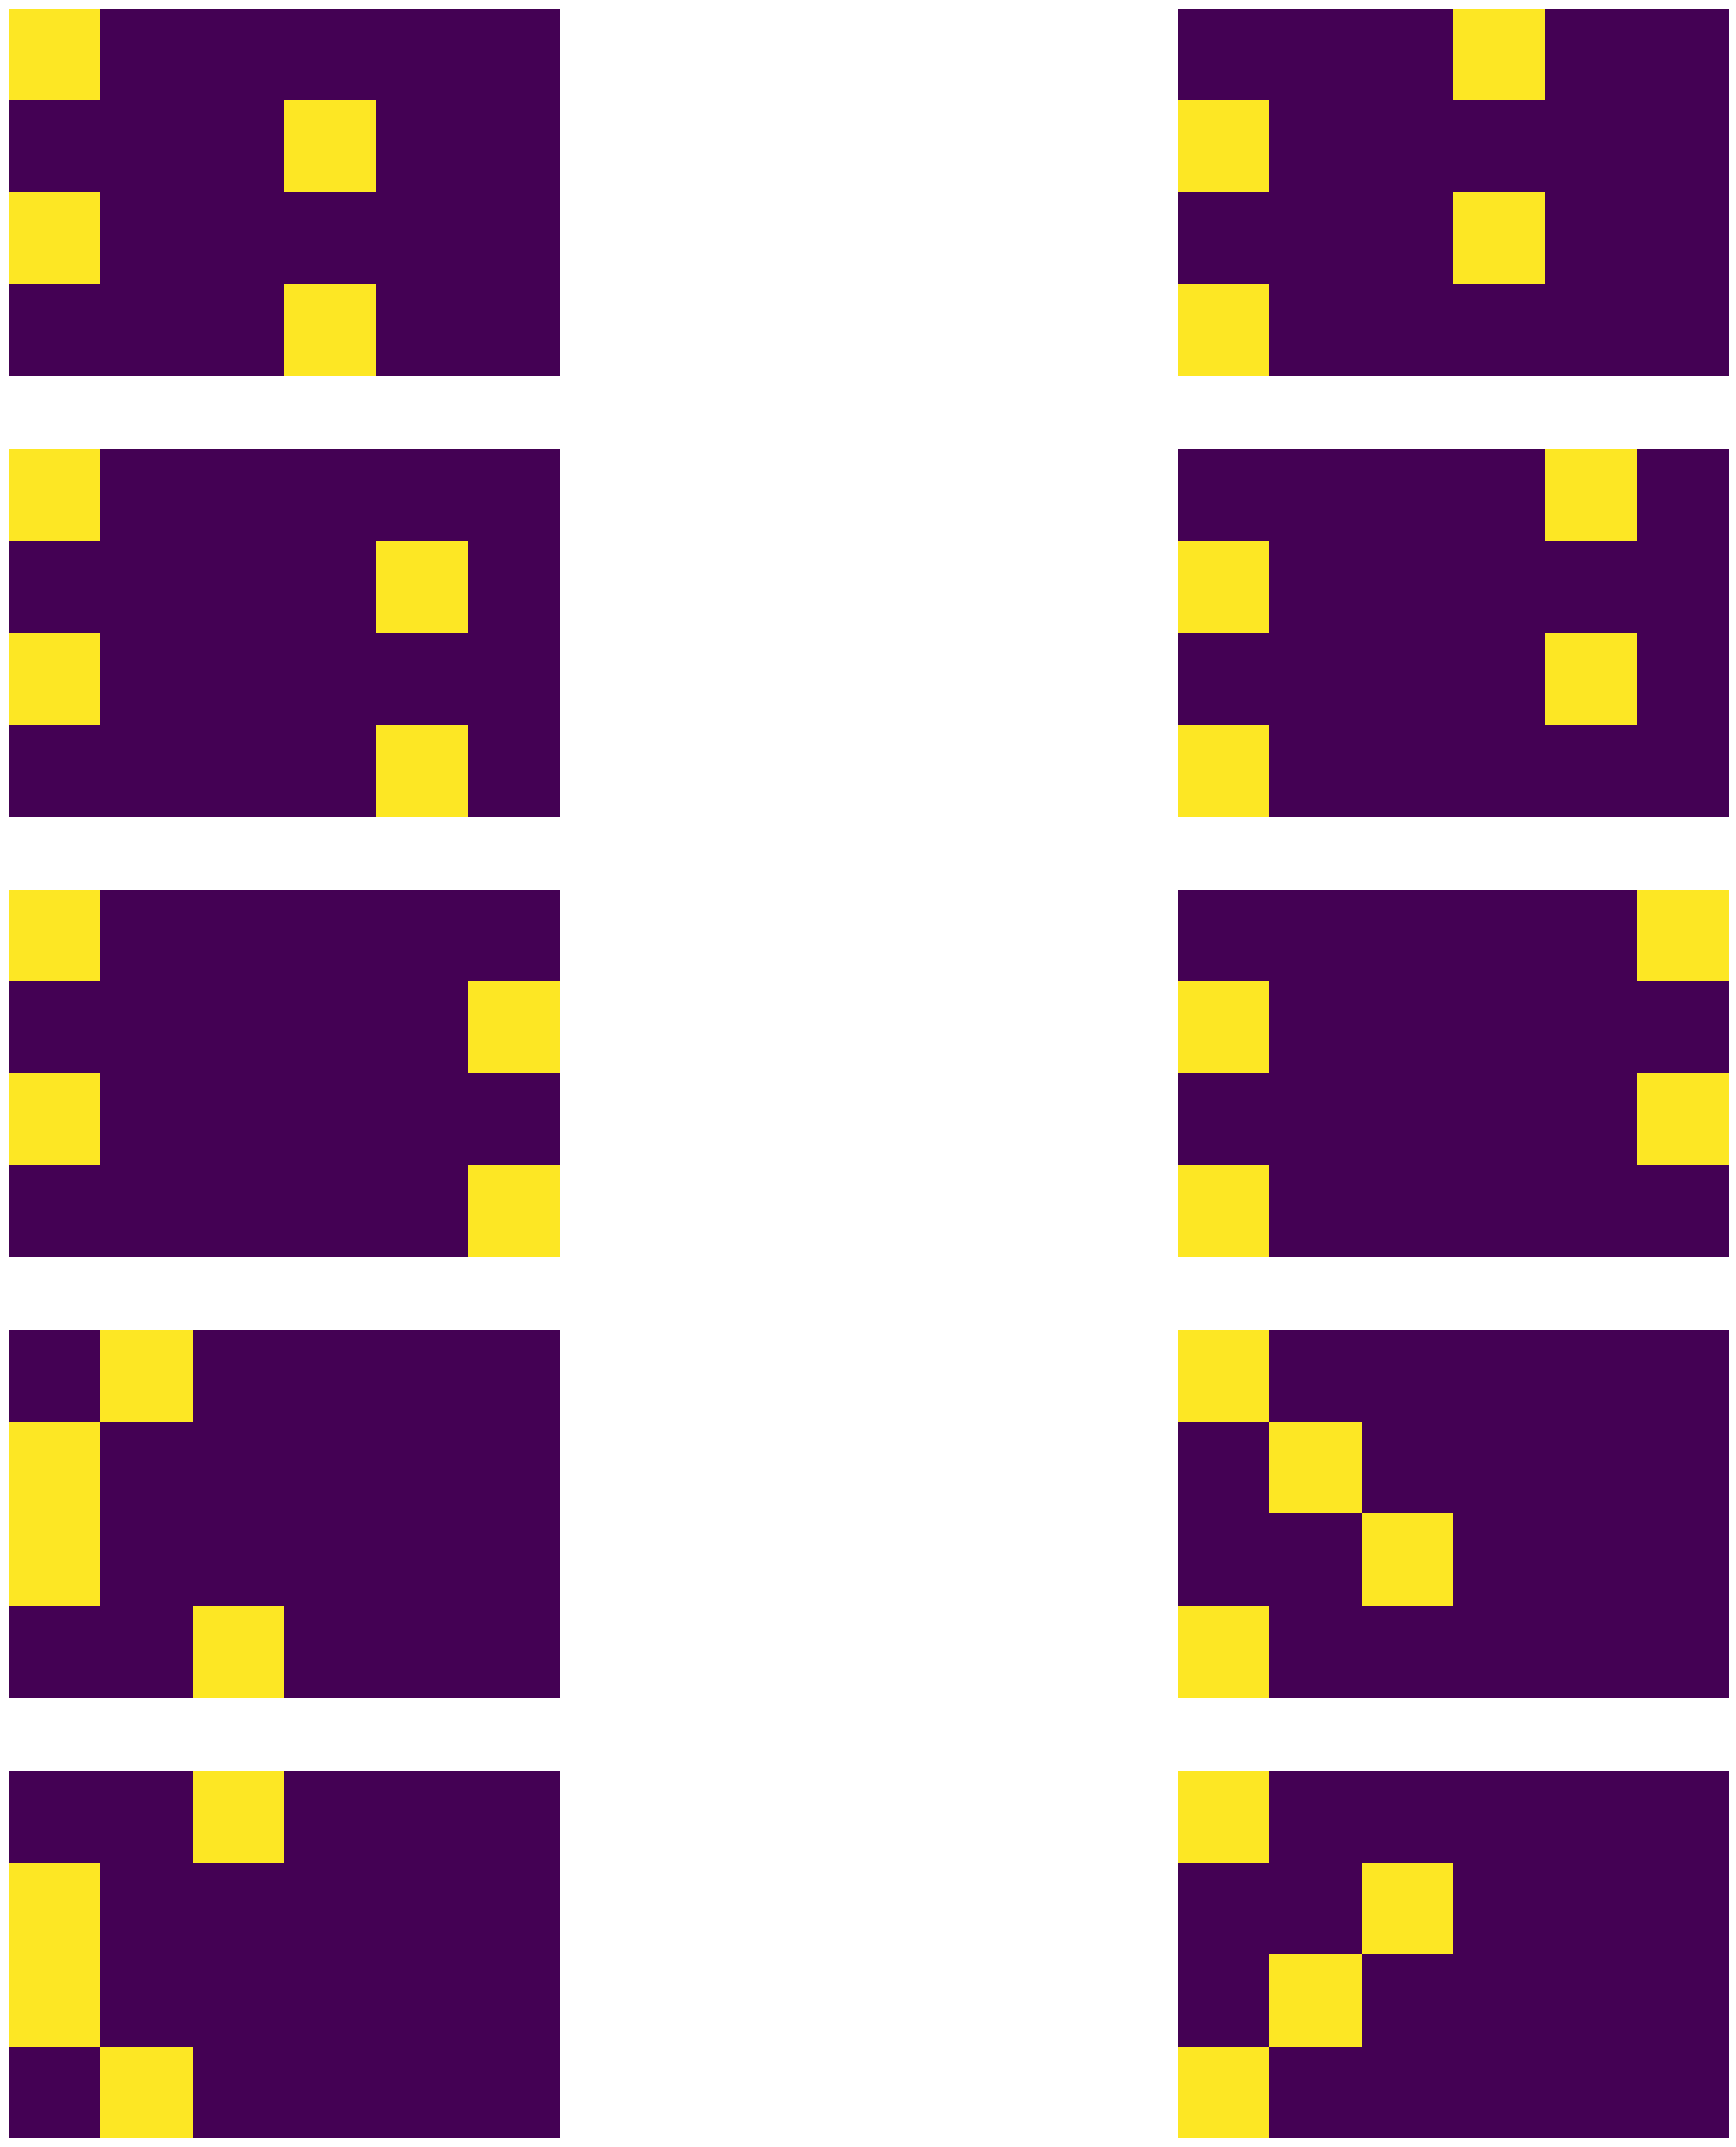

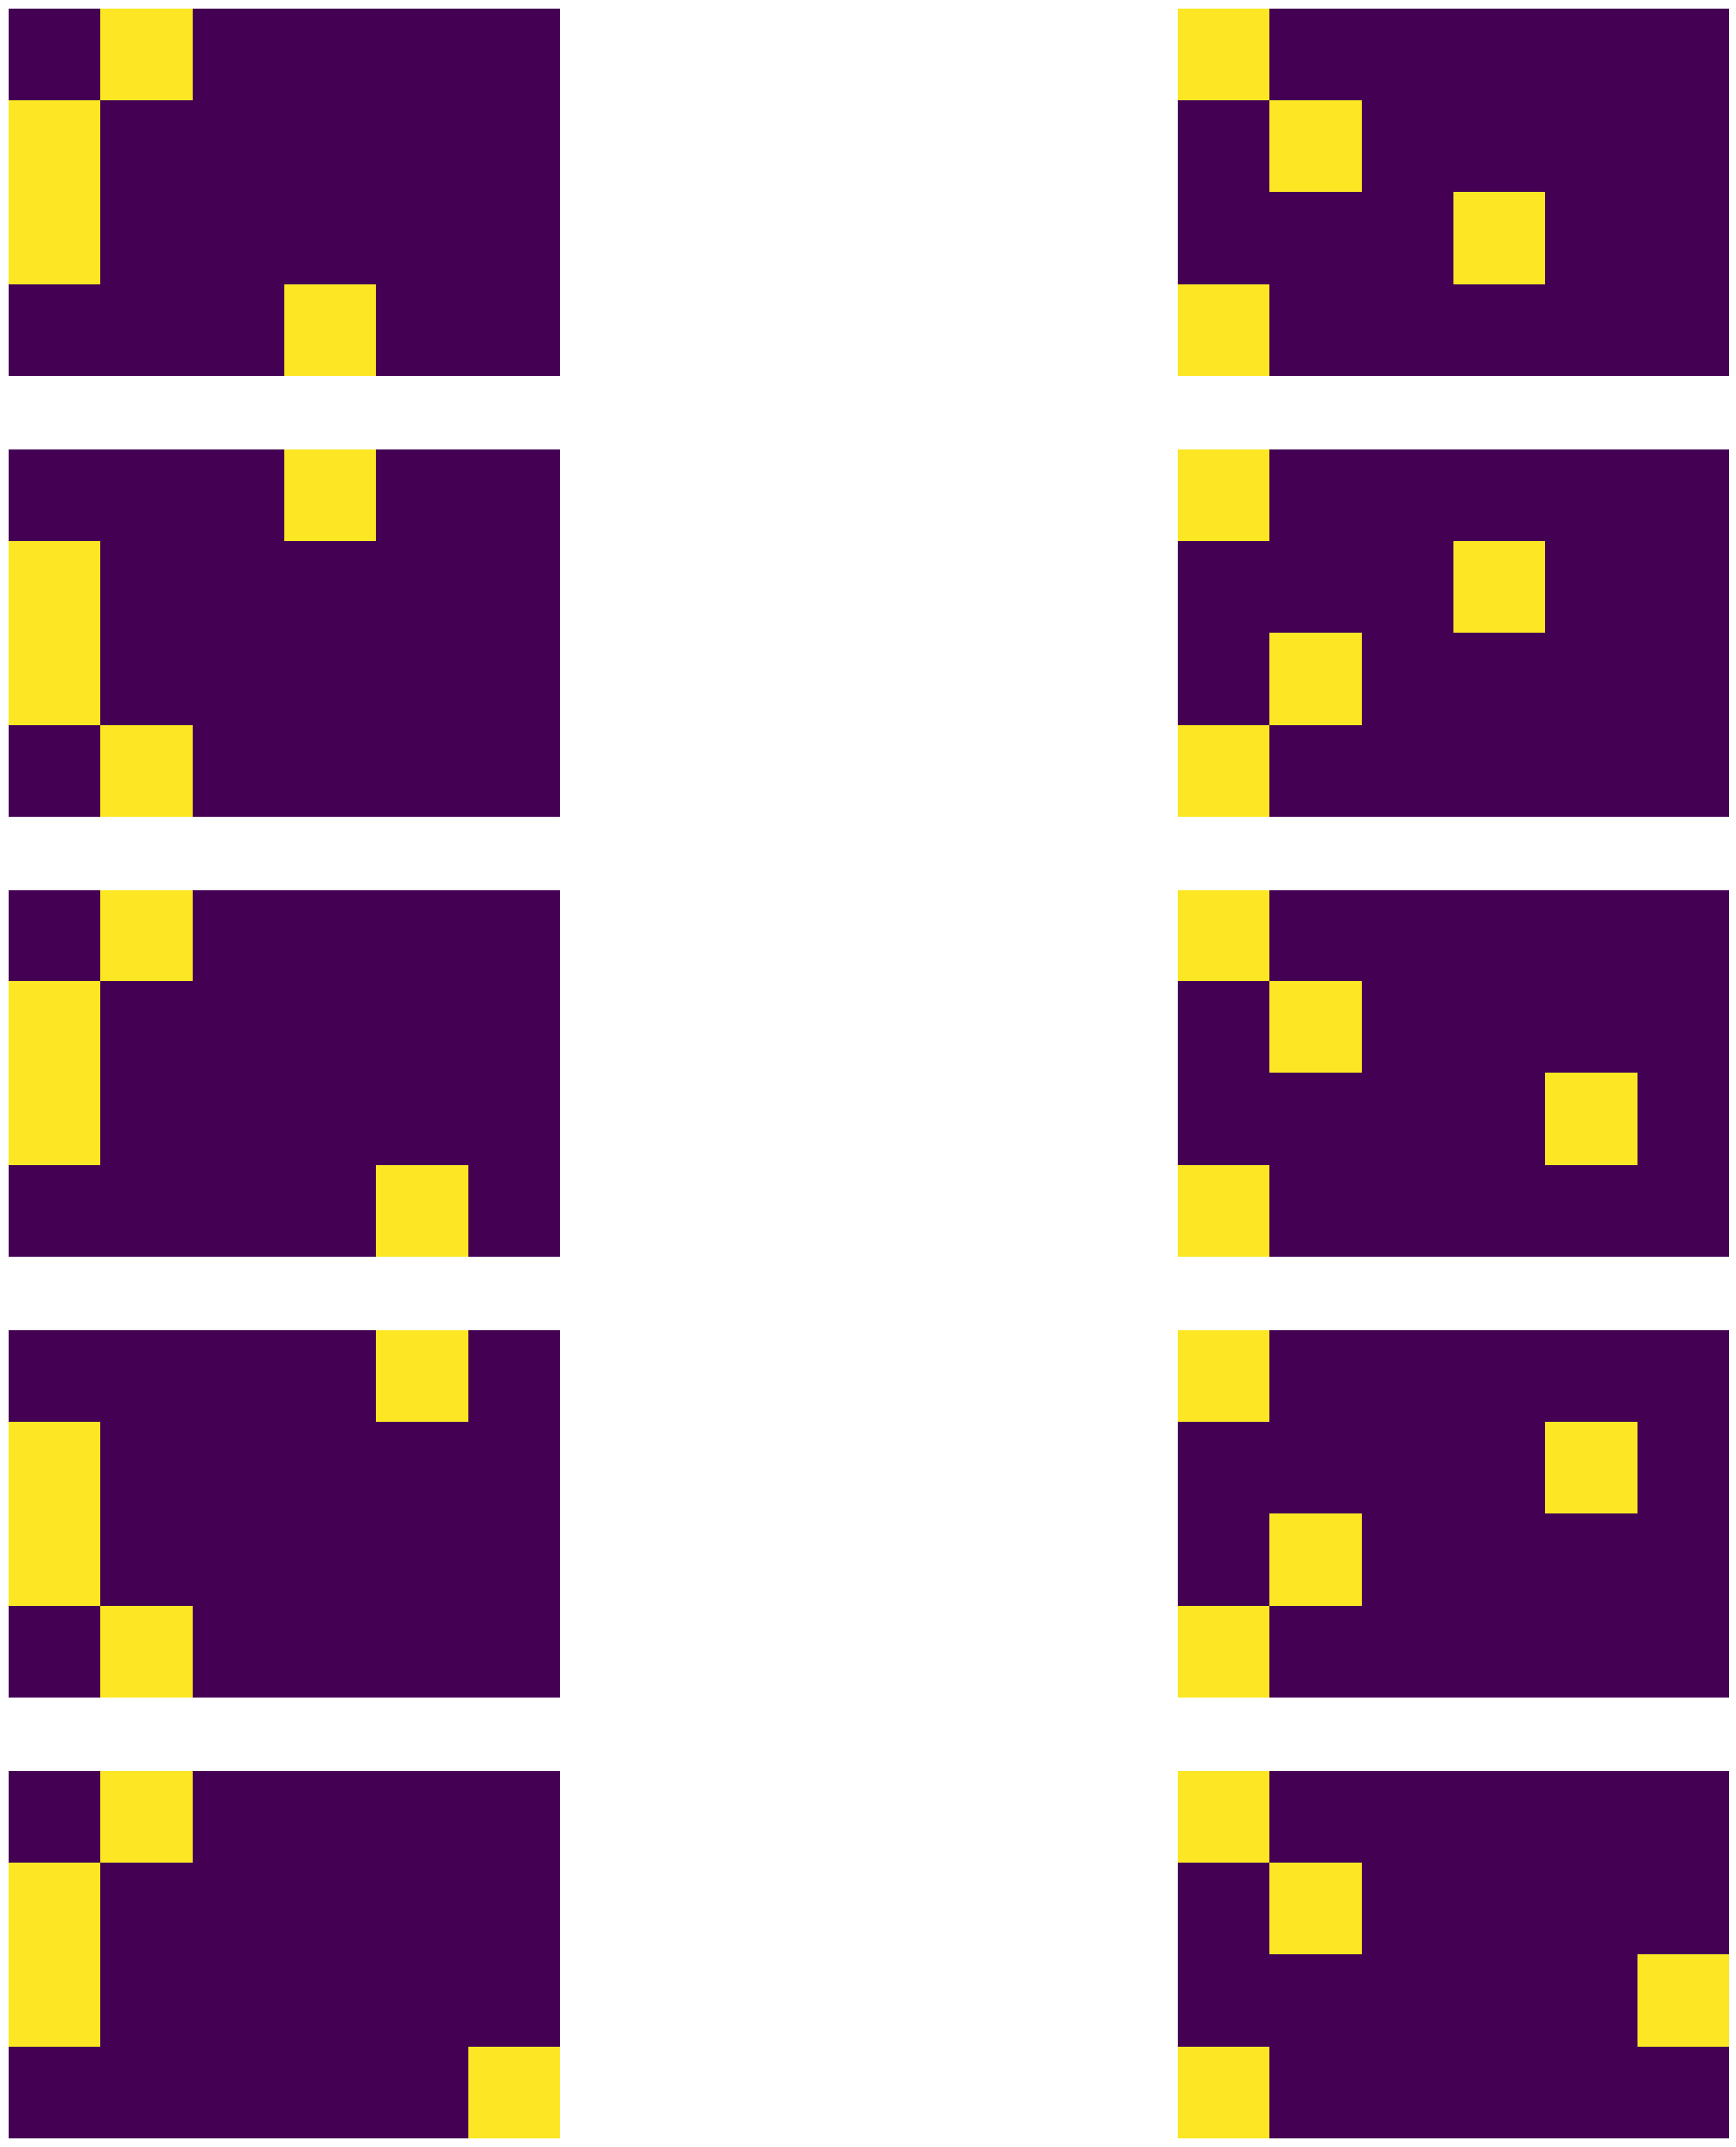

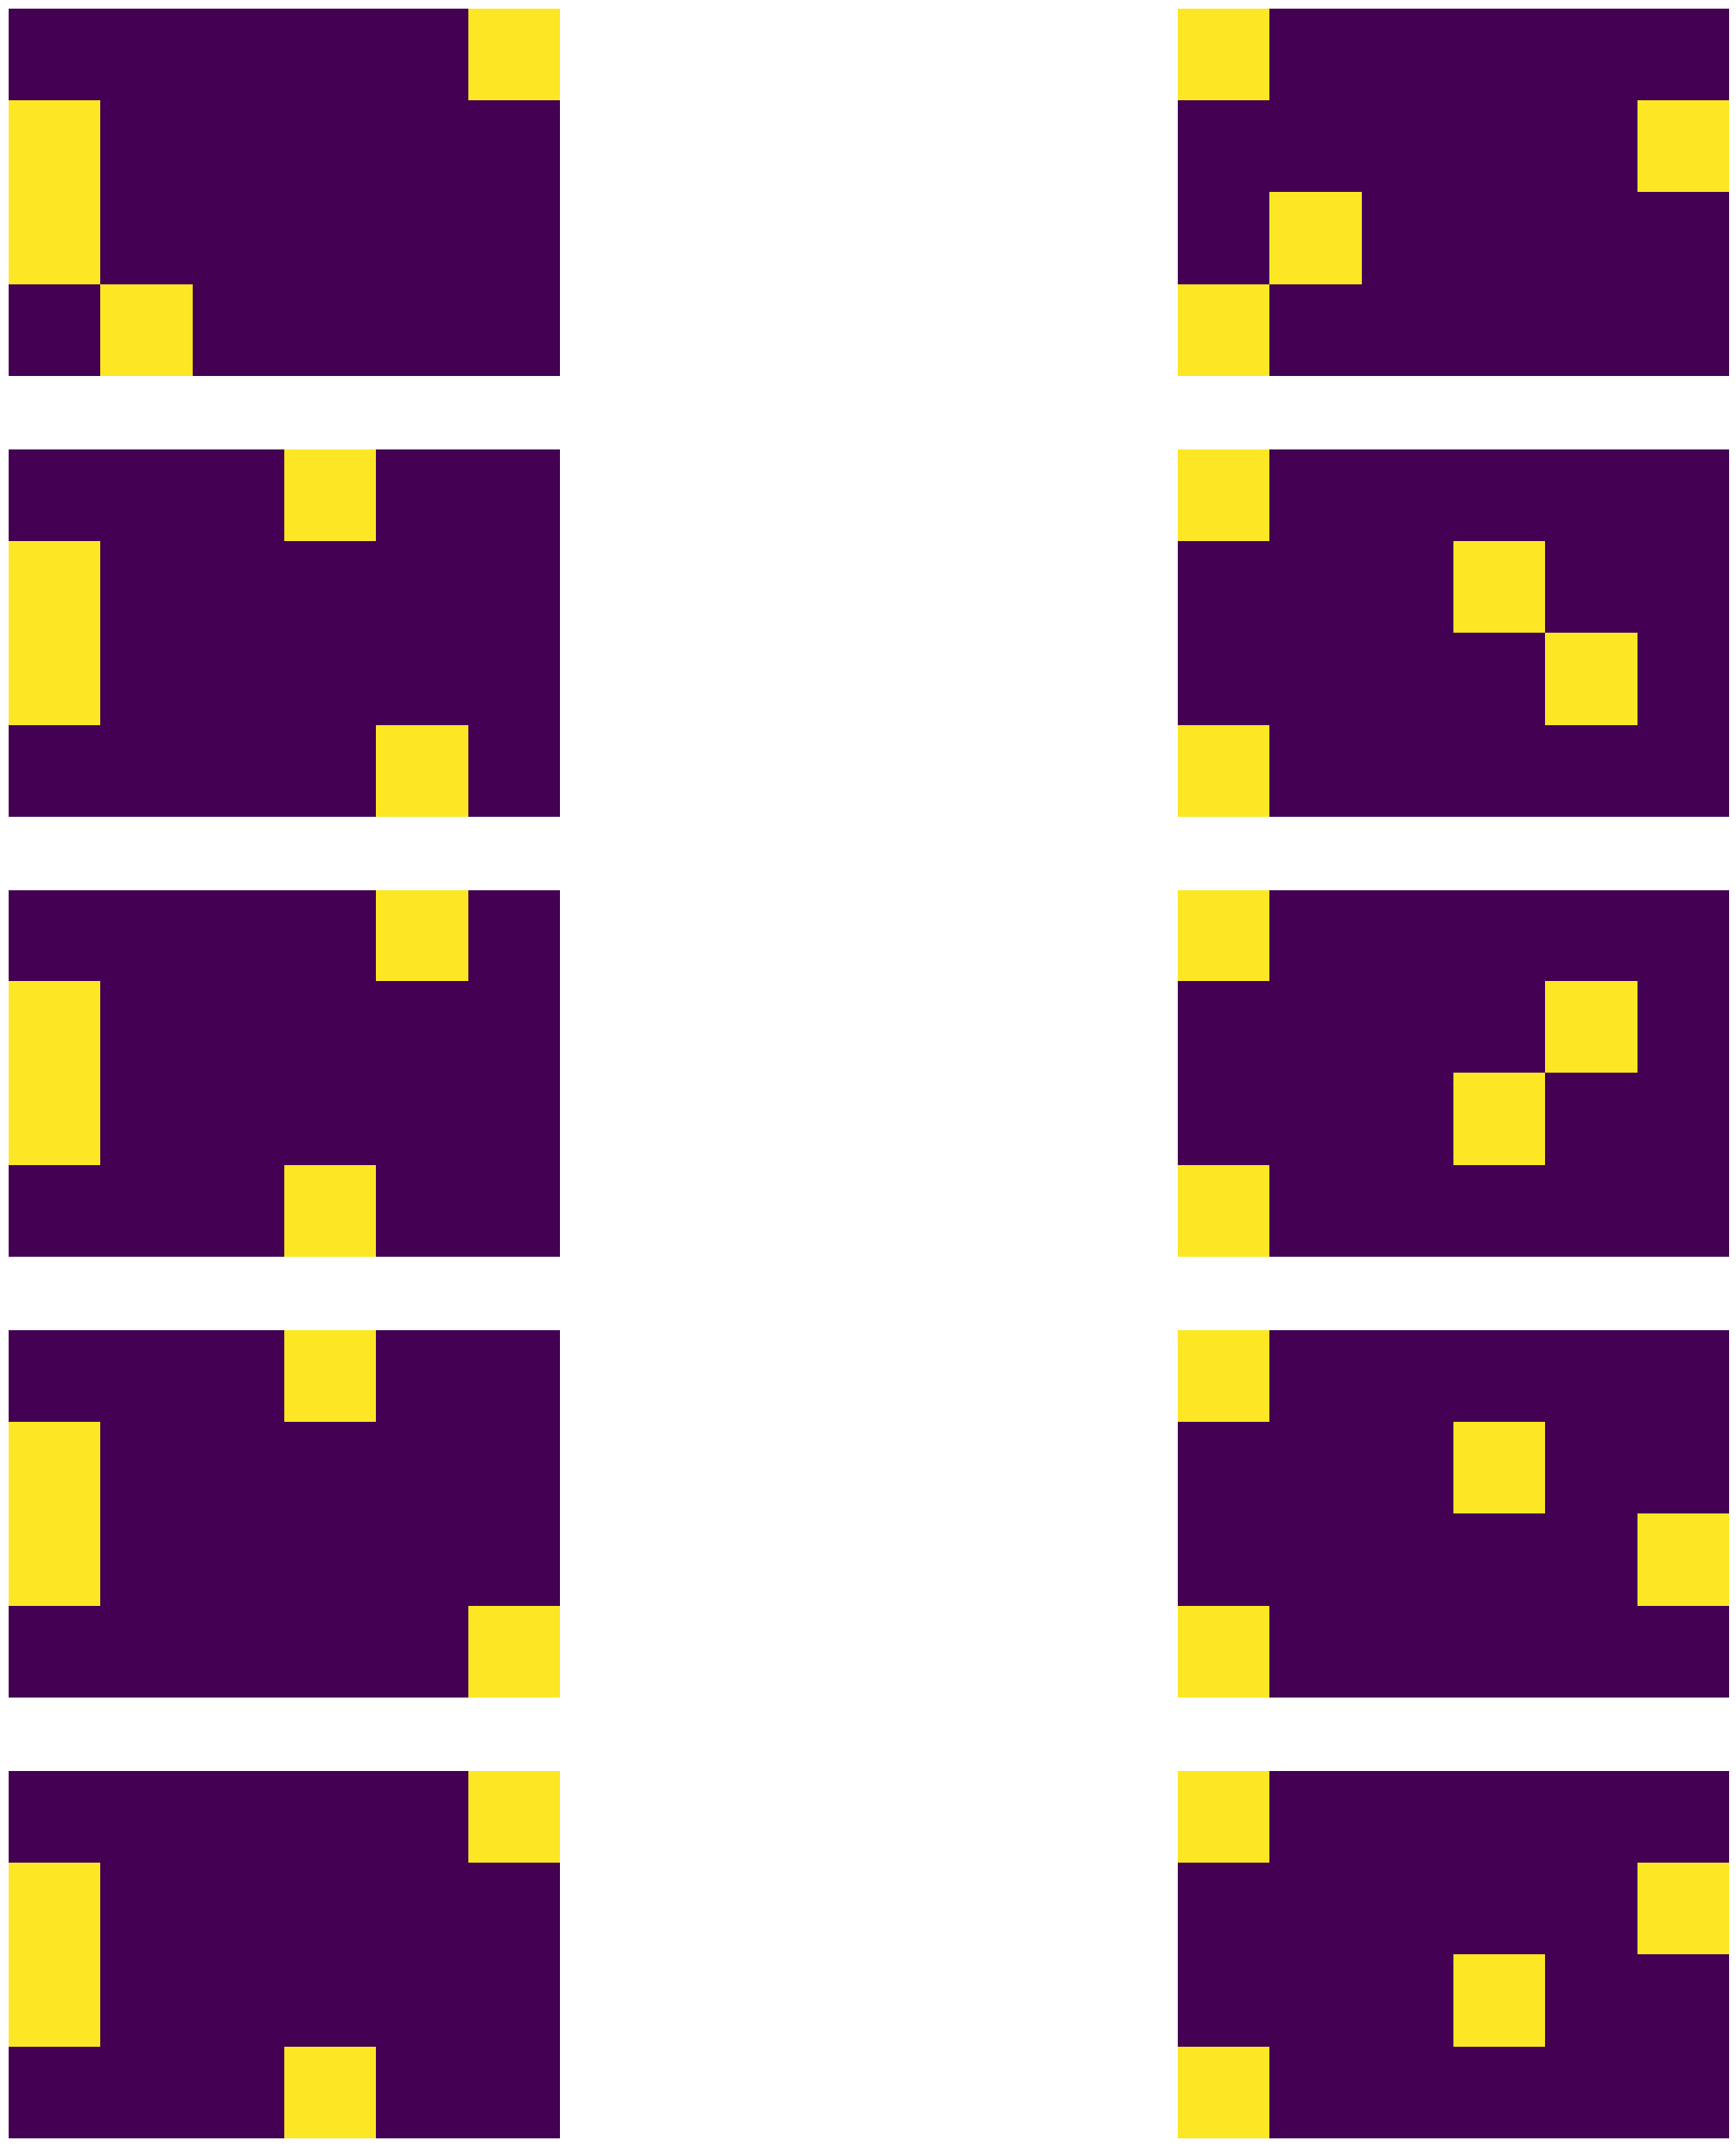

In [275]:
for i in range(17):
    show_samples(X_train[i*10:10*(i+1)])

In [278]:
write_images(X_train, "Imagenes_1_2_sust")

Imagenes guardadas en: Imagenes_1_2_sust


In [282]:
X_train, X_test, y_train, y_test = train_test_list(lista)
X_train,y_train = PrepareConvInput(X_train,y_train)
X_test,y_test = PrepareConvInput(X_test,y_test)

[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 151.0, 152.0, 153.0, 259.0, 35.0, 36.0, 37.0, 301.0, 302.0, 303.0, 304.0, 305.0, 52.0, 53.0, 316.0, 317.0, 319.0, 66.0, 322.0, 326.0, 331.0, 332.0, 333.0, 334.0, 335.0, 81.0, 82.0, 83.0, 84.0, 211.0, 212.0]


In [283]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
print(X_train[0],y_train)

[[[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[1]
  [0]
  [0]
  [0]
  [0]
  [0]]

 [[0]
  [1]
  [0]
  [0]
  [0]
  [0]]] [[ 1.2901211]
 [ 1.2901211]
 [ 1.2901211]
 [ 1.2901211]
 [ 0.0606045]
 [ 0.0606045]
 [ 0.0606045]
 [ 0.0606045]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 1.146497 ]
 [ 2.6404064]
 [ 2.6404064]
 [ 2.6404064]
 [ 2.6404064]
 [ 4.0071102]
 [ 4.0071102]
 [ 4.0071102]
 [ 4.0071102]
 [ 3.0106935]
 [ 3.0106935]
 [ 3.0106935]
 [ 3.0106935]
 [ 2.0553875]
 [ 2.0553875]
 [ 2.0553875]
 [ 2.0553875]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 4.468386 ]
 [ 6.7266701]
 [ 6.7266701]
 [ 6.7266701]
 [ 6.7266701]
 [ 0.6983428]
 [ 0.6983428]
 [ 0.6983428]
 [ 0.6983428]
 [ 3.8583167]
 [ 3.8583167]
 [ 3.8583167]
 [ 3.8583167]
 [ 5.2569038]
 [ 5.2569038]
 [ 5.2569038]
 [ 5.2569038]
 [ 3.8940447]
 [ 3.8940447]
 [ 3.8940447]
 [ 3.8940447]
 [ 4.4974041]
 [ 4.4974041]
 [ 4.4974041]
 [ 4.4974041]
 [ 6.3389403]
 [ 6.3389403]
 [ 6.3389403]
 [ 6.3389403]
 [ 2.047

In [344]:
image_size = (4,6)

In [397]:
inputs = tf.keras.Input(shape=image_size + (1, ), name='inputs')

# Conv Layer 1
#conv_1 = layers.Conv2D(64, 1, padding='valid', activation='elu',
#                       name='conv_1')(inputs)
#pool_1 = layers.MaxPooling2D(pool_size=(1, 1), name='pool_1')(conv_1)

# Conv Layer 2
#conv_2 = layers.Conv2D(64, 1, padding='valid', activation='elu',
#                       name='conv_2')(pool_1)
#pool_2 = layers.MaxPooling2D(pool_size=(1, 1), name='pool_2')(conv_2)


# Fully-connected
# Flattening
#flat = layers.Flatten(name='flatten')(pool_2)
#flat = layers.Flatten(name='flatten')(conv_1)
flat = layers.Flatten(name='flatten')(inputs)
dense = layers.Dense(64, activation='elu', name='dense')(flat)
outputs = layers.Dense(1, activation='linear', name='output')(dense)

model = keras.Model(inputs=inputs, outputs=outputs, name='cnn_example')

In [398]:
model.summary()
esNOSTOP = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)   #alternative patience=np.inf
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)
CALLBACKS = [esNOSTOP]
CALLBACKS = []

Model: "cnn_example"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 4, 6, 1)]         0         
                                                                 
 flatten (Flatten)           (None, 24)                0         
                                                                 
 dense (Dense)               (None, 64)                1600      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 1,665
Trainable params: 1,665
Non-trainable params: 0
_________________________________________________________________


In [399]:
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mean_absolute_error'])
history = model.fit(
    X_train, 
    y_train,
    batch_size=64,
    epochs=2000,
    validation_split=0.2,
    callbacks=CALLBACKS
)

Epoch 1/2000
3/3 [==============================] - 1s 79ms/step - loss: 18.9314 - mean_absolute_error: 3.7713 - val_loss: 20.6750 - val_mean_absolute_error: 3.6434
Epoch 2/2000
3/3 [==============================] - 0s 19ms/step - loss: 17.7622 - mean_absolute_error: 3.6240 - val_loss: 19.5513 - val_mean_absolute_error: 3.4870
Epoch 3/2000
3/3 [==============================] - 0s 21ms/step - loss: 16.7156 - mean_absolute_error: 3.4859 - val_loss: 18.4987 - val_mean_absolute_error: 3.3339
Epoch 4/2000
3/3 [==============================] - 0s 21ms/step - loss: 15.7135 - mean_absolute_error: 3.3488 - val_loss: 17.5102 - val_mean_absolute_error: 3.1942
Epoch 5/2000
3/3 [==============================] - 0s 18ms/step - loss: 14.7768 - mean_absolute_error: 3.2166 - val_loss: 16.5719 - val_mean_absolute_error: 3.0645
Epoch 6/2000
3/3 [==============================] - 0s 18ms/step - loss: 13.9317 - mean_absolute_error: 3.0887 - val_loss: 15.6829 - val_mean_absolute_error: 2.9428
Epoch 7/20

Epoch 51/2000
3/3 [==============================] - 0s 18ms/step - loss: 4.1592 - mean_absolute_error: 1.5777 - val_loss: 5.1768 - val_mean_absolute_error: 1.4327
Epoch 52/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.1180 - mean_absolute_error: 1.5680 - val_loss: 5.1288 - val_mean_absolute_error: 1.4208
Epoch 53/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.0839 - mean_absolute_error: 1.5588 - val_loss: 5.0794 - val_mean_absolute_error: 1.4101
Epoch 54/2000
3/3 [==============================] - 0s 17ms/step - loss: 4.0445 - mean_absolute_error: 1.5494 - val_loss: 5.0281 - val_mean_absolute_error: 1.4010
Epoch 55/2000
3/3 [==============================] - 0s 16ms/step - loss: 4.0078 - mean_absolute_error: 1.5390 - val_loss: 4.9680 - val_mean_absolute_error: 1.3938
Epoch 56/2000
3/3 [==============================] - 0s 25ms/step - loss: 3.9637 - mean_absolute_error: 1.5267 - val_loss: 4.9092 - val_mean_absolute_error: 1.3878
Epoch 57/2000
3/

Epoch 101/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.9949 - mean_absolute_error: 1.2573 - val_loss: 3.5994 - val_mean_absolute_error: 1.2949
Epoch 102/2000
3/3 [==============================] - 0s 21ms/step - loss: 2.9884 - mean_absolute_error: 1.2566 - val_loss: 3.5947 - val_mean_absolute_error: 1.2950
Epoch 103/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.9822 - mean_absolute_error: 1.2557 - val_loss: 3.5904 - val_mean_absolute_error: 1.2951
Epoch 104/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.9776 - mean_absolute_error: 1.2540 - val_loss: 3.5821 - val_mean_absolute_error: 1.2956
Epoch 105/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.9701 - mean_absolute_error: 1.2514 - val_loss: 3.5733 - val_mean_absolute_error: 1.2958
Epoch 106/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.9619 - mean_absolute_error: 1.2481 - val_loss: 3.5650 - val_mean_absolute_error: 1.2968
Epoch 107/

Epoch 151/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.7014 - mean_absolute_error: 1.1321 - val_loss: 3.3108 - val_mean_absolute_error: 1.3357
Epoch 152/2000
3/3 [==============================] - 0s 16ms/step - loss: 2.6971 - mean_absolute_error: 1.1305 - val_loss: 3.3089 - val_mean_absolute_error: 1.3352
Epoch 153/2000
3/3 [==============================] - 0s 15ms/step - loss: 2.6907 - mean_absolute_error: 1.1263 - val_loss: 3.3083 - val_mean_absolute_error: 1.3355
Epoch 154/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.6884 - mean_absolute_error: 1.1201 - val_loss: 3.3067 - val_mean_absolute_error: 1.3364
Epoch 155/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.6808 - mean_absolute_error: 1.1141 - val_loss: 3.3024 - val_mean_absolute_error: 1.3366
Epoch 156/2000
3/3 [==============================] - 0s 20ms/step - loss: 2.6759 - mean_absolute_error: 1.1092 - val_loss: 3.2980 - val_mean_absolute_error: 1.3369
Epoch 157/

Epoch 201/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.4894 - mean_absolute_error: 1.0415 - val_loss: 3.1583 - val_mean_absolute_error: 1.3313
Epoch 202/2000
3/3 [==============================] - 0s 15ms/step - loss: 2.4818 - mean_absolute_error: 1.0323 - val_loss: 3.1620 - val_mean_absolute_error: 1.3341
Epoch 203/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.4782 - mean_absolute_error: 1.0267 - val_loss: 3.1649 - val_mean_absolute_error: 1.3361
Epoch 204/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.4745 - mean_absolute_error: 1.0194 - val_loss: 3.1682 - val_mean_absolute_error: 1.3392
Epoch 205/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.4771 - mean_absolute_error: 1.0136 - val_loss: 3.1678 - val_mean_absolute_error: 1.3395
Epoch 206/2000
3/3 [==============================] - 0s 16ms/step - loss: 2.4690 - mean_absolute_error: 1.0109 - val_loss: 3.1607 - val_mean_absolute_error: 1.3364
Epoch 207/

Epoch 251/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.3434 - mean_absolute_error: 1.0273 - val_loss: 3.0871 - val_mean_absolute_error: 1.3015
Epoch 252/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.3212 - mean_absolute_error: 1.0127 - val_loss: 3.0855 - val_mean_absolute_error: 1.3031
Epoch 253/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.3065 - mean_absolute_error: 0.9955 - val_loss: 3.0830 - val_mean_absolute_error: 1.3079
Epoch 254/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.2938 - mean_absolute_error: 0.9772 - val_loss: 3.0820 - val_mean_absolute_error: 1.3128
Epoch 255/2000
3/3 [==============================] - 0s 15ms/step - loss: 2.2832 - mean_absolute_error: 0.9632 - val_loss: 3.0804 - val_mean_absolute_error: 1.3147
Epoch 256/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.2749 - mean_absolute_error: 0.9519 - val_loss: 3.0743 - val_mean_absolute_error: 1.3143
Epoch 257/

Epoch 301/2000
3/3 [==============================] - 0s 17ms/step - loss: 2.0880 - mean_absolute_error: 0.8946 - val_loss: 2.8641 - val_mean_absolute_error: 1.2671
Epoch 302/2000
3/3 [==============================] - 0s 18ms/step - loss: 2.0862 - mean_absolute_error: 0.9021 - val_loss: 2.8686 - val_mean_absolute_error: 1.2653
Epoch 303/2000
3/3 [==============================] - 0s 19ms/step - loss: 2.0844 - mean_absolute_error: 0.9035 - val_loss: 2.8687 - val_mean_absolute_error: 1.2649
Epoch 304/2000
3/3 [==============================] - 0s 85ms/step - loss: 2.0769 - mean_absolute_error: 0.8948 - val_loss: 2.8661 - val_mean_absolute_error: 1.2665
Epoch 305/2000
3/3 [==============================] - 0s 35ms/step - loss: 2.0739 - mean_absolute_error: 0.8836 - val_loss: 2.8655 - val_mean_absolute_error: 1.2701
Epoch 306/2000
3/3 [==============================] - 0s 39ms/step - loss: 2.0723 - mean_absolute_error: 0.8728 - val_loss: 2.8640 - val_mean_absolute_error: 1.2720
Epoch 307/

Epoch 351/2000
3/3 [==============================] - 0s 22ms/step - loss: 1.8523 - mean_absolute_error: 0.7976 - val_loss: 2.6674 - val_mean_absolute_error: 1.1909
Epoch 352/2000
3/3 [==============================] - 0s 20ms/step - loss: 1.8488 - mean_absolute_error: 0.7926 - val_loss: 2.6585 - val_mean_absolute_error: 1.1899
Epoch 353/2000
3/3 [==============================] - 0s 24ms/step - loss: 1.8454 - mean_absolute_error: 0.7886 - val_loss: 2.6561 - val_mean_absolute_error: 1.1882
Epoch 354/2000
3/3 [==============================] - 0s 21ms/step - loss: 1.8407 - mean_absolute_error: 0.7903 - val_loss: 2.6651 - val_mean_absolute_error: 1.1855
Epoch 355/2000
3/3 [==============================] - 0s 22ms/step - loss: 1.8354 - mean_absolute_error: 0.7944 - val_loss: 2.6716 - val_mean_absolute_error: 1.1834
Epoch 356/2000
3/3 [==============================] - 0s 20ms/step - loss: 1.8300 - mean_absolute_error: 0.7976 - val_loss: 2.6740 - val_mean_absolute_error: 1.1817
Epoch 357/

Epoch 401/2000
3/3 [==============================] - 0s 20ms/step - loss: 1.5973 - mean_absolute_error: 0.7266 - val_loss: 2.5009 - val_mean_absolute_error: 1.1164
Epoch 402/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5905 - mean_absolute_error: 0.7269 - val_loss: 2.5088 - val_mean_absolute_error: 1.1115
Epoch 403/2000
3/3 [==============================] - 0s 20ms/step - loss: 1.5835 - mean_absolute_error: 0.7288 - val_loss: 2.5169 - val_mean_absolute_error: 1.1056
Epoch 404/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5747 - mean_absolute_error: 0.7311 - val_loss: 2.5371 - val_mean_absolute_error: 1.0972
Epoch 405/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5722 - mean_absolute_error: 0.7412 - val_loss: 2.5548 - val_mean_absolute_error: 1.0918
Epoch 406/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.5697 - mean_absolute_error: 0.7460 - val_loss: 2.5542 - val_mean_absolute_error: 1.0894
Epoch 407/

Epoch 451/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3679 - mean_absolute_error: 0.7029 - val_loss: 2.5883 - val_mean_absolute_error: 1.0825
Epoch 452/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.3642 - mean_absolute_error: 0.7010 - val_loss: 2.5826 - val_mean_absolute_error: 1.0751
Epoch 453/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3600 - mean_absolute_error: 0.6998 - val_loss: 2.5819 - val_mean_absolute_error: 1.0716
Epoch 454/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3528 - mean_absolute_error: 0.6994 - val_loss: 2.5936 - val_mean_absolute_error: 1.0716
Epoch 455/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.3477 - mean_absolute_error: 0.6995 - val_loss: 2.6070 - val_mean_absolute_error: 1.0708
Epoch 456/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.3482 - mean_absolute_error: 0.7019 - val_loss: 2.6286 - val_mean_absolute_error: 1.0682
Epoch 457/

Epoch 501/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.2079 - mean_absolute_error: 0.6717 - val_loss: 2.7428 - val_mean_absolute_error: 1.1455
Epoch 502/2000
3/3 [==============================] - 0s 19ms/step - loss: 1.2033 - mean_absolute_error: 0.6704 - val_loss: 2.7504 - val_mean_absolute_error: 1.1490
Epoch 503/2000
3/3 [==============================] - 0s 25ms/step - loss: 1.2018 - mean_absolute_error: 0.6698 - val_loss: 2.7332 - val_mean_absolute_error: 1.1435
Epoch 504/2000
3/3 [==============================] - 0s 24ms/step - loss: 1.1996 - mean_absolute_error: 0.6685 - val_loss: 2.7014 - val_mean_absolute_error: 1.1344
Epoch 505/2000
3/3 [==============================] - 0s 22ms/step - loss: 1.2002 - mean_absolute_error: 0.6667 - val_loss: 2.6816 - val_mean_absolute_error: 1.1295
Epoch 506/2000
3/3 [==============================] - 0s 15ms/step - loss: 1.1952 - mean_absolute_error: 0.6662 - val_loss: 2.6956 - val_mean_absolute_error: 1.1344
Epoch 507/

Epoch 551/2000
3/3 [==============================] - 0s 18ms/step - loss: 1.1047 - mean_absolute_error: 0.6572 - val_loss: 2.8527 - val_mean_absolute_error: 1.2278
Epoch 552/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.1033 - mean_absolute_error: 0.6582 - val_loss: 2.8693 - val_mean_absolute_error: 1.2328
Epoch 553/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.1003 - mean_absolute_error: 0.6585 - val_loss: 2.8681 - val_mean_absolute_error: 1.2316
Epoch 554/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0975 - mean_absolute_error: 0.6578 - val_loss: 2.8542 - val_mean_absolute_error: 1.2275
Epoch 555/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.0942 - mean_absolute_error: 0.6565 - val_loss: 2.8349 - val_mean_absolute_error: 1.2223
Epoch 556/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0913 - mean_absolute_error: 0.6555 - val_loss: 2.8130 - val_mean_absolute_error: 1.2160
Epoch 557/

Epoch 601/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.0402 - mean_absolute_error: 0.6575 - val_loss: 3.0945 - val_mean_absolute_error: 1.3109
Epoch 602/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0361 - mean_absolute_error: 0.6578 - val_loss: 3.0522 - val_mean_absolute_error: 1.3020
Epoch 603/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0292 - mean_absolute_error: 0.6552 - val_loss: 2.9769 - val_mean_absolute_error: 1.2906
Epoch 604/2000
3/3 [==============================] - 0s 16ms/step - loss: 1.0264 - mean_absolute_error: 0.6571 - val_loss: 2.9140 - val_mean_absolute_error: 1.2792
Epoch 605/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0327 - mean_absolute_error: 0.6584 - val_loss: 2.8988 - val_mean_absolute_error: 1.2766
Epoch 606/2000
3/3 [==============================] - 0s 17ms/step - loss: 1.0290 - mean_absolute_error: 0.6551 - val_loss: 2.9575 - val_mean_absolute_error: 1.2893
Epoch 607/

Epoch 651/2000
3/3 [==============================] - 0s 25ms/step - loss: 0.9810 - mean_absolute_error: 0.6367 - val_loss: 3.0315 - val_mean_absolute_error: 1.3269
Epoch 652/2000
3/3 [==============================] - 0s 24ms/step - loss: 0.9801 - mean_absolute_error: 0.6369 - val_loss: 2.9896 - val_mean_absolute_error: 1.3189
Epoch 653/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9812 - mean_absolute_error: 0.6367 - val_loss: 2.9545 - val_mean_absolute_error: 1.3118
Epoch 654/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9831 - mean_absolute_error: 0.6391 - val_loss: 2.9428 - val_mean_absolute_error: 1.3097
Epoch 655/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9838 - mean_absolute_error: 0.6386 - val_loss: 2.9492 - val_mean_absolute_error: 1.3115
Epoch 656/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9810 - mean_absolute_error: 0.6361 - val_loss: 2.9850 - val_mean_absolute_error: 1.3198
Epoch 657/

Epoch 701/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.9366 - mean_absolute_error: 0.6186 - val_loss: 2.8692 - val_mean_absolute_error: 1.3197
Epoch 702/2000
3/3 [==============================] - 0s 19ms/step - loss: 0.9366 - mean_absolute_error: 0.6184 - val_loss: 2.8642 - val_mean_absolute_error: 1.3181
Epoch 703/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9388 - mean_absolute_error: 0.6195 - val_loss: 2.8866 - val_mean_absolute_error: 1.3217
Epoch 704/2000
3/3 [==============================] - 0s 20ms/step - loss: 0.9346 - mean_absolute_error: 0.6193 - val_loss: 2.9330 - val_mean_absolute_error: 1.3299
Epoch 705/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9287 - mean_absolute_error: 0.6188 - val_loss: 2.9601 - val_mean_absolute_error: 1.3346
Epoch 706/2000
3/3 [==============================] - 0s 21ms/step - loss: 0.9298 - mean_absolute_error: 0.6206 - val_loss: 2.9514 - val_mean_absolute_error: 1.3334
Epoch 707/

Epoch 751/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8909 - mean_absolute_error: 0.6036 - val_loss: 3.0930 - val_mean_absolute_error: 1.3882
Epoch 752/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.8906 - mean_absolute_error: 0.6010 - val_loss: 3.1182 - val_mean_absolute_error: 1.3915
Epoch 753/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8916 - mean_absolute_error: 0.6020 - val_loss: 3.1557 - val_mean_absolute_error: 1.3972
Epoch 754/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8913 - mean_absolute_error: 0.6024 - val_loss: 3.1425 - val_mean_absolute_error: 1.3943
Epoch 755/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8920 - mean_absolute_error: 0.6034 - val_loss: 3.1276 - val_mean_absolute_error: 1.3914
Epoch 756/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.8952 - mean_absolute_error: 0.6050 - val_loss: 3.1092 - val_mean_absolute_error: 1.3887
Epoch 757/

Epoch 801/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8577 - mean_absolute_error: 0.5987 - val_loss: 2.9933 - val_mean_absolute_error: 1.3858
Epoch 802/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.8569 - mean_absolute_error: 0.5980 - val_loss: 2.9803 - val_mean_absolute_error: 1.3825
Epoch 803/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.8562 - mean_absolute_error: 0.5974 - val_loss: 2.9977 - val_mean_absolute_error: 1.3855
Epoch 804/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.8554 - mean_absolute_error: 0.5961 - val_loss: 3.0374 - val_mean_absolute_error: 1.3926
Epoch 805/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8561 - mean_absolute_error: 0.5960 - val_loss: 3.0741 - val_mean_absolute_error: 1.3988
Epoch 806/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8590 - mean_absolute_error: 0.5961 - val_loss: 3.0997 - val_mean_absolute_error: 1.4025
Epoch 807/

Epoch 851/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8328 - mean_absolute_error: 0.5786 - val_loss: 3.0399 - val_mean_absolute_error: 1.4016
Epoch 852/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8331 - mean_absolute_error: 0.5780 - val_loss: 3.0209 - val_mean_absolute_error: 1.3974
Epoch 853/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8293 - mean_absolute_error: 0.5774 - val_loss: 3.0135 - val_mean_absolute_error: 1.3963
Epoch 854/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8256 - mean_absolute_error: 0.5767 - val_loss: 2.9949 - val_mean_absolute_error: 1.3928
Epoch 855/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.8217 - mean_absolute_error: 0.5750 - val_loss: 2.9759 - val_mean_absolute_error: 1.3889
Epoch 856/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.8191 - mean_absolute_error: 0.5739 - val_loss: 2.9514 - val_mean_absolute_error: 1.3839
Epoch 857/

Epoch 901/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7824 - mean_absolute_error: 0.5584 - val_loss: 2.9037 - val_mean_absolute_error: 1.3840
Epoch 902/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7823 - mean_absolute_error: 0.5584 - val_loss: 2.8990 - val_mean_absolute_error: 1.3831
Epoch 903/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7800 - mean_absolute_error: 0.5569 - val_loss: 2.8848 - val_mean_absolute_error: 1.3798
Epoch 904/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7805 - mean_absolute_error: 0.5580 - val_loss: 2.8597 - val_mean_absolute_error: 1.3730
Epoch 905/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.7852 - mean_absolute_error: 0.5598 - val_loss: 2.8601 - val_mean_absolute_error: 1.3716
Epoch 906/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7871 - mean_absolute_error: 0.5597 - val_loss: 2.8618 - val_mean_absolute_error: 1.3711
Epoch 907/

Epoch 951/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7515 - mean_absolute_error: 0.5395 - val_loss: 2.9801 - val_mean_absolute_error: 1.4102
Epoch 952/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7512 - mean_absolute_error: 0.5387 - val_loss: 3.0065 - val_mean_absolute_error: 1.4155
Epoch 953/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7505 - mean_absolute_error: 0.5378 - val_loss: 3.0413 - val_mean_absolute_error: 1.4231
Epoch 954/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7513 - mean_absolute_error: 0.5385 - val_loss: 3.0384 - val_mean_absolute_error: 1.4231
Epoch 955/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7490 - mean_absolute_error: 0.5358 - val_loss: 3.0093 - val_mean_absolute_error: 1.4174
Epoch 956/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7456 - mean_absolute_error: 0.5330 - val_loss: 2.9917 - val_mean_absolute_error: 1.4135
Epoch 957/

Epoch 1001/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7186 - mean_absolute_error: 0.5262 - val_loss: 2.9765 - val_mean_absolute_error: 1.4206
Epoch 1002/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7187 - mean_absolute_error: 0.5277 - val_loss: 2.9505 - val_mean_absolute_error: 1.4165
Epoch 1003/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.7243 - mean_absolute_error: 0.5326 - val_loss: 2.9327 - val_mean_absolute_error: 1.4135
Epoch 1004/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7222 - mean_absolute_error: 0.5315 - val_loss: 2.9573 - val_mean_absolute_error: 1.4175
Epoch 1005/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7191 - mean_absolute_error: 0.5251 - val_loss: 2.9941 - val_mean_absolute_error: 1.4218
Epoch 1006/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.7124 - mean_absolute_error: 0.5183 - val_loss: 3.0063 - val_mean_absolute_error: 1.4204
Epoc

3/3 [==============================] - 0s 18ms/step - loss: 0.6826 - mean_absolute_error: 0.5189 - val_loss: 3.0468 - val_mean_absolute_error: 1.4278
Epoch 1051/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6792 - mean_absolute_error: 0.5140 - val_loss: 2.9942 - val_mean_absolute_error: 1.4175
Epoch 1052/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6702 - mean_absolute_error: 0.5069 - val_loss: 2.9527 - val_mean_absolute_error: 1.4087
Epoch 1053/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6669 - mean_absolute_error: 0.5045 - val_loss: 2.9362 - val_mean_absolute_error: 1.4047
Epoch 1054/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6679 - mean_absolute_error: 0.5045 - val_loss: 2.9292 - val_mean_absolute_error: 1.4042
Epoch 1055/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6696 - mean_absolute_error: 0.5061 - val_loss: 2.9309 - val_mean_absolute_error: 1.4045
Epoch 1056/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.6331 - mean_absolute_error: 0.4852 - val_loss: 2.9753 - val_mean_absolute_error: 1.4161
Epoch 1100/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.6337 - mean_absolute_error: 0.4848 - val_loss: 2.9546 - val_mean_absolute_error: 1.4114
Epoch 1101/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6320 - mean_absolute_error: 0.4842 - val_loss: 2.9016 - val_mean_absolute_error: 1.4017
Epoch 1102/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6388 - mean_absolute_error: 0.4919 - val_loss: 2.8418 - val_mean_absolute_error: 1.3895
Epoch 1103/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6447 - mean_absolute_error: 0.5063 - val_loss: 2.8132 - val_mean_absolute_error: 1.3826
Epoch 1104/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.6419 - mean_absolute_error: 0.5049 - val_loss: 2.8166 - val_mean_absolute_error: 1.3824
Epoch 1105/2000
3/3 

3/3 [==============================] - 0s 16ms/step - loss: 0.5891 - mean_absolute_error: 0.4633 - val_loss: 2.8007 - val_mean_absolute_error: 1.3770
Epoch 1149/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.5882 - mean_absolute_error: 0.4638 - val_loss: 2.8118 - val_mean_absolute_error: 1.3804
Epoch 1150/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.5863 - mean_absolute_error: 0.4625 - val_loss: 2.8305 - val_mean_absolute_error: 1.3853
Epoch 1151/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.5854 - mean_absolute_error: 0.4631 - val_loss: 2.8581 - val_mean_absolute_error: 1.3923
Epoch 1152/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5863 - mean_absolute_error: 0.4622 - val_loss: 2.8622 - val_mean_absolute_error: 1.3936
Epoch 1153/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5840 - mean_absolute_error: 0.4610 - val_loss: 2.8557 - val_mean_absolute_error: 1.3924
Epoch 1154/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.5480 - mean_absolute_error: 0.4410 - val_loss: 2.8255 - val_mean_absolute_error: 1.3889
Epoch 1198/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5440 - mean_absolute_error: 0.4364 - val_loss: 2.8153 - val_mean_absolute_error: 1.3875
Epoch 1199/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5423 - mean_absolute_error: 0.4344 - val_loss: 2.8198 - val_mean_absolute_error: 1.3886
Epoch 1200/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5398 - mean_absolute_error: 0.4309 - val_loss: 2.8348 - val_mean_absolute_error: 1.3913
Epoch 1201/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.5403 - mean_absolute_error: 0.4313 - val_loss: 2.8577 - val_mean_absolute_error: 1.3955
Epoch 1202/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.5370 - mean_absolute_error: 0.4299 - val_loss: 2.8873 - val_mean_absolute_error: 1.4017
Epoch 1203/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.5002 - mean_absolute_error: 0.4178 - val_loss: 2.9497 - val_mean_absolute_error: 1.4166
Epoch 1247/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.4998 - mean_absolute_error: 0.4178 - val_loss: 2.9293 - val_mean_absolute_error: 1.4111
Epoch 1248/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.4983 - mean_absolute_error: 0.4181 - val_loss: 2.9069 - val_mean_absolute_error: 1.4053
Epoch 1249/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.4966 - mean_absolute_error: 0.4183 - val_loss: 2.8967 - val_mean_absolute_error: 1.4031
Epoch 1250/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.4963 - mean_absolute_error: 0.4174 - val_loss: 2.8788 - val_mean_absolute_error: 1.3987
Epoch 1251/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.4949 - mean_absolute_error: 0.4175 - val_loss: 2.8780 - val_mean_absolute_error: 1.3989
Epoch 1252/2000
3/3 

3/3 [==============================] - 0s 15ms/step - loss: 0.4515 - mean_absolute_error: 0.4007 - val_loss: 2.8584 - val_mean_absolute_error: 1.3877
Epoch 1296/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.4483 - mean_absolute_error: 0.3961 - val_loss: 2.8727 - val_mean_absolute_error: 1.3926
Epoch 1297/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.4454 - mean_absolute_error: 0.3921 - val_loss: 2.8942 - val_mean_absolute_error: 1.3981
Epoch 1298/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.4502 - mean_absolute_error: 0.3923 - val_loss: 2.9080 - val_mean_absolute_error: 1.4011
Epoch 1299/2000
3/3 [==============================] - 0s 15ms/step - loss: 0.4501 - mean_absolute_error: 0.3910 - val_loss: 2.8956 - val_mean_absolute_error: 1.3978
Epoch 1300/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.4477 - mean_absolute_error: 0.3898 - val_loss: 2.8872 - val_mean_absolute_error: 1.3961
Epoch 1301/2000
3/3 

3/3 [==============================] - 0s 18ms/step - loss: 0.4040 - mean_absolute_error: 0.3808 - val_loss: 2.8745 - val_mean_absolute_error: 1.3890
Epoch 1345/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.3999 - mean_absolute_error: 0.3774 - val_loss: 2.9202 - val_mean_absolute_error: 1.4023
Epoch 1346/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.3958 - mean_absolute_error: 0.3755 - val_loss: 2.9336 - val_mean_absolute_error: 1.4076
Epoch 1347/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3979 - mean_absolute_error: 0.3777 - val_loss: 2.9278 - val_mean_absolute_error: 1.4080
Epoch 1348/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.3962 - mean_absolute_error: 0.3747 - val_loss: 2.8998 - val_mean_absolute_error: 1.4024
Epoch 1349/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.3970 - mean_absolute_error: 0.3726 - val_loss: 2.8776 - val_mean_absolute_error: 1.3966
Epoch 1350/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.3569 - mean_absolute_error: 0.3552 - val_loss: 2.8981 - val_mean_absolute_error: 1.3885
Epoch 1394/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3538 - mean_absolute_error: 0.3529 - val_loss: 2.8988 - val_mean_absolute_error: 1.3907
Epoch 1395/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.3512 - mean_absolute_error: 0.3506 - val_loss: 2.8917 - val_mean_absolute_error: 1.3912
Epoch 1396/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3483 - mean_absolute_error: 0.3469 - val_loss: 2.8802 - val_mean_absolute_error: 1.3899
Epoch 1397/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.3471 - mean_absolute_error: 0.3456 - val_loss: 2.8747 - val_mean_absolute_error: 1.3900
Epoch 1398/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3458 - mean_absolute_error: 0.3440 - val_loss: 2.8787 - val_mean_absolute_error: 1.3920
Epoch 1399/2000
3/3 

3/3 [==============================] - 0s 18ms/step - loss: 0.3052 - mean_absolute_error: 0.3267 - val_loss: 2.8969 - val_mean_absolute_error: 1.3891
Epoch 1443/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.3060 - mean_absolute_error: 0.3277 - val_loss: 2.9261 - val_mean_absolute_error: 1.3959
Epoch 1444/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3062 - mean_absolute_error: 0.3269 - val_loss: 2.9341 - val_mean_absolute_error: 1.3972
Epoch 1445/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3079 - mean_absolute_error: 0.3270 - val_loss: 2.9183 - val_mean_absolute_error: 1.3931
Epoch 1446/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3056 - mean_absolute_error: 0.3230 - val_loss: 2.8785 - val_mean_absolute_error: 1.3822
Epoch 1447/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.3082 - mean_absolute_error: 0.3244 - val_loss: 2.8568 - val_mean_absolute_error: 1.3764
Epoch 1448/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.2590 - mean_absolute_error: 0.3034 - val_loss: 2.9185 - val_mean_absolute_error: 1.3895
Epoch 1492/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2584 - mean_absolute_error: 0.3033 - val_loss: 2.9286 - val_mean_absolute_error: 1.3923
Epoch 1493/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.2585 - mean_absolute_error: 0.3034 - val_loss: 2.9412 - val_mean_absolute_error: 1.3964
Epoch 1494/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2576 - mean_absolute_error: 0.3019 - val_loss: 2.9190 - val_mean_absolute_error: 1.3914
Epoch 1495/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2586 - mean_absolute_error: 0.2993 - val_loss: 2.8780 - val_mean_absolute_error: 1.3785
Epoch 1496/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2644 - mean_absolute_error: 0.3058 - val_loss: 2.8726 - val_mean_absolute_error: 1.3766
Epoch 1497/2000
3/3 

3/3 [==============================] - 0s 16ms/step - loss: 0.2204 - mean_absolute_error: 0.2769 - val_loss: 2.9249 - val_mean_absolute_error: 1.3805
Epoch 1541/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2210 - mean_absolute_error: 0.2782 - val_loss: 2.9192 - val_mean_absolute_error: 1.3779
Epoch 1542/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2204 - mean_absolute_error: 0.2789 - val_loss: 2.9260 - val_mean_absolute_error: 1.3801
Epoch 1543/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.2186 - mean_absolute_error: 0.2774 - val_loss: 2.9302 - val_mean_absolute_error: 1.3815
Epoch 1544/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.2168 - mean_absolute_error: 0.2757 - val_loss: 2.9280 - val_mean_absolute_error: 1.3819
Epoch 1545/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.2150 - mean_absolute_error: 0.2745 - val_loss: 2.9291 - val_mean_absolute_error: 1.3836
Epoch 1546/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.1852 - mean_absolute_error: 0.2626 - val_loss: 2.9555 - val_mean_absolute_error: 1.3874
Epoch 1590/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1829 - mean_absolute_error: 0.2627 - val_loss: 2.9736 - val_mean_absolute_error: 1.3925
Epoch 1591/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1808 - mean_absolute_error: 0.2621 - val_loss: 2.9755 - val_mean_absolute_error: 1.3919
Epoch 1592/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1791 - mean_absolute_error: 0.2614 - val_loss: 2.9814 - val_mean_absolute_error: 1.3931
Epoch 1593/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1782 - mean_absolute_error: 0.2599 - val_loss: 2.9921 - val_mean_absolute_error: 1.3965
Epoch 1594/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1774 - mean_absolute_error: 0.2585 - val_loss: 3.0038 - val_mean_absolute_error: 1.4007
Epoch 1595/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.1528 - mean_absolute_error: 0.2447 - val_loss: 3.0064 - val_mean_absolute_error: 1.3991
Epoch 1639/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1515 - mean_absolute_error: 0.2456 - val_loss: 3.0180 - val_mean_absolute_error: 1.4007
Epoch 1640/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1503 - mean_absolute_error: 0.2466 - val_loss: 3.0311 - val_mean_absolute_error: 1.4032
Epoch 1641/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1532 - mean_absolute_error: 0.2495 - val_loss: 3.0385 - val_mean_absolute_error: 1.4040
Epoch 1642/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1539 - mean_absolute_error: 0.2481 - val_loss: 3.0172 - val_mean_absolute_error: 1.3971
Epoch 1643/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1545 - mean_absolute_error: 0.2473 - val_loss: 3.0055 - val_mean_absolute_error: 1.3943
Epoch 1644/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.1282 - mean_absolute_error: 0.2251 - val_loss: 3.0431 - val_mean_absolute_error: 1.4083
Epoch 1688/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1262 - mean_absolute_error: 0.2241 - val_loss: 3.0137 - val_mean_absolute_error: 1.3998
Epoch 1689/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1239 - mean_absolute_error: 0.2250 - val_loss: 3.0057 - val_mean_absolute_error: 1.3978
Epoch 1690/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1228 - mean_absolute_error: 0.2248 - val_loss: 3.0192 - val_mean_absolute_error: 1.4027
Epoch 1691/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.1204 - mean_absolute_error: 0.2228 - val_loss: 3.0444 - val_mean_absolute_error: 1.4109
Epoch 1692/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.1191 - mean_absolute_error: 0.2211 - val_loss: 3.0530 - val_mean_absolute_error: 1.4137
Epoch 1693/2000
3/3 

3/3 [==============================] - 0s 16ms/step - loss: 0.0973 - mean_absolute_error: 0.1977 - val_loss: 3.0120 - val_mean_absolute_error: 1.3994
Epoch 1737/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0972 - mean_absolute_error: 0.1965 - val_loss: 3.0059 - val_mean_absolute_error: 1.3979
Epoch 1738/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0966 - mean_absolute_error: 0.1958 - val_loss: 3.0109 - val_mean_absolute_error: 1.4002
Epoch 1739/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0964 - mean_absolute_error: 0.1966 - val_loss: 3.0265 - val_mean_absolute_error: 1.4050
Epoch 1740/2000
3/3 [==============================] - 0s 24ms/step - loss: 0.0978 - mean_absolute_error: 0.2011 - val_loss: 3.0362 - val_mean_absolute_error: 1.4072
Epoch 1741/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0967 - mean_absolute_error: 0.1998 - val_loss: 3.0079 - val_mean_absolute_error: 1.3977
Epoch 1742/2000
3/3 

3/3 [==============================] - 0s 15ms/step - loss: 0.0790 - mean_absolute_error: 0.1847 - val_loss: 3.0911 - val_mean_absolute_error: 1.4199
Epoch 1786/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0811 - mean_absolute_error: 0.1935 - val_loss: 3.1072 - val_mean_absolute_error: 1.4239
Epoch 1787/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0805 - mean_absolute_error: 0.1902 - val_loss: 3.0852 - val_mean_absolute_error: 1.4176
Epoch 1788/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0777 - mean_absolute_error: 0.1831 - val_loss: 3.0868 - val_mean_absolute_error: 1.4176
Epoch 1789/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0776 - mean_absolute_error: 0.1836 - val_loss: 3.0830 - val_mean_absolute_error: 1.4164
Epoch 1790/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0777 - mean_absolute_error: 0.1829 - val_loss: 3.0810 - val_mean_absolute_error: 1.4160
Epoch 1791/2000
3/3 

3/3 [==============================] - 0s 16ms/step - loss: 0.0625 - mean_absolute_error: 0.1670 - val_loss: 3.0653 - val_mean_absolute_error: 1.4109
Epoch 1835/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0621 - mean_absolute_error: 0.1682 - val_loss: 3.0677 - val_mean_absolute_error: 1.4114
Epoch 1836/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0622 - mean_absolute_error: 0.1688 - val_loss: 3.0644 - val_mean_absolute_error: 1.4104
Epoch 1837/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0623 - mean_absolute_error: 0.1677 - val_loss: 3.0499 - val_mean_absolute_error: 1.4065
Epoch 1838/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0634 - mean_absolute_error: 0.1678 - val_loss: 3.0349 - val_mean_absolute_error: 1.4026
Epoch 1839/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0638 - mean_absolute_error: 0.1675 - val_loss: 3.0318 - val_mean_absolute_error: 1.4032
Epoch 1840/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.0506 - mean_absolute_error: 0.1559 - val_loss: 3.0193 - val_mean_absolute_error: 1.3966
Epoch 1884/2000
3/3 [==============================] - 0s 18ms/step - loss: 0.0507 - mean_absolute_error: 0.1551 - val_loss: 3.0304 - val_mean_absolute_error: 1.4003
Epoch 1885/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0515 - mean_absolute_error: 0.1569 - val_loss: 3.0508 - val_mean_absolute_error: 1.4060
Epoch 1886/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0522 - mean_absolute_error: 0.1609 - val_loss: 3.0706 - val_mean_absolute_error: 1.4114
Epoch 1887/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0527 - mean_absolute_error: 0.1633 - val_loss: 3.0790 - val_mean_absolute_error: 1.4133
Epoch 1888/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0514 - mean_absolute_error: 0.1599 - val_loss: 3.0657 - val_mean_absolute_error: 1.4083
Epoch 1889/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.0409 - mean_absolute_error: 0.1401 - val_loss: 3.0683 - val_mean_absolute_error: 1.4113
Epoch 1933/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0406 - mean_absolute_error: 0.1419 - val_loss: 3.0375 - val_mean_absolute_error: 1.4025
Epoch 1934/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0397 - mean_absolute_error: 0.1342 - val_loss: 2.9986 - val_mean_absolute_error: 1.3900
Epoch 1935/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0401 - mean_absolute_error: 0.1317 - val_loss: 2.9845 - val_mean_absolute_error: 1.3854
Epoch 1936/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0408 - mean_absolute_error: 0.1327 - val_loss: 2.9930 - val_mean_absolute_error: 1.3882
Epoch 1937/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0393 - mean_absolute_error: 0.1322 - val_loss: 3.0300 - val_mean_absolute_error: 1.3993
Epoch 1938/2000
3/3 

3/3 [==============================] - 0s 17ms/step - loss: 0.0322 - mean_absolute_error: 0.1217 - val_loss: 3.0150 - val_mean_absolute_error: 1.3972
Epoch 1982/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0321 - mean_absolute_error: 0.1220 - val_loss: 3.0113 - val_mean_absolute_error: 1.3957
Epoch 1983/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0318 - mean_absolute_error: 0.1217 - val_loss: 3.0145 - val_mean_absolute_error: 1.3969
Epoch 1984/2000
3/3 [==============================] - 0s 17ms/step - loss: 0.0316 - mean_absolute_error: 0.1235 - val_loss: 3.0359 - val_mean_absolute_error: 1.4033
Epoch 1985/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0325 - mean_absolute_error: 0.1296 - val_loss: 3.0506 - val_mean_absolute_error: 1.4077
Epoch 1986/2000
3/3 [==============================] - 0s 16ms/step - loss: 0.0321 - mean_absolute_error: 0.1281 - val_loss: 3.0324 - val_mean_absolute_error: 1.4019
Epoch 1987/2000
3/3 

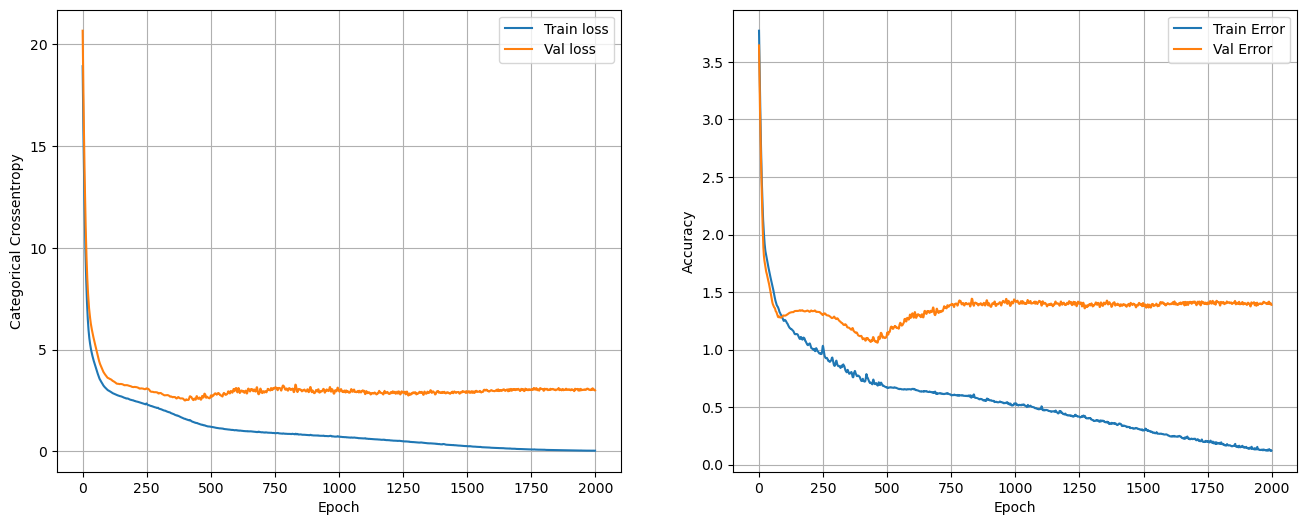

In [400]:
show_loss_accuracy_evolution(history)

Test Loss: 11.299009323120117
Test Accuracy: 2.1865100860595703
36/36 [==============================] - 0s 1ms/step
Coeficiente de correlacion: 0.4518847509863302


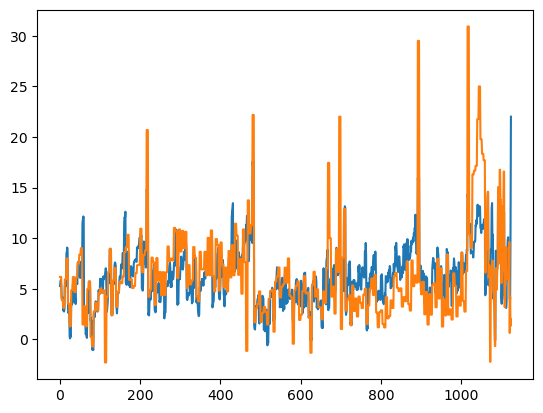

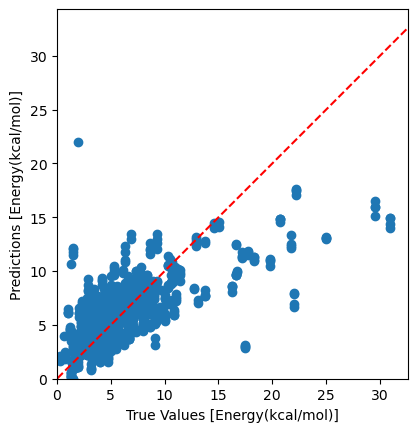

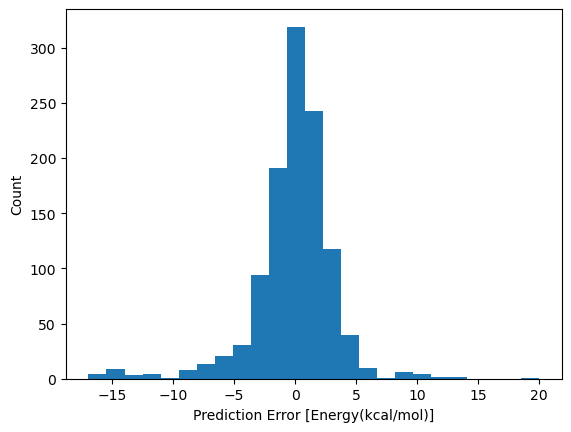

In [401]:
show_results(model,X_test,y_test)

dict_keys(['inputs', 'flatten', 'dense', 'output'])


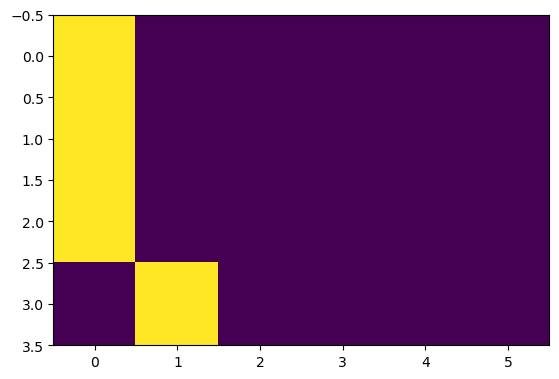

In [402]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

feature_maps shape:  (1, 24)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} Index out of range using input dim 2; input has only 2 dims [Op:StridedSlice] name: strided_slice/

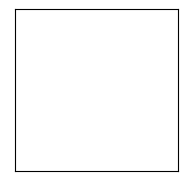

In [403]:
show_features(features,'flatten')

In [405]:
def ConvNN(filters=51, kernel_size=(7,7), unit1=168, unit2=157, unit3=205, unit4=12, dropout1=0.08161034482758621, dropout2=0.18786206896551724, dropout3=0.42844827586206896): 
    
    model = Sequential()
    #model.add(Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, dilation_rate=(1, 1), activation=None))
    #model.add(Conv2D(filters=64, kernel_size=7, activation='relu', input_shape=(7, 42, 1) ))
    model.add(Conv2D(filters=filters, kernel_size=kernel_size, padding='same', activation='relu', input_shape=(4, 6, 1) ))

    model.add(Conv2D(64, 1, padding='same', activation='relu'))
    #model.add(MaxPooling2D(4))
    #model.add(Conv2D(64, 1, activation='relu'))
#    model.add(GlobalAveragePooling2D())
#    model.add(Dropout(0.5))
    
    model.add(Flatten())
    
    #model.add(Dense(units=294, activation='relu', input_dim=294))
    #model.add(Dense(units=256, activation='relu'))
    model.add(Dense(units=unit1, activation='relu'))
    model.add(Dropout(dropout1)) ##
    model.add(Dense(units=unit2, activation='relu'))
    model.add(Dropout(dropout2)) 
    model.add(Dense(units=unit3, activation='relu'))
    model.add(Dropout(dropout3)) ##
    model.add(Dense(units=unit4, activation='relu'))
    model.add(Dense(units=1, activation='linear'))                         #ingen aktivering til sidste lag, fordi vi Ã¸nsker den fulde vÃ¦rdi i outputtet
    #model.add(Dense(units=1))

    #model.compile(loss='logcosh', optimizer='adam', metrics=['accuracy']) #accuracy er en metric til classification
    model.compile(loss='logcosh', optimizer='Nadam', metrics=['mean_absolute_error'])

    
    return model

In [406]:
## DEFINE SOME EARLY STOPPING CONDITIONS
esNOSTOP = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights=True)   #alternative patience=np.inf
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

In [407]:
model = ConvNN(filters=64, kernel_size=(2,2), unit1=96, unit2=48, unit3=24, unit4=12, dropout1=0.08161034482758621, dropout2=0.18786206896551724, dropout3=0.42844827586206896)

In [408]:
ITER = 500
BATCH = 32
VERBOSE = 0

#CALLBACKS = [esNOSTOP, reduce_lr]
CALLBACKS = []

start_time = time.time()

history = model.fit(X_train, y_train, epochs=ITER, batch_size=BATCH, validation_split=0.2, callbacks=CALLBACKS, verbose=VERBOSE)

print('Runtime:',(time.time()-start_time)/60,'minutes.')

Runtime: 0.4277946750322978 minutes.


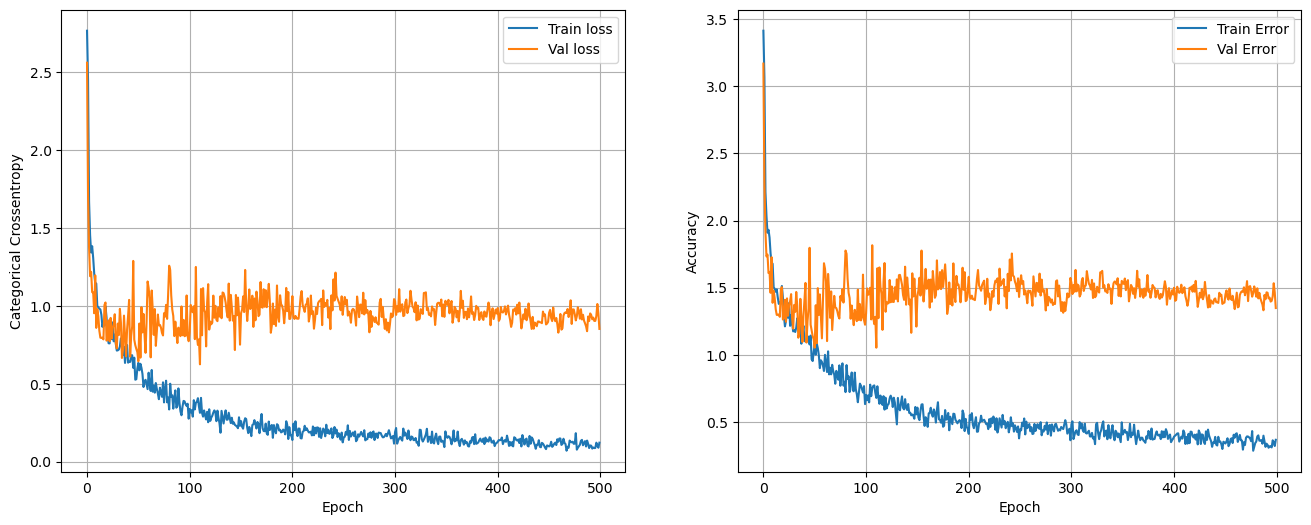

In [409]:
show_loss_accuracy_evolution(history)

Test Loss: 2.50919508934021
Test Accuracy: 3.1063437461853027
36/36 [==============================] - 0s 2ms/step
Coeficiente de correlacion: 0.009286923627426558


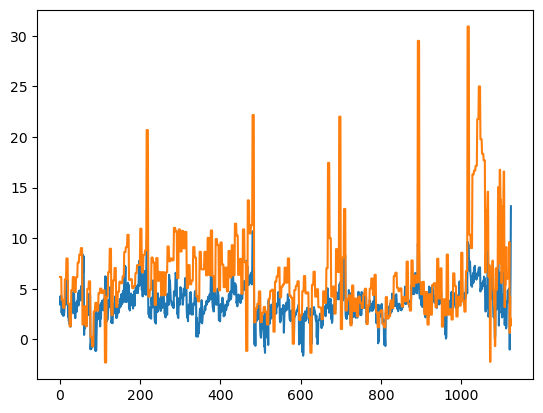

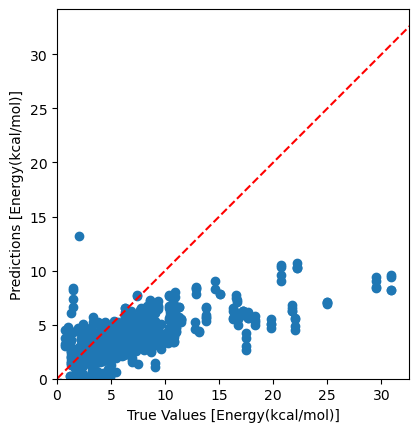

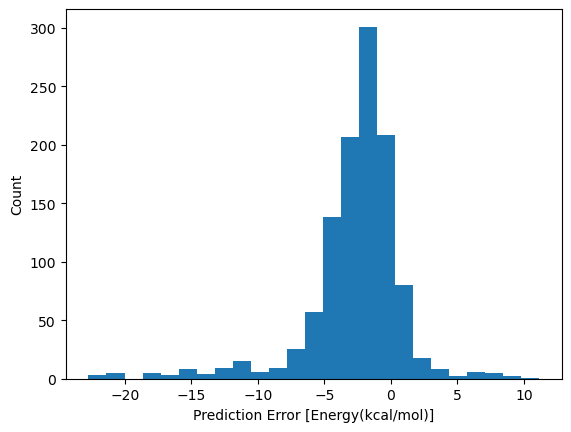

In [410]:
show_results(model,X_test,y_test)

In [411]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

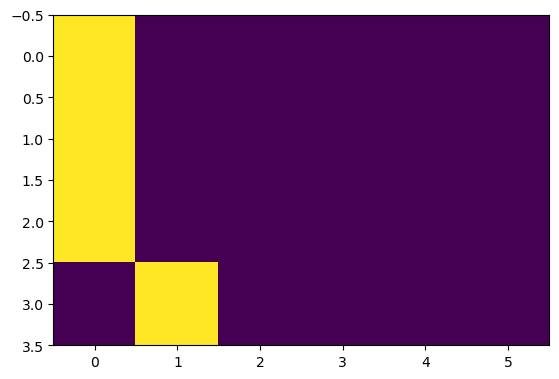

In [412]:
img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

In [413]:
## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

dict_keys(['conv2d_25', 'conv2d_26', 'flatten_14', 'dense_70', 'dropout_44', 'dense_71', 'dropout_45', 'dense_72', 'dropout_46', 'dense_73', 'dense_74'])


feature_maps shape:  (1, 4, 6, 64)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 64 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

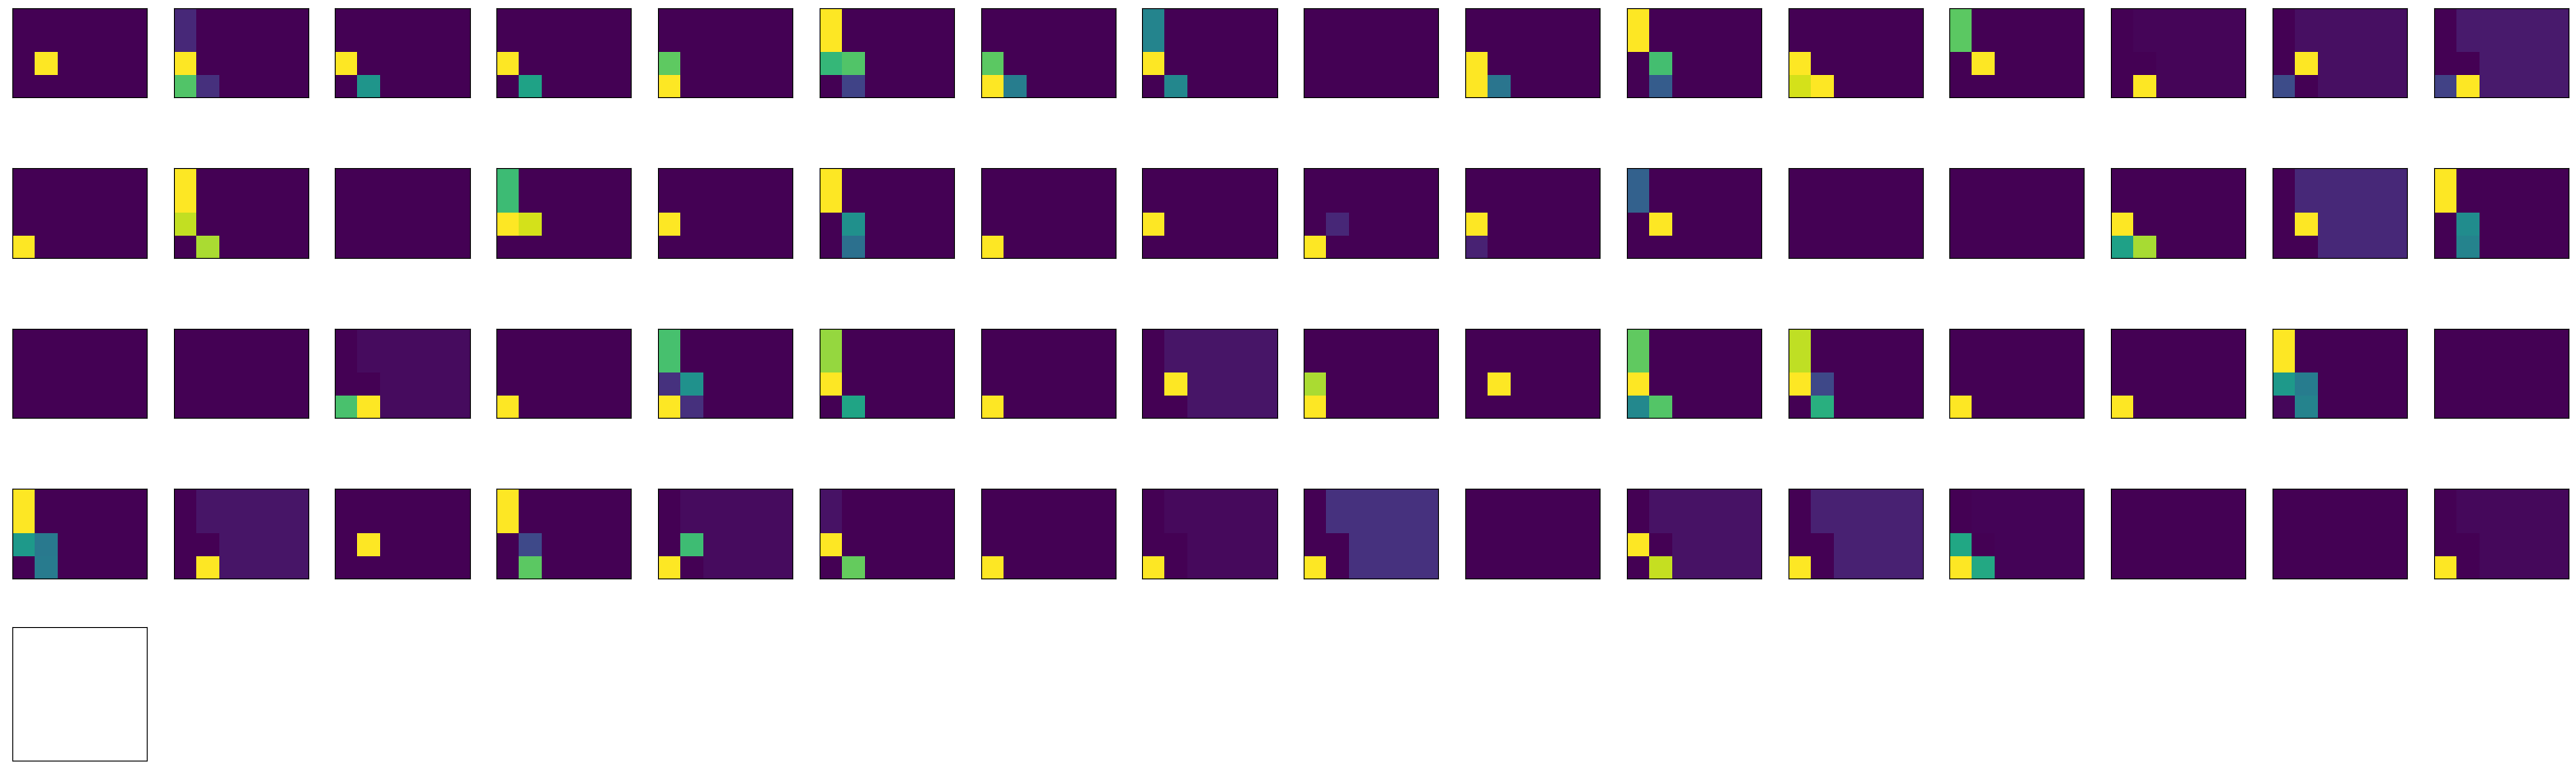

In [415]:
show_features(features,'conv2d_25')

feature_maps shape:  (1, 4, 6, 64)


InvalidArgumentError: {{function_node __wrapped__StridedSlice_device_/job:localhost/replica:0/task:0/device:CPU:0}} slice index 64 of dimension 3 out of bounds. [Op:StridedSlice] name: strided_slice/

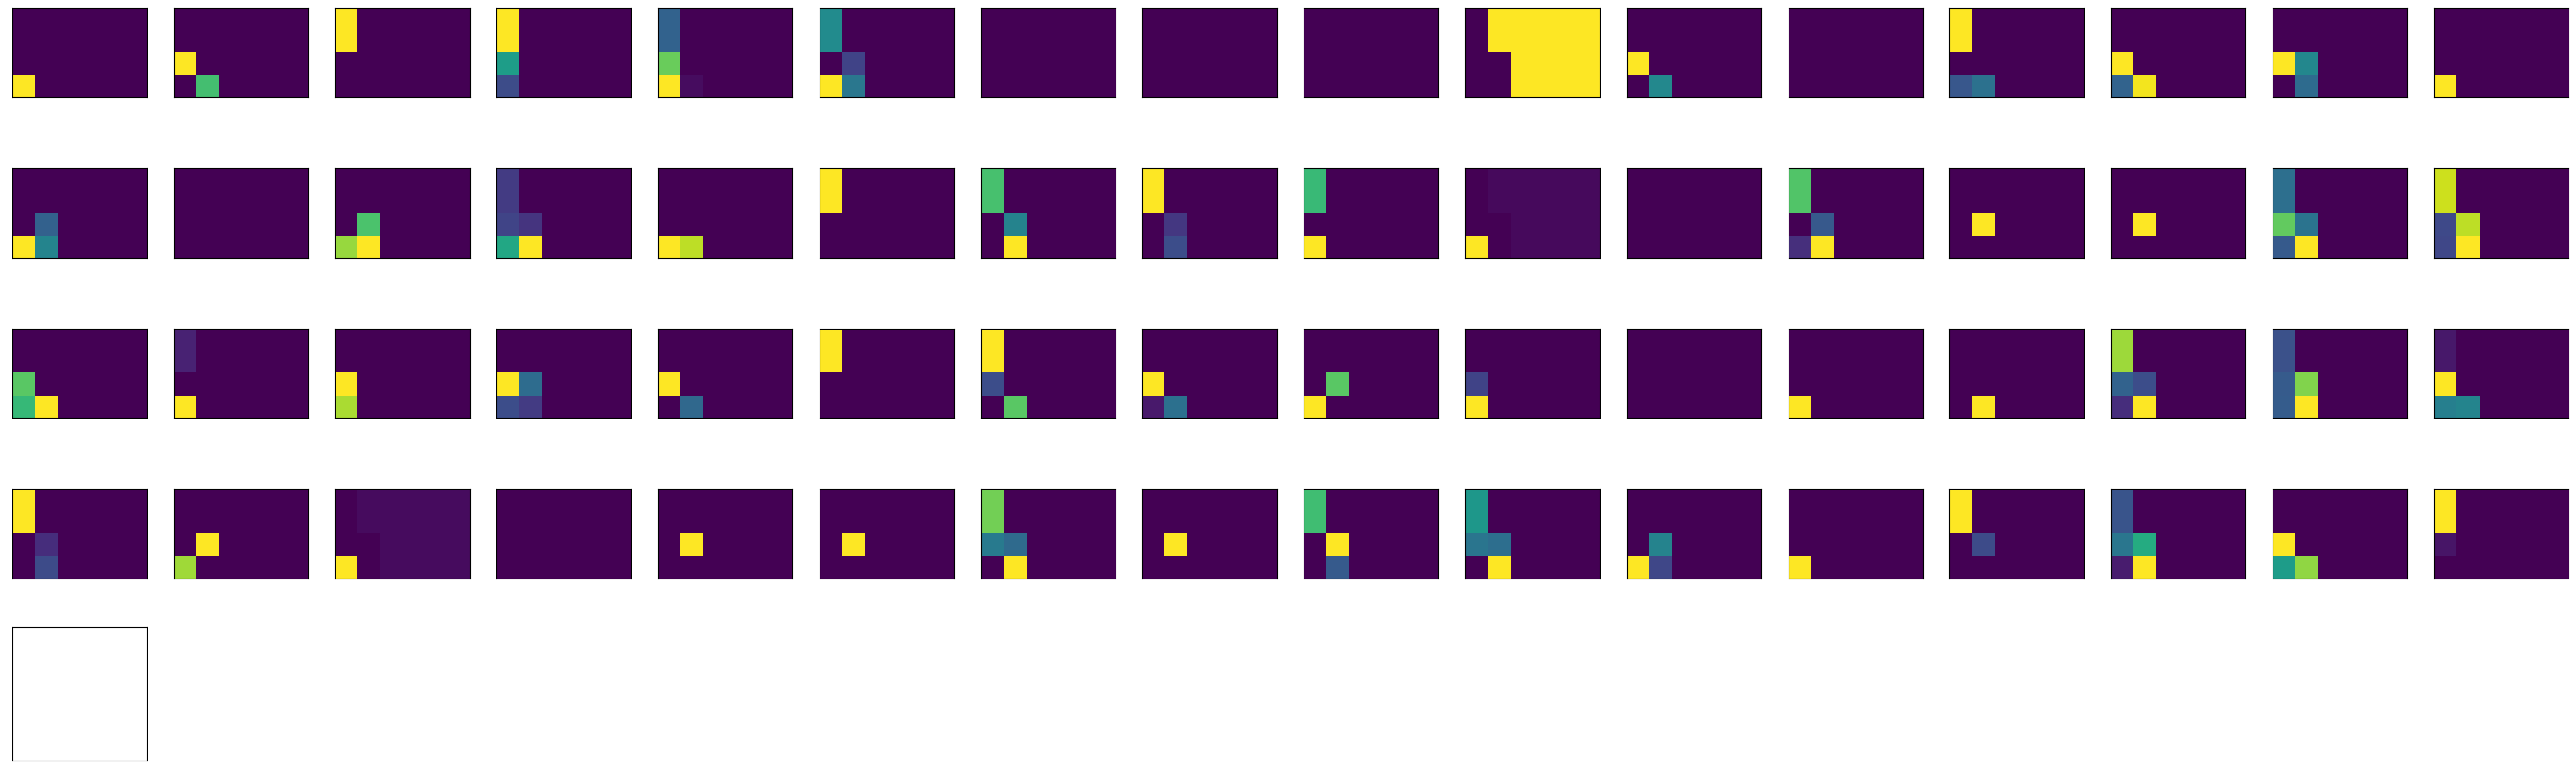

In [417]:
show_features(features,'conv2d_26')

In [456]:
from tensorflow import keras
from tensorflow.keras import layers

# Definir los filtros personalizados
filtros = [np.array([
    [1, 1, 1],
    [0, 0, 0],
    [-1, -1, -1]
])]

# Definir la arquitectura de la red
model = keras.Sequential([
    layers.Conv2D(1, (3, 3), strides=1, input_shape=(4, 6, 1), activation='relu', 
                  kernel_initializer=keras.initializers.Constant(filtros), trainable=False),
    layers.Flatten(),
    layers.Dense(24, activation='elu'),
    layers.Dense(1, activation='linear')
])

# Compilar y entrenar la red
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
6/6 [==============================] - 1s 3ms/step - loss: 16.4811 - accuracy: 0.0000e+00
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 15.9256 - accuracy: 0.0000e+00
Epoch 3/100
6/6 [==============================] - 0s 3ms/step - loss: 15.3831 - accuracy: 0.0000e+00
Epoch 4/100
6/6 [==============================] - 0s 2ms/step - loss: 14.8569 - accuracy: 0.0000e+00
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 14.3624 - accuracy: 0.0000e+00
Epoch 6/100
6/6 [==============================] - 0s 2ms/step - loss: 13.9057 - accuracy: 0.0000e+00
Epoch 7/100
6/6 [==============================] - 0s 3ms/step - loss: 13.4302 - accuracy: 0.0000e+00
Epoch 8/100
6/6 [==============================] - 0s 2ms/step - loss: 13.0246 - accuracy: 0.0000e+00
Epoch 9/100
6/6 [==============================] - 0s 2ms/step - loss: 12.6029 - accuracy: 0.0000e+00
Epoch 10/100
6/6 [==============================] - 0s 3ms/step - loss: 12.2271 - 

6/6 [==============================] - 0s 2ms/step - loss: 5.7015 - accuracy: 0.0000e+00
Epoch 82/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6915 - accuracy: 0.0000e+00
Epoch 83/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6788 - accuracy: 0.0000e+00
Epoch 84/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6687 - accuracy: 0.0000e+00
Epoch 85/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6599 - accuracy: 0.0000e+00
Epoch 86/100
6/6 [==============================] - 0s 1ms/step - loss: 5.6453 - accuracy: 0.0000e+00
Epoch 87/100
6/6 [==============================] - 0s 1ms/step - loss: 5.6373 - accuracy: 0.0000e+00
Epoch 88/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6251 - accuracy: 0.0000e+00
Epoch 89/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6186 - accuracy: 0.0000e+00
Epoch 90/100
6/6 [==============================] - 0s 2ms/step - loss: 5.6115 - accuracy: 0.00

Test Loss: 31.135517120361328
Test Accuracy: 0.0
36/36 [==============================] - 0s 1ms/step
Coeficiente de correlacion: -0.5103847505635244


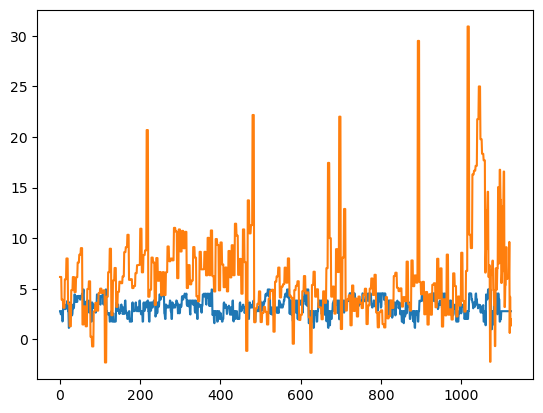

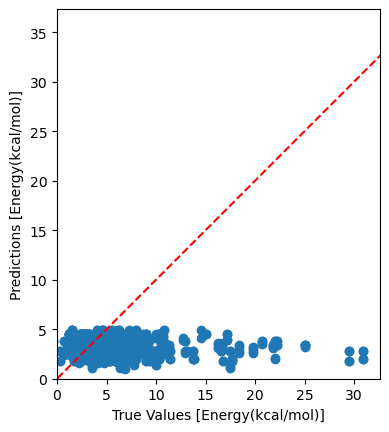

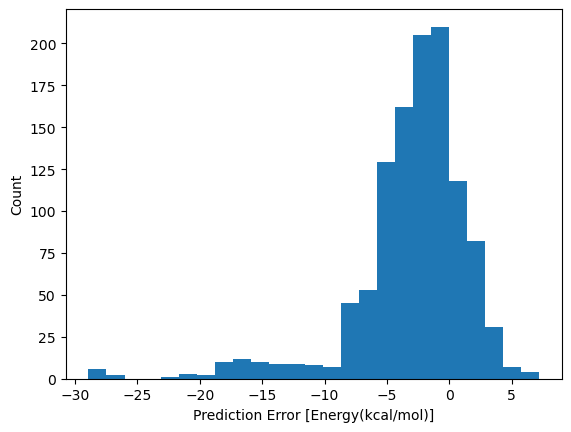

In [457]:
show_results(model,X_test,y_test)

dict_keys(['conv2d_40', 'flatten_28', 'dense_95', 'dense_96'])


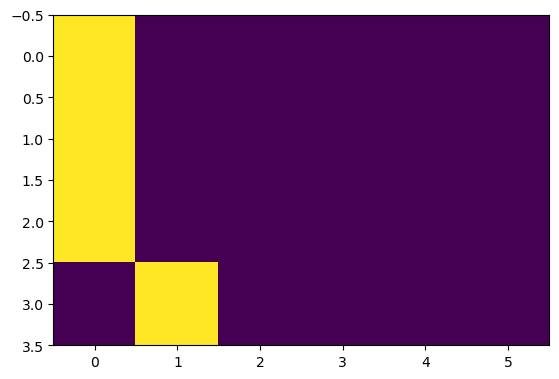

In [458]:
from tensorflow.keras.models import Model

# Get the symbolic outputs of each "key" layer (we gave them unique names).
outputs_dict = {layer.name: layer.output for layer in model.layers}
# Set up a model that returns the activation values for every layer in
# VGG19 (as a dict).
feature_extractor = keras.Model(inputs=model.inputs,
                                outputs=outputs_dict)

img = np.expand_dims(X_train[0], axis=0)
plt.imshow(X_train[0], cmap='viridis')

## Get the features of the image
features = feature_extractor(img)
print(features.keys())
#print(list(features.items())[0])

feature_maps shape:  (1, 2, 4, 1)


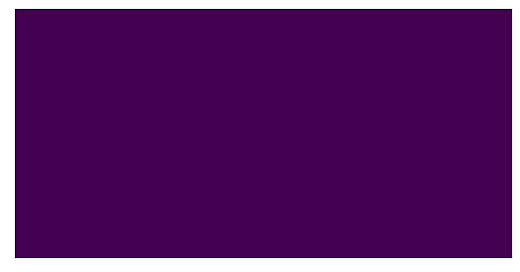

tf.Tensor(
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]], shape=(2, 4), dtype=float32)


In [460]:
show_features2(features,'conv2d_40')